# Training on SAE Sparse Features

Loss factor of 0.01, working with the 25 highest activating features per digit

Cosine instead of MSE for auxilary loss - it seemed to work quite well, and makes auxiliary loss easier to manage w/global loss.

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 256
L1_PENALTY = 0.01
N = 25

## Imports

In [3]:
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature,
                    feature_inversion
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, load_intermediate_labels

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [7]:
# train data
train_images = load_intermediate_labels("first_layer/train_images.pkl")
train_labels = load_intermediate_labels("first_layer/train_labels.pkl")

# val data
val_images = load_intermediate_labels("first_layer/val_images.pkl")
val_labels = load_intermediate_labels("first_layer/val_labels.pkl")

# test data
test_images = load_intermediate_labels("first_layer/test_images.pkl")
test_labels = load_intermediate_labels("first_layer/test_labels.pkl")

# intermediate labels
recon_max_sparse_act_one = load_intermediate_labels(f"first_layer/train_images_recon_max_sparse_top_{N}.pkl")
recon_max_sparse_act_one_ablated = load_intermediate_labels(f"first_layer/train_images_recon_max_sparse_ablated_top_{N}.pkl")

In [8]:
type(recon_max_sparse_act_one[0])

torch.Tensor

In [9]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

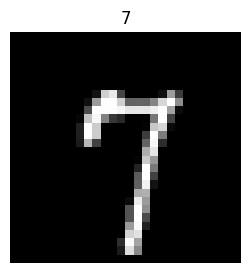

In [10]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

### SAE

In [12]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

## Dataloader

In [13]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, first_layer_acts=None):
        self.images = images
        self.labels = labels
        self.first_layer_acts = first_layer_acts

    def __len__(self):
        assert len(self.images) == len(self.labels)
        if self.first_layer_acts:
            assert(len(self.first_layer_acts) == len(self.images))
            
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).float()
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)

        if self.first_layer_acts:
            return (image, label, self.first_layer_acts[idx])
        else:
            return (image, label)

In [14]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Training Loop

In [16]:
loss_factors = np.arange(0.01 + 0.001, 0.05 + 0.001, 0.001)
print(len(loss_factors))

41


In [17]:
loss_data_dict = {}
for loss_factor in loss_factors:
    print("#" * 50)
    print(f"Loss factor: {loss_factor}\n\n")
    ######################################################################################################
    # MODELS INIT
    ######################################################################################################
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    model = NeuralNetwork().to(device)
    
    # loss functions
    classification_loss_fn = nn.CrossEntropyLoss()
    hidden_act_one_loss_fn = nn.CosineSimilarity()
    
    # optimizers
    optimizer = torch.optim.Adam(model.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())
    
    ######################################################################################################
    # DATA INIT
    ######################################################################################################
    
    generator = torch.Generator().manual_seed(seed)
    
    NUM_WORKERS = 4
    if device.type.lower() == "cpu":
        NUM_WORKERS = 0
    
    # training data
    train_dataset = EdgeDataset(train_images, train_labels, recon_max_sparse_act_one)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)
    
    # validation data
    val_dataset = EdgeDataset(val_images, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation
    
    # test data
    test_dataset = EdgeDataset(test_images, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)
    
    ######################################################################################################
    # TRAINING LOOP
    ######################################################################################################
    best_model = None
    best_sae_one = None
    best_sae_two = None
    num_epochs = 20
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    
    validation_losses = []
    training_losses = []
    SAE_hidden_one_losses = []
    SAE_hidden_two_losses = []
    
    # Initialize storage for training features and labels
    feature_activations_one_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    feature_activations_two_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    labels_train = torch.zeros(len(train_loader.dataset), dtype=torch.long)
    
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()  # set the model to training mode - this is currently a no-op
        sae_hidden_two.train()
        sae_hidden_one.train()
        
        train_loss = 0.0
        total_sae_loss_hidden_two = 0.0
        total_sae_loss_hidden_one = 0.0
    
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for batch_idx, batch in enumerate(train_bar):
            # deconstruct batch items
            images, labels, acts_one = batch
            images, labels, acts_one = images.to(device), labels.to(device), acts_one.to(device)
            
            # forward pass
            classification_out, hidden_act_one, hidden_act_two = model(images)
    
            # Classification loss and backprop
            optimizer.zero_grad()
            
            sub_loss = (1 - hidden_act_one_loss_fn(hidden_act_one, acts_one)).mean()
            total_loss = classification_loss_fn(classification_out, labels) + loss_factor * (sub_loss)
            total_loss.backward()
            
            optimizer.step()
            train_loss += total_loss.item()
            train_bar.set_postfix(loss=total_loss.item())
    
            # to prevent backprop on both graphs:
            hidden_act_one_detached = hidden_act_one.detach()
            hidden_act_two_detached = hidden_act_two.detach()
    
            # SAE loss and backprop - hidden layer one
            optimizer_sae_hidden_one.zero_grad()
            reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
            sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                      reconstructed_one,
                                                      encoded_one,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_one.backward()
            optimizer_sae_hidden_one.step()
            total_sae_loss_hidden_one += sae_loss_hidden_one.item()
            
            # SAE loss and backprop - hidden layer two
            optimizer_sae_hidden_two.zero_grad()
            reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
            sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                      reconstructed_two,
                                                      encoded_two,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_two.backward()
            optimizer_sae_hidden_two.step()
            total_sae_loss_hidden_two += sae_loss_hidden_two.item()
    
            # Store training features and labels
            start_idx = batch_idx * train_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_train[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_train[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_train[start_idx:end_idx] = labels.cpu()
    
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch in val_bar:
                # deconstruct
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
    
                # forward pass
                classification_out, _, _ = model(images)
    
                # compute loss
                loss = classification_loss_fn(classification_out, labels)
    
                # calculate metrics
                val_loss += loss.item()
                _, predicted = torch.max(classification_out, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
        # epoch stats
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
        avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
        val_accuracy = 100 * correct / total
    
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
        print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    
        model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_val_loss = avg_val_loss  # Update loss for reference
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
            
        # Optional: Save if accuracy is equal but loss is lower
        elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
    
        validation_losses.append(avg_val_loss)
        training_losses.append(avg_train_loss)
        SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
        SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)
    
    Z_train_one = feature_activations_one_train.detach().T.numpy()
    Z_train_two = feature_activations_two_train.detach().T.numpy()
    y_train = labels_train.numpy()
    
    
    ######################################################################################################
    # EVAL
    ######################################################################################################
    best_model.eval()  # again currently a no-op
    best_sae_one.eval()
    best_sae_two.eval()
    
    test_correct = 0
    test_total = 0
    
    feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    labels_test = torch.zeros(len(test_images), dtype=torch.long)
    
    recon_errors_one = []
    recon_errors_two = []
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Evaluation")
        for i, batch in enumerate(test_bar):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
    
            # forward pass
            classification_out, hidden_one_act, hidden_two_act = best_model(images)
            reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
            reconstructed_two, encoded_two = best_sae_two(hidden_two_act)
    
            # SAE reconstruction
            recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
            recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())
    
            start_idx = i * test_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_test[start_idx:end_idx] = labels.cpu()
    
            # stats
            _, predicted = torch.max(classification_out, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    Z_test_one = feature_activations_one_test.T.numpy()
    Z_test_two = feature_activations_two_test.T.numpy()
    y_test = labels_test.numpy()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    
    # reconstruction accuracy of SAE at each layer
    avg_recon_error_one = np.mean(recon_errors_one)
    avg_recon_error_two = np.mean(recon_errors_two)
    print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
    print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")
    
    # Compute sparsity (average non-zero features per image)
    sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
    sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
    print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
    print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")
    
    ######################################################################################################
    # SPARSE FEATURE PROBES
    ######################################################################################################
        
    clf_one = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_one.fit(Z_train_one, y_train)
    acc_one = clf_one.score(Z_test_one, y_test)
    print(f"Linear Probe Accuracy (Hidden One): {acc_one:.2%}")
    
    clf_two = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_two.fit(Z_train_two, y_train)
    acc_two = clf_two.score(Z_test_two, y_test)
    print(f"Linear Probe Accuracy (Hidden Two): {acc_two:.2%}")

    loss_data_dict[loss_factor] = {}
    loss_data_dict[loss_factor]["Final_Accuracy"] = test_accuracy
    loss_data_dict[loss_factor]["Final_Loss"] = avg_train_loss
    loss_data_dict[loss_factor]["S1_Probe_Acccuracy"] = acc_one
    loss_data_dict[loss_factor]["S2_Probe_Acccuracy"] = acc_two
    loss_data_dict[loss_factor]["Loss_Plot_Data"] = (validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses)

    del feature_activations_one_train, feature_activations_two_train, labels_train
    del feature_activations_one_test, feature_activations_two_test, labels_test
    del best_model, best_sae_one, best_sae_two
    del validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses
    del clf_two, clf_one
    del model, sae_hidden_one, sae_hidden_two
    del train_dataset, train_loader
    del test_dataset, test_loader
    del val_dataset, val_loader
    torch.cuda.empty_cache()
    print()

##################################################
Loss factor: 0.011




Epoch 1/20
  Train Loss: 1.0349
  SAE Train Loss (hidden one): 8.8846
  SAE Train Loss (hidden two): 1.1701
  Val Loss: 0.5179 | Val Acc: 84.81%
  Saved model with Val Acc: 84.81%


Epoch 2/20
  Train Loss: 0.4348
  SAE Train Loss (hidden one): 0.5617
  SAE Train Loss (hidden two): 0.1077
  Val Loss: 0.3854 | Val Acc: 88.50%
  Saved model with Val Acc: 88.50%


Epoch 3/20
  Train Loss: 0.3585
  SAE Train Loss (hidden one): 0.6824
  SAE Train Loss (hidden two): 0.1113
  Val Loss: 0.3757 | Val Acc: 89.32%
  Saved model with Val Acc: 89.32%


Epoch 4/20
  Train Loss: 0.3337
  SAE Train Loss (hidden one): 0.6573
  SAE Train Loss (hidden two): 0.1001
  Val Loss: 0.3485 | Val Acc: 89.69%
  Saved model with Val Acc: 89.69%


Epoch 5/20
  Train Loss: 0.3176
  SAE Train Loss (hidden one): 0.6552
  SAE Train Loss (hidden two): 0.0938
  Val Loss: 0.3276 | Val Acc: 90.50%
  Saved model with Val Acc: 90.50%


Epoch 6/20
  Train Loss: 0.3040
  SAE Train Loss (hidden one): 0.7482
  SAE Train Loss (hidden two): 0.0909
  Val Loss: 0.3124 | Val Acc: 91.03%
  Saved model with Val Acc: 91.03%


Epoch 7/20
  Train Loss: 0.2958
  SAE Train Loss (hidden one): 0.7586
  SAE Train Loss (hidden two): 0.0837
  Val Loss: 0.3307 | Val Acc: 90.46%


Epoch 8/20
  Train Loss: 0.2919
  SAE Train Loss (hidden one): 0.7302
  SAE Train Loss (hidden two): 0.0828
  Val Loss: 0.3045 | Val Acc: 91.31%
  Saved model with Val Acc: 91.31%


Epoch 9/20
  Train Loss: 0.2846
  SAE Train Loss (hidden one): 0.7072
  SAE Train Loss (hidden two): 0.0785
  Val Loss: 0.3374 | Val Acc: 90.34%


Epoch 10/20
  Train Loss: 0.2807
  SAE Train Loss (hidden one): 0.8497
  SAE Train Loss (hidden two): 0.0784
  Val Loss: 0.2898 | Val Acc: 91.62%
  Saved model with Val Acc: 91.62%


Epoch 11/20
  Train Loss: 0.2634
  SAE Train Loss (hidden one): 0.9403
  SAE Train Loss (hidden two): 0.0780
  Val Loss: 0.2823 | Val Acc: 91.69%
  Saved model with Val Acc: 91.69%


Epoch 12/20
  Train Loss: 0.2580
  SAE Train Loss (hidden one): 0.9176
  SAE Train Loss (hidden two): 0.0730
  Val Loss: 0.2852 | Val Acc: 91.95%
  Saved model with Val Acc: 91.95%


Epoch 13/20
  Train Loss: 0.2482
  SAE Train Loss (hidden one): 0.9493
  SAE Train Loss (hidden two): 0.0710
  Val Loss: 0.2724 | Val Acc: 91.99%
  Saved model with Val Acc: 91.99%


Epoch 14/20
  Train Loss: 0.2442
  SAE Train Loss (hidden one): 0.9099
  SAE Train Loss (hidden two): 0.0696
  Val Loss: 0.2975 | Val Acc: 91.47%


Epoch 15/20
  Train Loss: 0.2360
  SAE Train Loss (hidden one): 0.7899
  SAE Train Loss (hidden two): 0.0691
  Val Loss: 0.2703 | Val Acc: 92.03%
  Saved model with Val Acc: 92.03%


Epoch 16/20
  Train Loss: 0.2352
  SAE Train Loss (hidden one): 0.8165
  SAE Train Loss (hidden two): 0.0651
  Val Loss: 0.2660 | Val Acc: 92.33%
  Saved model with Val Acc: 92.33%


Epoch 17/20
  Train Loss: 0.2283
  SAE Train Loss (hidden one): 0.7939
  SAE Train Loss (hidden two): 0.0619
  Val Loss: 0.2746 | Val Acc: 92.19%


Epoch 18/20
  Train Loss: 0.2275
  SAE Train Loss (hidden one): 0.9194
  SAE Train Loss (hidden two): 0.0632
  Val Loss: 0.2583 | Val Acc: 92.69%
  Saved model with Val Acc: 92.69%


Epoch 19/20
  Train Loss: 0.2238
  SAE Train Loss (hidden one): 0.8331
  SAE Train Loss (hidden two): 0.0601
  Val Loss: 0.2609 | Val Acc: 92.48%


Epoch 20/20
  Train Loss: 0.2206
  SAE Train Loss (hidden one): 0.8691
  SAE Train Loss (hidden two): 0.0579
  Val Loss: 0.2658 | Val Acc: 92.39%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 307.05it/s]

Final Test Accuracy: 92.85%
Average Reconstruction Error (Hidden One): 0.1642
Average Reconstruction Error (Hidden Two): 0.0096
Average Non-Zero Features per Image (Hidden One): 33.58
Average Non-Zero Features per Image (Hidden Two): 35.69



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.56%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.18%

##################################################
Loss factor: 0.012




Epoch 1/20
  Train Loss: 1.0604
  SAE Train Loss (hidden one): 8.6330
  SAE Train Loss (hidden two): 1.1658
  Val Loss: 0.6572 | Val Acc: 82.43%
  Saved model with Val Acc: 82.43%


Epoch 2/20
  Train Loss: 0.4786
  SAE Train Loss (hidden one): 0.8516
  SAE Train Loss (hidden two): 0.1150
  Val Loss: 0.3913 | Val Acc: 88.81%
  Saved model with Val Acc: 88.81%


Epoch 3/20
  Train Loss: 0.3576
  SAE Train Loss (hidden one): 0.5887
  SAE Train Loss (hidden two): 0.0910
  Val Loss: 0.3514 | Val Acc: 89.66%
  Saved model with Val Acc: 89.66%


Epoch 4/20
  Train Loss: 0.3280
  SAE Train Loss (hidden one): 0.5339
  SAE Train Loss (hidden two): 0.0806
  Val Loss: 0.3354 | Val Acc: 90.25%
  Saved model with Val Acc: 90.25%


Epoch 5/20
  Train Loss: 0.3114
  SAE Train Loss (hidden one): 0.5165
  SAE Train Loss (hidden two): 0.0730
  Val Loss: 0.3121 | Val Acc: 91.25%
  Saved model with Val Acc: 91.25%


Epoch 6/20
  Train Loss: 0.2953
  SAE Train Loss (hidden one): 0.7545
  SAE Train Loss (hidden two): 0.0697
  Val Loss: 0.3024 | Val Acc: 91.34%
  Saved model with Val Acc: 91.34%


Epoch 7/20
  Train Loss: 0.2874
  SAE Train Loss (hidden one): 0.5744
  SAE Train Loss (hidden two): 0.0674
  Val Loss: 0.2965 | Val Acc: 91.35%
  Saved model with Val Acc: 91.35%


Epoch 8/20
  Train Loss: 0.2772
  SAE Train Loss (hidden one): 0.5794
  SAE Train Loss (hidden two): 0.0628
  Val Loss: 0.2900 | Val Acc: 91.70%
  Saved model with Val Acc: 91.70%


Epoch 9/20
  Train Loss: 0.2717
  SAE Train Loss (hidden one): 0.6038
  SAE Train Loss (hidden two): 0.0610
  Val Loss: 0.3154 | Val Acc: 90.52%


Epoch 10/20
  Train Loss: 0.2692
  SAE Train Loss (hidden one): 0.6139
  SAE Train Loss (hidden two): 0.0591
  Val Loss: 0.2836 | Val Acc: 91.77%
  Saved model with Val Acc: 91.77%


Epoch 11/20
  Train Loss: 0.2613
  SAE Train Loss (hidden one): 0.6432
  SAE Train Loss (hidden two): 0.0567
  Val Loss: 0.2870 | Val Acc: 91.86%
  Saved model with Val Acc: 91.86%


Epoch 12/20
  Train Loss: 0.2590
  SAE Train Loss (hidden one): 0.6582
  SAE Train Loss (hidden two): 0.0555
  Val Loss: 0.2703 | Val Acc: 92.08%
  Saved model with Val Acc: 92.08%


Epoch 13/20
  Train Loss: 0.2564
  SAE Train Loss (hidden one): 0.7007
  SAE Train Loss (hidden two): 0.0558
  Val Loss: 0.2897 | Val Acc: 91.52%


Epoch 14/20
  Train Loss: 0.2523
  SAE Train Loss (hidden one): 0.6188
  SAE Train Loss (hidden two): 0.0527
  Val Loss: 0.2774 | Val Acc: 91.79%


Epoch 15/20
  Train Loss: 0.2531
  SAE Train Loss (hidden one): 0.6607
  SAE Train Loss (hidden two): 0.0519
  Val Loss: 0.2818 | Val Acc: 91.71%


Epoch 16/20
  Train Loss: 0.2479
  SAE Train Loss (hidden one): 0.6088
  SAE Train Loss (hidden two): 0.0507
  Val Loss: 0.2700 | Val Acc: 92.20%
  Saved model with Val Acc: 92.20%


Epoch 17/20
  Train Loss: 0.2459
  SAE Train Loss (hidden one): 0.6795
  SAE Train Loss (hidden two): 0.0504
  Val Loss: 0.2733 | Val Acc: 92.06%


Epoch 18/20
  Train Loss: 0.2466
  SAE Train Loss (hidden one): 0.6133
  SAE Train Loss (hidden two): 0.0479
  Val Loss: 0.2715 | Val Acc: 92.10%


Epoch 19/20
  Train Loss: 0.2442
  SAE Train Loss (hidden one): 0.6899
  SAE Train Loss (hidden two): 0.0491
  Val Loss: 0.3099 | Val Acc: 90.86%


Epoch 20/20
  Train Loss: 0.2417
  SAE Train Loss (hidden one): 0.9535
  SAE Train Loss (hidden two): 0.0500
  Val Loss: 0.2826 | Val Acc: 92.01%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 342.36it/s]


Final Test Accuracy: 92.40%
Average Reconstruction Error (Hidden One): 0.2516
Average Reconstruction Error (Hidden Two): 0.0204
Average Non-Zero Features per Image (Hidden One): 33.49
Average Non-Zero Features per Image (Hidden Two): 34.33


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 89.52%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.10%

##################################################
Loss factor: 0.013000000000000001




Epoch 1/20
  Train Loss: 1.0543
  SAE Train Loss (hidden one): 8.6564
  SAE Train Loss (hidden two): 1.1751
  Val Loss: 0.6228 | Val Acc: 83.90%
  Saved model with Val Acc: 83.90%


Epoch 2/20
  Train Loss: 0.4821
  SAE Train Loss (hidden one): 0.7051
  SAE Train Loss (hidden two): 0.1101
  Val Loss: 0.4355 | Val Acc: 87.23%
  Saved model with Val Acc: 87.23%


Epoch 3/20
  Train Loss: 0.3841
  SAE Train Loss (hidden one): 0.5659
  SAE Train Loss (hidden two): 0.0947
  Val Loss: 0.3937 | Val Acc: 88.34%
  Saved model with Val Acc: 88.34%


Epoch 4/20
  Train Loss: 0.3604
  SAE Train Loss (hidden one): 0.5464
  SAE Train Loss (hidden two): 0.0796
  Val Loss: 0.3793 | Val Acc: 88.99%
  Saved model with Val Acc: 88.99%


Epoch 5/20
  Train Loss: 0.3471
  SAE Train Loss (hidden one): 0.5496
  SAE Train Loss (hidden two): 0.0767
  Val Loss: 0.3637 | Val Acc: 89.27%
  Saved model with Val Acc: 89.27%


Epoch 6/20
  Train Loss: 0.3354
  SAE Train Loss (hidden one): 0.6247
  SAE Train Loss (hidden two): 0.0807
  Val Loss: 0.3397 | Val Acc: 90.43%
  Saved model with Val Acc: 90.43%


Epoch 7/20
  Train Loss: 0.3311
  SAE Train Loss (hidden one): 0.5929
  SAE Train Loss (hidden two): 0.0722
  Val Loss: 0.3662 | Val Acc: 89.25%


Epoch 8/20
  Train Loss: 0.3253
  SAE Train Loss (hidden one): 0.6144
  SAE Train Loss (hidden two): 0.0704
  Val Loss: 0.3365 | Val Acc: 90.35%


Epoch 9/20
  Train Loss: 0.3152
  SAE Train Loss (hidden one): 0.6061
  SAE Train Loss (hidden two): 0.0645
  Val Loss: 0.3280 | Val Acc: 90.58%
  Saved model with Val Acc: 90.58%


Epoch 10/20
  Train Loss: 0.3152
  SAE Train Loss (hidden one): 0.6003
  SAE Train Loss (hidden two): 0.0662
  Val Loss: 0.3474 | Val Acc: 90.03%


Epoch 11/20
  Train Loss: 0.3076
  SAE Train Loss (hidden one): 0.6511
  SAE Train Loss (hidden two): 0.0643
  Val Loss: 0.3252 | Val Acc: 90.48%


Epoch 12/20
  Train Loss: 0.3033
  SAE Train Loss (hidden one): 0.6597
  SAE Train Loss (hidden two): 0.0634
  Val Loss: 0.3297 | Val Acc: 90.67%
  Saved model with Val Acc: 90.67%


Epoch 13/20
  Train Loss: 0.3003
  SAE Train Loss (hidden one): 0.6260
  SAE Train Loss (hidden two): 0.0604
  Val Loss: 0.3257 | Val Acc: 90.45%


Epoch 14/20
  Train Loss: 0.2949
  SAE Train Loss (hidden one): 0.6266
  SAE Train Loss (hidden two): 0.0581
  Val Loss: 0.3244 | Val Acc: 90.26%


Epoch 15/20
  Train Loss: 0.2935
  SAE Train Loss (hidden one): 0.5930
  SAE Train Loss (hidden two): 0.0576
  Val Loss: 0.3417 | Val Acc: 90.27%


Epoch 16/20
  Train Loss: 0.2877
  SAE Train Loss (hidden one): 0.6301
  SAE Train Loss (hidden two): 0.0558
  Val Loss: 0.3287 | Val Acc: 90.52%


Epoch 17/20
  Train Loss: 0.2861
  SAE Train Loss (hidden one): 0.6218
  SAE Train Loss (hidden two): 0.0558
  Val Loss: 0.3202 | Val Acc: 90.93%
  Saved model with Val Acc: 90.93%


Epoch 18/20
  Train Loss: 0.2829
  SAE Train Loss (hidden one): 0.6223
  SAE Train Loss (hidden two): 0.0554
  Val Loss: 0.3180 | Val Acc: 90.93%
  Saved model with same Val Acc: 90.93% but lower Val Loss: 0.3180


Epoch 19/20
  Train Loss: 0.2796
  SAE Train Loss (hidden one): 0.6678
  SAE Train Loss (hidden two): 0.0545
  Val Loss: 0.3296 | Val Acc: 90.68%


Epoch 20/20
  Train Loss: 0.2770
  SAE Train Loss (hidden one): 0.7602
  SAE Train Loss (hidden two): 0.0529
  Val Loss: 0.3195 | Val Acc: 90.90%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 329.99it/s]

Final Test Accuracy: 91.47%
Average Reconstruction Error (Hidden One): 0.1427
Average Reconstruction Error (Hidden Two): 0.0171
Average Non-Zero Features per Image (Hidden One): 33.07
Average Non-Zero Features per Image (Hidden Two): 35.00



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.20%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.92%

##################################################
Loss factor: 0.014000000000000002




Epoch 1/20
  Train Loss: 1.0809
  SAE Train Loss (hidden one): 8.5927
  SAE Train Loss (hidden two): 1.1561
  Val Loss: 0.6600 | Val Acc: 83.19%
  Saved model with Val Acc: 83.19%


Epoch 2/20
  Train Loss: 0.5367
  SAE Train Loss (hidden one): 0.4963
  SAE Train Loss (hidden two): 0.1023
  Val Loss: 0.5138 | Val Acc: 84.70%
  Saved model with Val Acc: 84.70%


Epoch 3/20
  Train Loss: 0.4336
  SAE Train Loss (hidden one): 0.4979
  SAE Train Loss (hidden two): 0.0867
  Val Loss: 0.4248 | Val Acc: 87.52%
  Saved model with Val Acc: 87.52%


Epoch 4/20
  Train Loss: 0.3962
  SAE Train Loss (hidden one): 0.4973
  SAE Train Loss (hidden two): 0.0756
  Val Loss: 0.3909 | Val Acc: 88.36%
  Saved model with Val Acc: 88.36%


Epoch 5/20
  Train Loss: 0.3814
  SAE Train Loss (hidden one): 0.4881
  SAE Train Loss (hidden two): 0.0701
  Val Loss: 0.3713 | Val Acc: 89.22%
  Saved model with Val Acc: 89.22%


Epoch 6/20
  Train Loss: 0.3670
  SAE Train Loss (hidden one): 0.5212
  SAE Train Loss (hidden two): 0.0659
  Val Loss: 0.3653 | Val Acc: 89.79%
  Saved model with Val Acc: 89.79%


Epoch 7/20
  Train Loss: 0.3594
  SAE Train Loss (hidden one): 0.4710
  SAE Train Loss (hidden two): 0.0608
  Val Loss: 0.3670 | Val Acc: 89.61%


Epoch 8/20
  Train Loss: 0.3563
  SAE Train Loss (hidden one): 0.4934
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.3617 | Val Acc: 89.51%


Epoch 9/20
  Train Loss: 0.3468
  SAE Train Loss (hidden one): 0.5045
  SAE Train Loss (hidden two): 0.0566
  Val Loss: 0.3791 | Val Acc: 89.08%


Epoch 10/20
  Train Loss: 0.3442
  SAE Train Loss (hidden one): 0.4827
  SAE Train Loss (hidden two): 0.0552
  Val Loss: 0.3813 | Val Acc: 88.98%


Epoch 11/20
  Train Loss: 0.3395
  SAE Train Loss (hidden one): 0.5199
  SAE Train Loss (hidden two): 0.0536
  Val Loss: 0.3512 | Val Acc: 89.86%
  Saved model with Val Acc: 89.86%


Epoch 12/20
  Train Loss: 0.3335
  SAE Train Loss (hidden one): 0.4565
  SAE Train Loss (hidden two): 0.0508
  Val Loss: 0.3595 | Val Acc: 89.48%


Epoch 13/20
  Train Loss: 0.3294
  SAE Train Loss (hidden one): 0.5288
  SAE Train Loss (hidden two): 0.0485
  Val Loss: 0.3411 | Val Acc: 90.24%
  Saved model with Val Acc: 90.24%


Epoch 14/20
  Train Loss: 0.3262
  SAE Train Loss (hidden one): 0.4767
  SAE Train Loss (hidden two): 0.0477
  Val Loss: 0.3584 | Val Acc: 89.35%


Epoch 15/20
  Train Loss: 0.3237
  SAE Train Loss (hidden one): 0.4832
  SAE Train Loss (hidden two): 0.0475
  Val Loss: 0.3674 | Val Acc: 89.51%


Epoch 16/20
  Train Loss: 0.3223
  SAE Train Loss (hidden one): 0.5038
  SAE Train Loss (hidden two): 0.0468
  Val Loss: 0.3494 | Val Acc: 89.71%


Epoch 17/20
  Train Loss: 0.3175
  SAE Train Loss (hidden one): 0.5378
  SAE Train Loss (hidden two): 0.0466
  Val Loss: 0.3410 | Val Acc: 89.92%


Epoch 18/20
  Train Loss: 0.3181
  SAE Train Loss (hidden one): 0.4728
  SAE Train Loss (hidden two): 0.0467
  Val Loss: 0.3412 | Val Acc: 89.92%


Epoch 19/20
  Train Loss: 0.3138
  SAE Train Loss (hidden one): 0.5255
  SAE Train Loss (hidden two): 0.0434
  Val Loss: 0.3619 | Val Acc: 89.44%


Epoch 20/20
  Train Loss: 0.3124
  SAE Train Loss (hidden one): 0.5671
  SAE Train Loss (hidden two): 0.0442
  Val Loss: 0.3445 | Val Acc: 89.95%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 330.48it/s]


Final Test Accuracy: 90.34%
Average Reconstruction Error (Hidden One): 0.6347
Average Reconstruction Error (Hidden Two): 0.0211
Average Non-Zero Features per Image (Hidden One): 32.90
Average Non-Zero Features per Image (Hidden Two): 35.47


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 83.37%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 68.02%

##################################################
Loss factor: 0.015000000000000003




Epoch 1/20
  Train Loss: 1.0809
  SAE Train Loss (hidden one): 8.5970
  SAE Train Loss (hidden two): 1.1574
  Val Loss: 0.6567 | Val Acc: 83.37%
  Saved model with Val Acc: 83.37%


Epoch 2/20
  Train Loss: 0.5315
  SAE Train Loss (hidden one): 0.4973
  SAE Train Loss (hidden two): 0.1009
  Val Loss: 0.4839 | Val Acc: 85.89%
  Saved model with Val Acc: 85.89%


Epoch 3/20
  Train Loss: 0.4328
  SAE Train Loss (hidden one): 0.5077
  SAE Train Loss (hidden two): 0.0852
  Val Loss: 0.4317 | Val Acc: 87.29%
  Saved model with Val Acc: 87.29%


Epoch 4/20
  Train Loss: 0.4010
  SAE Train Loss (hidden one): 0.4887
  SAE Train Loss (hidden two): 0.0730
  Val Loss: 0.3900 | Val Acc: 88.55%
  Saved model with Val Acc: 88.55%


Epoch 5/20
  Train Loss: 0.3833
  SAE Train Loss (hidden one): 0.4890
  SAE Train Loss (hidden two): 0.0705
  Val Loss: 0.3733 | Val Acc: 89.20%
  Saved model with Val Acc: 89.20%


Epoch 6/20
  Train Loss: 0.3664
  SAE Train Loss (hidden one): 0.5061
  SAE Train Loss (hidden two): 0.0644
  Val Loss: 0.3634 | Val Acc: 89.67%
  Saved model with Val Acc: 89.67%


Epoch 7/20
  Train Loss: 0.3639
  SAE Train Loss (hidden one): 0.4801
  SAE Train Loss (hidden two): 0.0611
  Val Loss: 0.3722 | Val Acc: 89.32%


Epoch 8/20
  Train Loss: 0.3561
  SAE Train Loss (hidden one): 0.4853
  SAE Train Loss (hidden two): 0.0582
  Val Loss: 0.3545 | Val Acc: 89.77%
  Saved model with Val Acc: 89.77%


Epoch 9/20
  Train Loss: 0.3470
  SAE Train Loss (hidden one): 0.5287
  SAE Train Loss (hidden two): 0.0549
  Val Loss: 0.3793 | Val Acc: 89.04%


Epoch 10/20
  Train Loss: 0.3446
  SAE Train Loss (hidden one): 0.4831
  SAE Train Loss (hidden two): 0.0532
  Val Loss: 0.3623 | Val Acc: 89.46%


Epoch 11/20
  Train Loss: 0.3392
  SAE Train Loss (hidden one): 0.5241
  SAE Train Loss (hidden two): 0.0532
  Val Loss: 0.3516 | Val Acc: 89.83%
  Saved model with Val Acc: 89.83%


Epoch 12/20
  Train Loss: 0.3350
  SAE Train Loss (hidden one): 0.4779
  SAE Train Loss (hidden two): 0.0506
  Val Loss: 0.3634 | Val Acc: 89.70%


Epoch 13/20
  Train Loss: 0.3321
  SAE Train Loss (hidden one): 0.5565
  SAE Train Loss (hidden two): 0.0478
  Val Loss: 0.3428 | Val Acc: 90.16%
  Saved model with Val Acc: 90.16%


Epoch 14/20
  Train Loss: 0.3258
  SAE Train Loss (hidden one): 0.5170
  SAE Train Loss (hidden two): 0.0486
  Val Loss: 0.3642 | Val Acc: 89.33%


Epoch 15/20
  Train Loss: 0.3248
  SAE Train Loss (hidden one): 0.4725
  SAE Train Loss (hidden two): 0.0462
  Val Loss: 0.3648 | Val Acc: 89.21%


Epoch 16/20
  Train Loss: 0.3220
  SAE Train Loss (hidden one): 0.5292
  SAE Train Loss (hidden two): 0.0454
  Val Loss: 0.3559 | Val Acc: 89.73%


Epoch 17/20
  Train Loss: 0.3178
  SAE Train Loss (hidden one): 0.6032
  SAE Train Loss (hidden two): 0.0443
  Val Loss: 0.3464 | Val Acc: 89.92%


Epoch 18/20
  Train Loss: 0.3161
  SAE Train Loss (hidden one): 0.4780
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.3536 | Val Acc: 89.73%


Epoch 19/20
  Train Loss: 0.3176
  SAE Train Loss (hidden one): 0.5465
  SAE Train Loss (hidden two): 0.0452
  Val Loss: 0.3593 | Val Acc: 89.88%


Epoch 20/20
  Train Loss: 0.3155
  SAE Train Loss (hidden one): 0.6422
  SAE Train Loss (hidden two): 0.0450
  Val Loss: 0.3719 | Val Acc: 89.48%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 303.35it/s]

Final Test Accuracy: 90.35%
Average Reconstruction Error (Hidden One): 0.2021
Average Reconstruction Error (Hidden Two): 0.0194
Average Non-Zero Features per Image (Hidden One): 33.08
Average Non-Zero Features per Image (Hidden Two): 35.81



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 76.14%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 56.09%

##################################################
Loss factor: 0.016000000000000004




Epoch 1/20
  Train Loss: 1.0761
  SAE Train Loss (hidden one): 8.9362
  SAE Train Loss (hidden two): 1.1592
  Val Loss: 0.5736 | Val Acc: 83.50%
  Saved model with Val Acc: 83.50%


Epoch 2/20
  Train Loss: 0.4730
  SAE Train Loss (hidden one): 0.5738
  SAE Train Loss (hidden two): 0.1058
  Val Loss: 0.4386 | Val Acc: 87.25%
  Saved model with Val Acc: 87.25%


Epoch 3/20
  Train Loss: 0.3911
  SAE Train Loss (hidden one): 0.6402
  SAE Train Loss (hidden two): 0.0965
  Val Loss: 0.3870 | Val Acc: 89.22%
  Saved model with Val Acc: 89.22%


Epoch 4/20
  Train Loss: 0.3554
  SAE Train Loss (hidden one): 0.6596
  SAE Train Loss (hidden two): 0.0874
  Val Loss: 0.3308 | Val Acc: 90.41%
  Saved model with Val Acc: 90.41%


Epoch 5/20
  Train Loss: 0.3322
  SAE Train Loss (hidden one): 0.6785
  SAE Train Loss (hidden two): 0.0780
  Val Loss: 0.3345 | Val Acc: 90.35%


Epoch 6/20
  Train Loss: 0.3164
  SAE Train Loss (hidden one): 0.6043
  SAE Train Loss (hidden two): 0.0740
  Val Loss: 0.3189 | Val Acc: 90.75%
  Saved model with Val Acc: 90.75%


Epoch 7/20
  Train Loss: 0.3067
  SAE Train Loss (hidden one): 0.6157
  SAE Train Loss (hidden two): 0.0727
  Val Loss: 0.3118 | Val Acc: 90.62%


Epoch 8/20
  Train Loss: 0.2966
  SAE Train Loss (hidden one): 0.6027
  SAE Train Loss (hidden two): 0.0669
  Val Loss: 0.3038 | Val Acc: 90.97%
  Saved model with Val Acc: 90.97%


Epoch 9/20
  Train Loss: 0.2914
  SAE Train Loss (hidden one): 0.6011
  SAE Train Loss (hidden two): 0.0643
  Val Loss: 0.3156 | Val Acc: 90.67%


Epoch 10/20
  Train Loss: 0.2857
  SAE Train Loss (hidden one): 0.5828
  SAE Train Loss (hidden two): 0.0597
  Val Loss: 0.2907 | Val Acc: 91.21%
  Saved model with Val Acc: 91.21%


Epoch 11/20
  Train Loss: 0.2794
  SAE Train Loss (hidden one): 0.6655
  SAE Train Loss (hidden two): 0.0625
  Val Loss: 0.2835 | Val Acc: 91.32%
  Saved model with Val Acc: 91.32%


Epoch 12/20
  Train Loss: 0.2746
  SAE Train Loss (hidden one): 0.7032
  SAE Train Loss (hidden two): 0.0572
  Val Loss: 0.2984 | Val Acc: 91.46%
  Saved model with Val Acc: 91.46%


Epoch 13/20
  Train Loss: 0.2680
  SAE Train Loss (hidden one): 0.7265
  SAE Train Loss (hidden two): 0.0574
  Val Loss: 0.2914 | Val Acc: 91.09%


Epoch 14/20
  Train Loss: 0.2624
  SAE Train Loss (hidden one): 0.7338
  SAE Train Loss (hidden two): 0.0553
  Val Loss: 0.2790 | Val Acc: 91.92%
  Saved model with Val Acc: 91.92%


Epoch 15/20
  Train Loss: 0.2613
  SAE Train Loss (hidden one): 0.6746
  SAE Train Loss (hidden two): 0.0536
  Val Loss: 0.2835 | Val Acc: 91.66%


Epoch 16/20
  Train Loss: 0.2588
  SAE Train Loss (hidden one): 0.7959
  SAE Train Loss (hidden two): 0.0543
  Val Loss: 0.2817 | Val Acc: 91.65%


Epoch 17/20
  Train Loss: 0.2552
  SAE Train Loss (hidden one): 0.7183
  SAE Train Loss (hidden two): 0.0516
  Val Loss: 0.2670 | Val Acc: 92.14%
  Saved model with Val Acc: 92.14%


Epoch 18/20
  Train Loss: 0.2520
  SAE Train Loss (hidden one): 0.7575
  SAE Train Loss (hidden two): 0.0510
  Val Loss: 0.2737 | Val Acc: 92.20%
  Saved model with Val Acc: 92.20%


Epoch 19/20
  Train Loss: 0.2513
  SAE Train Loss (hidden one): 0.7101
  SAE Train Loss (hidden two): 0.0515
  Val Loss: 0.2956 | Val Acc: 91.16%


Epoch 20/20
  Train Loss: 0.2479
  SAE Train Loss (hidden one): 0.8057
  SAE Train Loss (hidden two): 0.0484
  Val Loss: 0.2968 | Val Acc: 91.40%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 321.22it/s]


Final Test Accuracy: 91.95%
Average Reconstruction Error (Hidden One): 0.4677
Average Reconstruction Error (Hidden Two): 0.0164
Average Non-Zero Features per Image (Hidden One): 32.88
Average Non-Zero Features per Image (Hidden Two): 33.89


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.23%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.96%

##################################################
Loss factor: 0.017000000000000005




Epoch 1/20
  Train Loss: 1.0333
  SAE Train Loss (hidden one): 8.6923
  SAE Train Loss (hidden two): 1.1764
  Val Loss: 0.5983 | Val Acc: 85.29%
  Saved model with Val Acc: 85.29%


Epoch 2/20
  Train Loss: 0.5029
  SAE Train Loss (hidden one): 0.6873
  SAE Train Loss (hidden two): 0.1163
  Val Loss: 0.4274 | Val Acc: 87.59%
  Saved model with Val Acc: 87.59%


Epoch 3/20
  Train Loss: 0.3867
  SAE Train Loss (hidden one): 0.6484
  SAE Train Loss (hidden two): 0.1055
  Val Loss: 0.3833 | Val Acc: 89.40%
  Saved model with Val Acc: 89.40%


Epoch 4/20
  Train Loss: 0.3601
  SAE Train Loss (hidden one): 0.5922
  SAE Train Loss (hidden two): 0.0867
  Val Loss: 0.3579 | Val Acc: 89.85%
  Saved model with Val Acc: 89.85%


Epoch 5/20
  Train Loss: 0.3481
  SAE Train Loss (hidden one): 0.6267
  SAE Train Loss (hidden two): 0.0845
  Val Loss: 0.3449 | Val Acc: 90.08%
  Saved model with Val Acc: 90.08%


Epoch 6/20
  Train Loss: 0.3309
  SAE Train Loss (hidden one): 0.7190
  SAE Train Loss (hidden two): 0.0817
  Val Loss: 0.3209 | Val Acc: 90.62%
  Saved model with Val Acc: 90.62%


Epoch 7/20
  Train Loss: 0.3171
  SAE Train Loss (hidden one): 0.6667
  SAE Train Loss (hidden two): 0.0770
  Val Loss: 0.3330 | Val Acc: 90.35%


Epoch 8/20
  Train Loss: 0.3080
  SAE Train Loss (hidden one): 0.7969
  SAE Train Loss (hidden two): 0.0766
  Val Loss: 0.3162 | Val Acc: 90.70%
  Saved model with Val Acc: 90.70%


Epoch 9/20
  Train Loss: 0.2996
  SAE Train Loss (hidden one): 0.7947
  SAE Train Loss (hidden two): 0.0744
  Val Loss: 0.3438 | Val Acc: 89.98%


Epoch 10/20
  Train Loss: 0.2914
  SAE Train Loss (hidden one): 0.7764
  SAE Train Loss (hidden two): 0.0717
  Val Loss: 0.2947 | Val Acc: 91.31%
  Saved model with Val Acc: 91.31%


Epoch 11/20
  Train Loss: 0.2828
  SAE Train Loss (hidden one): 0.8430
  SAE Train Loss (hidden two): 0.0727
  Val Loss: 0.3142 | Val Acc: 90.82%


Epoch 12/20
  Train Loss: 0.2776
  SAE Train Loss (hidden one): 0.8762
  SAE Train Loss (hidden two): 0.0696
  Val Loss: 0.2963 | Val Acc: 91.22%


Epoch 13/20
  Train Loss: 0.2727
  SAE Train Loss (hidden one): 0.8216
  SAE Train Loss (hidden two): 0.0672
  Val Loss: 0.2962 | Val Acc: 91.60%
  Saved model with Val Acc: 91.60%


Epoch 14/20
  Train Loss: 0.2712
  SAE Train Loss (hidden one): 0.8256
  SAE Train Loss (hidden two): 0.0643
  Val Loss: 0.3330 | Val Acc: 90.59%


Epoch 15/20
  Train Loss: 0.2647
  SAE Train Loss (hidden one): 0.7403
  SAE Train Loss (hidden two): 0.0611
  Val Loss: 0.2930 | Val Acc: 91.70%
  Saved model with Val Acc: 91.70%


Epoch 16/20
  Train Loss: 0.2614
  SAE Train Loss (hidden one): 0.8042
  SAE Train Loss (hidden two): 0.0617
  Val Loss: 0.2947 | Val Acc: 91.73%
  Saved model with Val Acc: 91.73%


Epoch 17/20
  Train Loss: 0.2611
  SAE Train Loss (hidden one): 0.7240
  SAE Train Loss (hidden two): 0.0578
  Val Loss: 0.2881 | Val Acc: 91.48%


Epoch 18/20
  Train Loss: 0.2582
  SAE Train Loss (hidden one): 0.8815
  SAE Train Loss (hidden two): 0.0584
  Val Loss: 0.2858 | Val Acc: 91.88%
  Saved model with Val Acc: 91.88%


Epoch 19/20
  Train Loss: 0.2551
  SAE Train Loss (hidden one): 0.7984
  SAE Train Loss (hidden two): 0.0554
  Val Loss: 0.3019 | Val Acc: 91.30%


Epoch 20/20
  Train Loss: 0.2518
  SAE Train Loss (hidden one): 0.8477
  SAE Train Loss (hidden two): 0.0534
  Val Loss: 0.2855 | Val Acc: 91.89%
  Saved model with Val Acc: 91.89%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 299.67it/s]

Final Test Accuracy: 92.16%
Average Reconstruction Error (Hidden One): 0.1675
Average Reconstruction Error (Hidden Two): 0.0113
Average Non-Zero Features per Image (Hidden One): 33.24
Average Non-Zero Features per Image (Hidden Two): 34.20



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.72%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.27%

##################################################
Loss factor: 0.018000000000000006




Epoch 1/20
  Train Loss: 1.0327
  SAE Train Loss (hidden one): 8.7144
  SAE Train Loss (hidden two): 1.1728
  Val Loss: 0.5839 | Val Acc: 85.70%
  Saved model with Val Acc: 85.70%


Epoch 2/20
  Train Loss: 0.4487
  SAE Train Loss (hidden one): 0.7792
  SAE Train Loss (hidden two): 0.1121
  Val Loss: 0.3731 | Val Acc: 89.39%
  Saved model with Val Acc: 89.39%


Epoch 3/20
  Train Loss: 0.3717
  SAE Train Loss (hidden one): 0.5620
  SAE Train Loss (hidden two): 0.0947
  Val Loss: 0.3937 | Val Acc: 89.02%


Epoch 4/20
  Train Loss: 0.3440
  SAE Train Loss (hidden one): 0.6190
  SAE Train Loss (hidden two): 0.0877
  Val Loss: 0.3753 | Val Acc: 88.65%


Epoch 5/20
  Train Loss: 0.3288
  SAE Train Loss (hidden one): 0.6125
  SAE Train Loss (hidden two): 0.0842
  Val Loss: 0.3598 | Val Acc: 89.24%


Epoch 6/20
  Train Loss: 0.3155
  SAE Train Loss (hidden one): 0.6568
  SAE Train Loss (hidden two): 0.0789
  Val Loss: 0.3217 | Val Acc: 90.56%
  Saved model with Val Acc: 90.56%


Epoch 7/20
  Train Loss: 0.3090
  SAE Train Loss (hidden one): 0.6197
  SAE Train Loss (hidden two): 0.0762
  Val Loss: 0.3130 | Val Acc: 91.03%
  Saved model with Val Acc: 91.03%


Epoch 8/20
  Train Loss: 0.3019
  SAE Train Loss (hidden one): 0.6574
  SAE Train Loss (hidden two): 0.0728
  Val Loss: 0.3057 | Val Acc: 91.04%
  Saved model with Val Acc: 91.04%


Epoch 9/20
  Train Loss: 0.2938
  SAE Train Loss (hidden one): 0.7184
  SAE Train Loss (hidden two): 0.0710
  Val Loss: 0.3181 | Val Acc: 90.71%


Epoch 10/20
  Train Loss: 0.2919
  SAE Train Loss (hidden one): 0.6645
  SAE Train Loss (hidden two): 0.0679
  Val Loss: 0.3150 | Val Acc: 90.82%


Epoch 11/20
  Train Loss: 0.2849
  SAE Train Loss (hidden one): 0.7107
  SAE Train Loss (hidden two): 0.0640
  Val Loss: 0.3209 | Val Acc: 90.33%


Epoch 12/20
  Train Loss: 0.2814
  SAE Train Loss (hidden one): 0.7403
  SAE Train Loss (hidden two): 0.0644
  Val Loss: 0.2966 | Val Acc: 91.54%
  Saved model with Val Acc: 91.54%


Epoch 13/20
  Train Loss: 0.2783
  SAE Train Loss (hidden one): 0.6885
  SAE Train Loss (hidden two): 0.0618
  Val Loss: 0.2968 | Val Acc: 91.13%


Epoch 14/20
  Train Loss: 0.2748
  SAE Train Loss (hidden one): 0.7216
  SAE Train Loss (hidden two): 0.0589
  Val Loss: 0.3400 | Val Acc: 90.74%


Epoch 15/20
  Train Loss: 0.2722
  SAE Train Loss (hidden one): 0.7357
  SAE Train Loss (hidden two): 0.0567
  Val Loss: 0.3169 | Val Acc: 90.92%


Epoch 16/20
  Train Loss: 0.2700
  SAE Train Loss (hidden one): 0.7968
  SAE Train Loss (hidden two): 0.0561
  Val Loss: 0.3013 | Val Acc: 91.18%


Epoch 17/20
  Train Loss: 0.2672
  SAE Train Loss (hidden one): 0.7409
  SAE Train Loss (hidden two): 0.0540
  Val Loss: 0.2965 | Val Acc: 91.19%


Epoch 18/20
  Train Loss: 0.2647
  SAE Train Loss (hidden one): 0.7579
  SAE Train Loss (hidden two): 0.0525
  Val Loss: 0.2966 | Val Acc: 91.47%


Epoch 19/20
  Train Loss: 0.2645
  SAE Train Loss (hidden one): 0.7457
  SAE Train Loss (hidden two): 0.0522
  Val Loss: 0.3053 | Val Acc: 90.60%


Epoch 20/20
  Train Loss: 0.2583
  SAE Train Loss (hidden one): 0.7600
  SAE Train Loss (hidden two): 0.0500
  Val Loss: 0.2875 | Val Acc: 91.57%
  Saved model with Val Acc: 91.57%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 309.93it/s]


Final Test Accuracy: 92.03%
Average Reconstruction Error (Hidden One): 0.3506
Average Reconstruction Error (Hidden Two): 0.0116
Average Non-Zero Features per Image (Hidden One): 34.38
Average Non-Zero Features per Image (Hidden Two): 32.88


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.94%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.89%

##################################################
Loss factor: 0.019000000000000006




Epoch 1/20
  Train Loss: 1.0431
  SAE Train Loss (hidden one): 8.6654
  SAE Train Loss (hidden two): 1.1682
  Val Loss: 0.6020 | Val Acc: 84.99%
  Saved model with Val Acc: 84.99%


Epoch 2/20
  Train Loss: 0.5196
  SAE Train Loss (hidden one): 0.4410
  SAE Train Loss (hidden two): 0.0933
  Val Loss: 0.4493 | Val Acc: 87.41%
  Saved model with Val Acc: 87.41%


Epoch 3/20
  Train Loss: 0.4120
  SAE Train Loss (hidden one): 0.4584
  SAE Train Loss (hidden two): 0.0815
  Val Loss: 0.4360 | Val Acc: 87.70%
  Saved model with Val Acc: 87.70%


Epoch 4/20
  Train Loss: 0.3736
  SAE Train Loss (hidden one): 0.5076
  SAE Train Loss (hidden two): 0.0785
  Val Loss: 0.3882 | Val Acc: 88.76%
  Saved model with Val Acc: 88.76%


Epoch 5/20
  Train Loss: 0.3563
  SAE Train Loss (hidden one): 0.5079
  SAE Train Loss (hidden two): 0.0736
  Val Loss: 0.3603 | Val Acc: 89.54%
  Saved model with Val Acc: 89.54%


Epoch 6/20
  Train Loss: 0.3408
  SAE Train Loss (hidden one): 0.5241
  SAE Train Loss (hidden two): 0.0675
  Val Loss: 0.3481 | Val Acc: 90.00%
  Saved model with Val Acc: 90.00%


Epoch 7/20
  Train Loss: 0.3302
  SAE Train Loss (hidden one): 0.5343
  SAE Train Loss (hidden two): 0.0635
  Val Loss: 0.3345 | Val Acc: 90.79%
  Saved model with Val Acc: 90.79%


Epoch 8/20
  Train Loss: 0.3234
  SAE Train Loss (hidden one): 0.5448
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.3322 | Val Acc: 90.46%


Epoch 9/20
  Train Loss: 0.3158
  SAE Train Loss (hidden one): 0.5438
  SAE Train Loss (hidden two): 0.0566
  Val Loss: 0.3495 | Val Acc: 89.99%


Epoch 10/20
  Train Loss: 0.3129
  SAE Train Loss (hidden one): 0.6177
  SAE Train Loss (hidden two): 0.0555
  Val Loss: 0.3535 | Val Acc: 89.90%


Epoch 11/20
  Train Loss: 0.3048
  SAE Train Loss (hidden one): 0.5596
  SAE Train Loss (hidden two): 0.0552
  Val Loss: 0.3228 | Val Acc: 91.00%
  Saved model with Val Acc: 91.00%


Epoch 12/20
  Train Loss: 0.3016
  SAE Train Loss (hidden one): 0.5532
  SAE Train Loss (hidden two): 0.0529
  Val Loss: 0.3324 | Val Acc: 90.31%


Epoch 13/20
  Train Loss: 0.2975
  SAE Train Loss (hidden one): 0.5642
  SAE Train Loss (hidden two): 0.0505
  Val Loss: 0.3158 | Val Acc: 90.66%


Epoch 14/20
  Train Loss: 0.2973
  SAE Train Loss (hidden one): 0.5203
  SAE Train Loss (hidden two): 0.0493
  Val Loss: 0.3388 | Val Acc: 90.00%


Epoch 15/20
  Train Loss: 0.2949
  SAE Train Loss (hidden one): 0.5303
  SAE Train Loss (hidden two): 0.0487
  Val Loss: 0.3235 | Val Acc: 90.41%


Epoch 16/20
  Train Loss: 0.2914
  SAE Train Loss (hidden one): 0.5536
  SAE Train Loss (hidden two): 0.0474
  Val Loss: 0.3164 | Val Acc: 90.68%


Epoch 17/20
  Train Loss: 0.2885
  SAE Train Loss (hidden one): 0.5517
  SAE Train Loss (hidden two): 0.0466
  Val Loss: 0.3098 | Val Acc: 91.11%
  Saved model with Val Acc: 91.11%


Epoch 18/20
  Train Loss: 0.2856
  SAE Train Loss (hidden one): 0.4940
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.3211 | Val Acc: 90.83%


Epoch 19/20
  Train Loss: 0.2854
  SAE Train Loss (hidden one): 0.6080
  SAE Train Loss (hidden two): 0.0445
  Val Loss: 0.3266 | Val Acc: 90.42%


Epoch 20/20
  Train Loss: 0.2837
  SAE Train Loss (hidden one): 0.5892
  SAE Train Loss (hidden two): 0.0434
  Val Loss: 0.3215 | Val Acc: 90.76%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 297.05it/s]

Final Test Accuracy: 91.50%
Average Reconstruction Error (Hidden One): 0.1470
Average Reconstruction Error (Hidden Two): 0.0114
Average Non-Zero Features per Image (Hidden One): 32.44
Average Non-Zero Features per Image (Hidden Two): 34.53



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.87%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.90%

##################################################
Loss factor: 0.020000000000000007




Epoch 1/20
  Train Loss: 1.0416
  SAE Train Loss (hidden one): 8.6982
  SAE Train Loss (hidden two): 1.1674
  Val Loss: 0.6024 | Val Acc: 85.11%
  Saved model with Val Acc: 85.11%


Epoch 2/20
  Train Loss: 0.5242
  SAE Train Loss (hidden one): 0.4417
  SAE Train Loss (hidden two): 0.0910
  Val Loss: 0.4529 | Val Acc: 87.34%
  Saved model with Val Acc: 87.34%


Epoch 3/20
  Train Loss: 0.4137
  SAE Train Loss (hidden one): 0.4860
  SAE Train Loss (hidden two): 0.0814
  Val Loss: 0.4117 | Val Acc: 88.55%
  Saved model with Val Acc: 88.55%


Epoch 4/20
  Train Loss: 0.3765
  SAE Train Loss (hidden one): 0.4915
  SAE Train Loss (hidden two): 0.0726
  Val Loss: 0.3738 | Val Acc: 89.14%
  Saved model with Val Acc: 89.14%


Epoch 5/20
  Train Loss: 0.3583
  SAE Train Loss (hidden one): 0.5346
  SAE Train Loss (hidden two): 0.0702
  Val Loss: 0.3619 | Val Acc: 89.44%
  Saved model with Val Acc: 89.44%


Epoch 6/20
  Train Loss: 0.3420
  SAE Train Loss (hidden one): 0.5440
  SAE Train Loss (hidden two): 0.0676
  Val Loss: 0.3306 | Val Acc: 90.68%
  Saved model with Val Acc: 90.68%


Epoch 7/20
  Train Loss: 0.3327
  SAE Train Loss (hidden one): 0.6044
  SAE Train Loss (hidden two): 0.0611
  Val Loss: 0.3391 | Val Acc: 90.41%


Epoch 8/20
  Train Loss: 0.3294
  SAE Train Loss (hidden one): 0.5758
  SAE Train Loss (hidden two): 0.0582
  Val Loss: 0.3522 | Val Acc: 90.13%


Epoch 9/20
  Train Loss: 0.3194
  SAE Train Loss (hidden one): 0.6128
  SAE Train Loss (hidden two): 0.0574
  Val Loss: 0.3476 | Val Acc: 89.73%


Epoch 10/20
  Train Loss: 0.3156
  SAE Train Loss (hidden one): 0.5540
  SAE Train Loss (hidden two): 0.0527
  Val Loss: 0.3555 | Val Acc: 89.50%


Epoch 11/20
  Train Loss: 0.3121
  SAE Train Loss (hidden one): 0.5841
  SAE Train Loss (hidden two): 0.0522
  Val Loss: 0.3290 | Val Acc: 90.72%
  Saved model with Val Acc: 90.72%


Epoch 12/20
  Train Loss: 0.3049
  SAE Train Loss (hidden one): 0.6074
  SAE Train Loss (hidden two): 0.0484
  Val Loss: 0.3298 | Val Acc: 90.37%


Epoch 13/20
  Train Loss: 0.3038
  SAE Train Loss (hidden one): 0.5368
  SAE Train Loss (hidden two): 0.0462
  Val Loss: 0.3188 | Val Acc: 90.88%
  Saved model with Val Acc: 90.88%


Epoch 14/20
  Train Loss: 0.2990
  SAE Train Loss (hidden one): 0.5877
  SAE Train Loss (hidden two): 0.0453
  Val Loss: 0.3343 | Val Acc: 90.53%


Epoch 15/20
  Train Loss: 0.2994
  SAE Train Loss (hidden one): 0.6251
  SAE Train Loss (hidden two): 0.0454
  Val Loss: 0.3281 | Val Acc: 90.66%


Epoch 16/20
  Train Loss: 0.2950
  SAE Train Loss (hidden one): 0.5192
  SAE Train Loss (hidden two): 0.0438
  Val Loss: 0.3187 | Val Acc: 90.59%


Epoch 17/20
  Train Loss: 0.2917
  SAE Train Loss (hidden one): 0.6091
  SAE Train Loss (hidden two): 0.0438
  Val Loss: 0.3172 | Val Acc: 90.80%


Epoch 18/20
  Train Loss: 0.2906
  SAE Train Loss (hidden one): 0.5939
  SAE Train Loss (hidden two): 0.0419
  Val Loss: 0.3158 | Val Acc: 90.63%


Epoch 19/20
  Train Loss: 0.2889
  SAE Train Loss (hidden one): 0.6129
  SAE Train Loss (hidden two): 0.0398
  Val Loss: 0.3134 | Val Acc: 90.80%


Epoch 20/20
  Train Loss: 0.2889
  SAE Train Loss (hidden one): 0.7208
  SAE Train Loss (hidden two): 0.0414
  Val Loss: 0.3097 | Val Acc: 90.93%
  Saved model with Val Acc: 90.93%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 305.86it/s]


Final Test Accuracy: 91.39%
Average Reconstruction Error (Hidden One): 0.0256
Average Reconstruction Error (Hidden Two): 0.0057
Average Non-Zero Features per Image (Hidden One): 31.99
Average Non-Zero Features per Image (Hidden Two): 32.47


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.36%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.24%

##################################################
Loss factor: 0.021000000000000008




Epoch 1/20
  Train Loss: 1.0610
  SAE Train Loss (hidden one): 8.5280
  SAE Train Loss (hidden two): 1.1419
  Val Loss: 0.6238 | Val Acc: 84.23%
  Saved model with Val Acc: 84.23%


Epoch 2/20
  Train Loss: 0.5376
  SAE Train Loss (hidden one): 0.4043
  SAE Train Loss (hidden two): 0.0860
  Val Loss: 0.4721 | Val Acc: 86.54%
  Saved model with Val Acc: 86.54%


Epoch 3/20
  Train Loss: 0.4197
  SAE Train Loss (hidden one): 0.5119
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.4039 | Val Acc: 88.35%
  Saved model with Val Acc: 88.35%


Epoch 4/20
  Train Loss: 0.3778
  SAE Train Loss (hidden one): 0.5055
  SAE Train Loss (hidden two): 0.0728
  Val Loss: 0.3755 | Val Acc: 89.12%
  Saved model with Val Acc: 89.12%


Epoch 5/20
  Train Loss: 0.3567
  SAE Train Loss (hidden one): 0.5708
  SAE Train Loss (hidden two): 0.0710
  Val Loss: 0.3640 | Val Acc: 89.54%
  Saved model with Val Acc: 89.54%


Epoch 6/20
  Train Loss: 0.3402
  SAE Train Loss (hidden one): 0.5622
  SAE Train Loss (hidden two): 0.0661
  Val Loss: 0.3425 | Val Acc: 89.95%
  Saved model with Val Acc: 89.95%


Epoch 7/20
  Train Loss: 0.3310
  SAE Train Loss (hidden one): 0.5695
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.3600 | Val Acc: 89.70%


Epoch 8/20
  Train Loss: 0.3226
  SAE Train Loss (hidden one): 0.5708
  SAE Train Loss (hidden two): 0.0609
  Val Loss: 0.3330 | Val Acc: 90.48%
  Saved model with Val Acc: 90.48%


Epoch 9/20
  Train Loss: 0.3178
  SAE Train Loss (hidden one): 0.5830
  SAE Train Loss (hidden two): 0.0586
  Val Loss: 0.3340 | Val Acc: 90.22%


Epoch 10/20
  Train Loss: 0.3147
  SAE Train Loss (hidden one): 0.5324
  SAE Train Loss (hidden two): 0.0551
  Val Loss: 0.3407 | Val Acc: 90.18%


Epoch 11/20
  Train Loss: 0.3102
  SAE Train Loss (hidden one): 0.5999
  SAE Train Loss (hidden two): 0.0534
  Val Loss: 0.3185 | Val Acc: 90.62%
  Saved model with Val Acc: 90.62%


Epoch 12/20
  Train Loss: 0.3054
  SAE Train Loss (hidden one): 0.6677
  SAE Train Loss (hidden two): 0.0520
  Val Loss: 0.3180 | Val Acc: 90.72%
  Saved model with Val Acc: 90.72%


Epoch 13/20
  Train Loss: 0.3034
  SAE Train Loss (hidden one): 0.4884
  SAE Train Loss (hidden two): 0.0498
  Val Loss: 0.3133 | Val Acc: 90.80%
  Saved model with Val Acc: 90.80%


Epoch 14/20
  Train Loss: 0.3032
  SAE Train Loss (hidden one): 0.5377
  SAE Train Loss (hidden two): 0.0479
  Val Loss: 0.3349 | Val Acc: 90.18%


Epoch 15/20
  Train Loss: 0.2982
  SAE Train Loss (hidden one): 0.5203
  SAE Train Loss (hidden two): 0.0471
  Val Loss: 0.3296 | Val Acc: 90.47%


Epoch 16/20
  Train Loss: 0.2975
  SAE Train Loss (hidden one): 0.6139
  SAE Train Loss (hidden two): 0.0455
  Val Loss: 0.3117 | Val Acc: 90.66%


Epoch 17/20
  Train Loss: 0.2938
  SAE Train Loss (hidden one): 0.5901
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.3121 | Val Acc: 90.65%


Epoch 18/20
  Train Loss: 0.2924
  SAE Train Loss (hidden one): 0.5983
  SAE Train Loss (hidden two): 0.0422
  Val Loss: 0.3116 | Val Acc: 90.80%
  Saved model with same Val Acc: 90.80% but lower Val Loss: 0.3116


Epoch 19/20
  Train Loss: 0.2921
  SAE Train Loss (hidden one): 0.5279
  SAE Train Loss (hidden two): 0.0431
  Val Loss: 0.3236 | Val Acc: 90.29%


Epoch 20/20
  Train Loss: 0.2881
  SAE Train Loss (hidden one): 0.6302
  SAE Train Loss (hidden two): 0.0413
  Val Loss: 0.3181 | Val Acc: 90.47%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 295.94it/s]

Final Test Accuracy: 91.07%
Average Reconstruction Error (Hidden One): 0.2868
Average Reconstruction Error (Hidden Two): 0.0110
Average Non-Zero Features per Image (Hidden One): 32.48
Average Non-Zero Features per Image (Hidden Two): 33.77



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.37%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.88%

##################################################
Loss factor: 0.02200000000000001




Epoch 1/20
  Train Loss: 1.0712
  SAE Train Loss (hidden one): 8.8428
  SAE Train Loss (hidden two): 1.1429
  Val Loss: 0.6063 | Val Acc: 84.95%
  Saved model with Val Acc: 84.95%


Epoch 2/20
  Train Loss: 0.5083
  SAE Train Loss (hidden one): 0.6096
  SAE Train Loss (hidden two): 0.0973
  Val Loss: 0.4213 | Val Acc: 89.01%
  Saved model with Val Acc: 89.01%


Epoch 3/20
  Train Loss: 0.4022
  SAE Train Loss (hidden one): 0.5443
  SAE Train Loss (hidden two): 0.0747
  Val Loss: 0.3685 | Val Acc: 89.96%
  Saved model with Val Acc: 89.96%


Epoch 4/20
  Train Loss: 0.3622
  SAE Train Loss (hidden one): 0.6052
  SAE Train Loss (hidden two): 0.0712
  Val Loss: 0.3404 | Val Acc: 90.35%
  Saved model with Val Acc: 90.35%


Epoch 5/20
  Train Loss: 0.3413
  SAE Train Loss (hidden one): 0.6395
  SAE Train Loss (hidden two): 0.0671
  Val Loss: 0.3269 | Val Acc: 90.93%
  Saved model with Val Acc: 90.93%


Epoch 6/20
  Train Loss: 0.3254
  SAE Train Loss (hidden one): 0.6195
  SAE Train Loss (hidden two): 0.0631
  Val Loss: 0.3286 | Val Acc: 90.64%


Epoch 7/20
  Train Loss: 0.3232
  SAE Train Loss (hidden one): 0.6662
  SAE Train Loss (hidden two): 0.0595
  Val Loss: 0.3219 | Val Acc: 90.93%
  Saved model with same Val Acc: 90.93% but lower Val Loss: 0.3219


Epoch 8/20
  Train Loss: 0.3137
  SAE Train Loss (hidden one): 0.6983
  SAE Train Loss (hidden two): 0.0596
  Val Loss: 0.3190 | Val Acc: 91.11%
  Saved model with Val Acc: 91.11%


Epoch 9/20
  Train Loss: 0.3092
  SAE Train Loss (hidden one): 0.7041
  SAE Train Loss (hidden two): 0.0574
  Val Loss: 0.3291 | Val Acc: 90.82%


Epoch 10/20
  Train Loss: 0.3025
  SAE Train Loss (hidden one): 0.6824
  SAE Train Loss (hidden two): 0.0553
  Val Loss: 0.3133 | Val Acc: 91.05%


Epoch 11/20
  Train Loss: 0.2945
  SAE Train Loss (hidden one): 0.7413
  SAE Train Loss (hidden two): 0.0562
  Val Loss: 0.3307 | Val Acc: 90.70%


Epoch 12/20
  Train Loss: 0.2916
  SAE Train Loss (hidden one): 0.7620
  SAE Train Loss (hidden two): 0.0529
  Val Loss: 0.3031 | Val Acc: 91.19%
  Saved model with Val Acc: 91.19%


Epoch 13/20
  Train Loss: 0.2897
  SAE Train Loss (hidden one): 0.6802
  SAE Train Loss (hidden two): 0.0529
  Val Loss: 0.3062 | Val Acc: 91.11%


Epoch 14/20
  Train Loss: 0.2815
  SAE Train Loss (hidden one): 0.8016
  SAE Train Loss (hidden two): 0.0499
  Val Loss: 0.3107 | Val Acc: 91.10%


Epoch 15/20
  Train Loss: 0.2828
  SAE Train Loss (hidden one): 0.6402
  SAE Train Loss (hidden two): 0.0499
  Val Loss: 0.2979 | Val Acc: 91.67%
  Saved model with Val Acc: 91.67%


Epoch 16/20
  Train Loss: 0.2781
  SAE Train Loss (hidden one): 0.7420
  SAE Train Loss (hidden two): 0.0503
  Val Loss: 0.2939 | Val Acc: 91.76%
  Saved model with Val Acc: 91.76%


Epoch 17/20
  Train Loss: 0.2747
  SAE Train Loss (hidden one): 0.8068
  SAE Train Loss (hidden two): 0.0474
  Val Loss: 0.2970 | Val Acc: 91.54%


Epoch 18/20
  Train Loss: 0.2735
  SAE Train Loss (hidden one): 0.6912
  SAE Train Loss (hidden two): 0.0477
  Val Loss: 0.2902 | Val Acc: 91.71%


Epoch 19/20
  Train Loss: 0.2698
  SAE Train Loss (hidden one): 0.7250
  SAE Train Loss (hidden two): 0.0472
  Val Loss: 0.2889 | Val Acc: 91.81%
  Saved model with Val Acc: 91.81%


Epoch 20/20
  Train Loss: 0.2668
  SAE Train Loss (hidden one): 0.7098
  SAE Train Loss (hidden two): 0.0435
  Val Loss: 0.2916 | Val Acc: 91.80%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 322.08it/s]


Final Test Accuracy: 92.07%
Average Reconstruction Error (Hidden One): 0.1787
Average Reconstruction Error (Hidden Two): 0.0114
Average Non-Zero Features per Image (Hidden One): 33.90
Average Non-Zero Features per Image (Hidden Two): 33.04


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.15%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.21%

##################################################
Loss factor: 0.02300000000000001




Epoch 1/20
  Train Loss: 1.0297
  SAE Train Loss (hidden one): 8.7839
  SAE Train Loss (hidden two): 1.1782
  Val Loss: 0.5581 | Val Acc: 84.61%
  Saved model with Val Acc: 84.61%


Epoch 2/20
  Train Loss: 0.4496
  SAE Train Loss (hidden one): 0.5775
  SAE Train Loss (hidden two): 0.1094
  Val Loss: 0.3886 | Val Acc: 88.54%
  Saved model with Val Acc: 88.54%


Epoch 3/20
  Train Loss: 0.3743
  SAE Train Loss (hidden one): 0.6395
  SAE Train Loss (hidden two): 0.1050
  Val Loss: 0.3707 | Val Acc: 89.72%
  Saved model with Val Acc: 89.72%


Epoch 4/20
  Train Loss: 0.3458
  SAE Train Loss (hidden one): 0.6484
  SAE Train Loss (hidden two): 0.0972
  Val Loss: 0.3605 | Val Acc: 89.15%


Epoch 5/20
  Train Loss: 0.3304
  SAE Train Loss (hidden one): 0.6404
  SAE Train Loss (hidden two): 0.0900
  Val Loss: 0.3283 | Val Acc: 90.38%
  Saved model with Val Acc: 90.38%


Epoch 6/20
  Train Loss: 0.3160
  SAE Train Loss (hidden one): 0.6743
  SAE Train Loss (hidden two): 0.0848
  Val Loss: 0.3090 | Val Acc: 91.01%
  Saved model with Val Acc: 91.01%


Epoch 7/20
  Train Loss: 0.3083
  SAE Train Loss (hidden one): 0.7427
  SAE Train Loss (hidden two): 0.0831
  Val Loss: 0.3299 | Val Acc: 90.54%


Epoch 8/20
  Train Loss: 0.3046
  SAE Train Loss (hidden one): 0.6292
  SAE Train Loss (hidden two): 0.0772
  Val Loss: 0.3039 | Val Acc: 91.17%
  Saved model with Val Acc: 91.17%


Epoch 9/20
  Train Loss: 0.2974
  SAE Train Loss (hidden one): 0.6555
  SAE Train Loss (hidden two): 0.0734
  Val Loss: 0.3141 | Val Acc: 91.00%


Epoch 10/20
  Train Loss: 0.2954
  SAE Train Loss (hidden one): 0.6914
  SAE Train Loss (hidden two): 0.0714
  Val Loss: 0.3310 | Val Acc: 90.32%


Epoch 11/20
  Train Loss: 0.2896
  SAE Train Loss (hidden one): 0.6497
  SAE Train Loss (hidden two): 0.0701
  Val Loss: 0.3108 | Val Acc: 90.70%


Epoch 12/20
  Train Loss: 0.2853
  SAE Train Loss (hidden one): 0.6976
  SAE Train Loss (hidden two): 0.0683
  Val Loss: 0.3043 | Val Acc: 91.26%
  Saved model with Val Acc: 91.26%


Epoch 13/20
  Train Loss: 0.2818
  SAE Train Loss (hidden one): 0.6601
  SAE Train Loss (hidden two): 0.0671
  Val Loss: 0.3002 | Val Acc: 91.12%


Epoch 14/20
  Train Loss: 0.2798
  SAE Train Loss (hidden one): 0.6905
  SAE Train Loss (hidden two): 0.0630
  Val Loss: 0.3250 | Val Acc: 90.84%


Epoch 15/20
  Train Loss: 0.2773
  SAE Train Loss (hidden one): 0.6507
  SAE Train Loss (hidden two): 0.0592
  Val Loss: 0.3190 | Val Acc: 90.73%


Epoch 16/20
  Train Loss: 0.2743
  SAE Train Loss (hidden one): 0.7206
  SAE Train Loss (hidden two): 0.0594
  Val Loss: 0.3264 | Val Acc: 90.53%


Epoch 17/20
  Train Loss: 0.2697
  SAE Train Loss (hidden one): 0.7412
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.2924 | Val Acc: 91.48%
  Saved model with Val Acc: 91.48%


Epoch 18/20
  Train Loss: 0.2681
  SAE Train Loss (hidden one): 0.7600
  SAE Train Loss (hidden two): 0.0581
  Val Loss: 0.3009 | Val Acc: 91.43%


Epoch 19/20
  Train Loss: 0.2659
  SAE Train Loss (hidden one): 0.6498
  SAE Train Loss (hidden two): 0.0534
  Val Loss: 0.2891 | Val Acc: 91.49%
  Saved model with Val Acc: 91.49%


Epoch 20/20
  Train Loss: 0.2619
  SAE Train Loss (hidden one): 0.7527
  SAE Train Loss (hidden two): 0.0540
  Val Loss: 0.2990 | Val Acc: 91.16%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 297.04it/s]

Final Test Accuracy: 91.80%
Average Reconstruction Error (Hidden One): 0.5273
Average Reconstruction Error (Hidden Two): 0.0090
Average Non-Zero Features per Image (Hidden One): 33.68
Average Non-Zero Features per Image (Hidden Two): 34.72



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.24%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.23%

##################################################
Loss factor: 0.02400000000000001




Epoch 1/20
  Train Loss: 1.0459
  SAE Train Loss (hidden one): 8.6939
  SAE Train Loss (hidden two): 1.1740
  Val Loss: 0.6186 | Val Acc: 84.54%
  Saved model with Val Acc: 84.54%


Epoch 2/20
  Train Loss: 0.5171
  SAE Train Loss (hidden one): 0.4663
  SAE Train Loss (hidden two): 0.0948
  Val Loss: 0.4382 | Val Acc: 87.82%
  Saved model with Val Acc: 87.82%


Epoch 3/20
  Train Loss: 0.4112
  SAE Train Loss (hidden one): 0.4751
  SAE Train Loss (hidden two): 0.0772
  Val Loss: 0.4304 | Val Acc: 88.42%
  Saved model with Val Acc: 88.42%


Epoch 4/20
  Train Loss: 0.3823
  SAE Train Loss (hidden one): 0.5031
  SAE Train Loss (hidden two): 0.0713
  Val Loss: 0.3718 | Val Acc: 89.44%
  Saved model with Val Acc: 89.44%


Epoch 5/20
  Train Loss: 0.3591
  SAE Train Loss (hidden one): 0.5113
  SAE Train Loss (hidden two): 0.0669
  Val Loss: 0.3415 | Val Acc: 90.08%
  Saved model with Val Acc: 90.08%


Epoch 6/20
  Train Loss: 0.3408
  SAE Train Loss (hidden one): 0.5504
  SAE Train Loss (hidden two): 0.0639
  Val Loss: 0.3350 | Val Acc: 90.61%
  Saved model with Val Acc: 90.61%


Epoch 7/20
  Train Loss: 0.3306
  SAE Train Loss (hidden one): 0.5248
  SAE Train Loss (hidden two): 0.0595
  Val Loss: 0.3379 | Val Acc: 90.61%


Epoch 8/20
  Train Loss: 0.3225
  SAE Train Loss (hidden one): 0.5138
  SAE Train Loss (hidden two): 0.0576
  Val Loss: 0.3220 | Val Acc: 90.78%
  Saved model with Val Acc: 90.78%


Epoch 9/20
  Train Loss: 0.3135
  SAE Train Loss (hidden one): 0.5430
  SAE Train Loss (hidden two): 0.0547
  Val Loss: 0.3564 | Val Acc: 89.89%


Epoch 10/20
  Train Loss: 0.3109
  SAE Train Loss (hidden one): 0.4944
  SAE Train Loss (hidden two): 0.0534
  Val Loss: 0.3546 | Val Acc: 90.04%


Epoch 11/20
  Train Loss: 0.3051
  SAE Train Loss (hidden one): 0.5457
  SAE Train Loss (hidden two): 0.0532
  Val Loss: 0.3174 | Val Acc: 91.01%
  Saved model with Val Acc: 91.01%


Epoch 12/20
  Train Loss: 0.3002
  SAE Train Loss (hidden one): 0.5349
  SAE Train Loss (hidden two): 0.0496
  Val Loss: 0.3277 | Val Acc: 90.79%


Epoch 13/20
  Train Loss: 0.2986
  SAE Train Loss (hidden one): 0.5723
  SAE Train Loss (hidden two): 0.0501
  Val Loss: 0.3177 | Val Acc: 90.79%


Epoch 14/20
  Train Loss: 0.2986
  SAE Train Loss (hidden one): 0.5778
  SAE Train Loss (hidden two): 0.0483
  Val Loss: 0.3323 | Val Acc: 90.31%


Epoch 15/20
  Train Loss: 0.2954
  SAE Train Loss (hidden one): 0.5474
  SAE Train Loss (hidden two): 0.0473
  Val Loss: 0.3215 | Val Acc: 90.78%


Epoch 16/20
  Train Loss: 0.2903
  SAE Train Loss (hidden one): 0.5296
  SAE Train Loss (hidden two): 0.0472
  Val Loss: 0.3165 | Val Acc: 90.88%


Epoch 17/20
  Train Loss: 0.2880
  SAE Train Loss (hidden one): 0.5261
  SAE Train Loss (hidden two): 0.0438
  Val Loss: 0.3136 | Val Acc: 91.00%


Epoch 18/20
  Train Loss: 0.2852
  SAE Train Loss (hidden one): 0.5567
  SAE Train Loss (hidden two): 0.0421
  Val Loss: 0.3210 | Val Acc: 91.02%
  Saved model with Val Acc: 91.02%


Epoch 19/20
  Train Loss: 0.2864
  SAE Train Loss (hidden one): 0.5682
  SAE Train Loss (hidden two): 0.0417
  Val Loss: 0.3315 | Val Acc: 90.39%


Epoch 20/20
  Train Loss: 0.2839
  SAE Train Loss (hidden one): 0.6170
  SAE Train Loss (hidden two): 0.0408
  Val Loss: 0.3227 | Val Acc: 90.92%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 317.09it/s]


Final Test Accuracy: 91.20%
Average Reconstruction Error (Hidden One): 0.4519
Average Reconstruction Error (Hidden Two): 0.0216
Average Non-Zero Features per Image (Hidden One): 32.33
Average Non-Zero Features per Image (Hidden Two): 32.85


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.73%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.03%

##################################################
Loss factor: 0.025000000000000012




Epoch 1/20
  Train Loss: 1.0519
  SAE Train Loss (hidden one): 9.0129
  SAE Train Loss (hidden two): 1.1713
  Val Loss: 0.5355 | Val Acc: 84.26%
  Saved model with Val Acc: 84.26%


Epoch 2/20
  Train Loss: 0.4785
  SAE Train Loss (hidden one): 0.5163
  SAE Train Loss (hidden two): 0.0995
  Val Loss: 0.4230 | Val Acc: 87.97%
  Saved model with Val Acc: 87.97%


Epoch 3/20
  Train Loss: 0.3903
  SAE Train Loss (hidden one): 0.5521
  SAE Train Loss (hidden two): 0.0945
  Val Loss: 0.3657 | Val Acc: 89.29%
  Saved model with Val Acc: 89.29%


Epoch 4/20
  Train Loss: 0.3472
  SAE Train Loss (hidden one): 0.5390
  SAE Train Loss (hidden two): 0.0812
  Val Loss: 0.3214 | Val Acc: 90.60%
  Saved model with Val Acc: 90.60%


Epoch 5/20
  Train Loss: 0.3256
  SAE Train Loss (hidden one): 0.5298
  SAE Train Loss (hidden two): 0.0738
  Val Loss: 0.3135 | Val Acc: 90.57%


Epoch 6/20
  Train Loss: 0.3094
  SAE Train Loss (hidden one): 0.5749
  SAE Train Loss (hidden two): 0.0704
  Val Loss: 0.3082 | Val Acc: 91.22%
  Saved model with Val Acc: 91.22%


Epoch 7/20
  Train Loss: 0.3011
  SAE Train Loss (hidden one): 0.5559
  SAE Train Loss (hidden two): 0.0674
  Val Loss: 0.2956 | Val Acc: 91.19%


Epoch 8/20
  Train Loss: 0.2931
  SAE Train Loss (hidden one): 0.6216
  SAE Train Loss (hidden two): 0.0673
  Val Loss: 0.2936 | Val Acc: 91.25%
  Saved model with Val Acc: 91.25%


Epoch 9/20
  Train Loss: 0.2869
  SAE Train Loss (hidden one): 0.5995
  SAE Train Loss (hidden two): 0.0621
  Val Loss: 0.3054 | Val Acc: 91.00%


Epoch 10/20
  Train Loss: 0.2824
  SAE Train Loss (hidden one): 0.6177
  SAE Train Loss (hidden two): 0.0618
  Val Loss: 0.2865 | Val Acc: 91.52%
  Saved model with Val Acc: 91.52%


Epoch 11/20
  Train Loss: 0.2757
  SAE Train Loss (hidden one): 0.6516
  SAE Train Loss (hidden two): 0.0596
  Val Loss: 0.2921 | Val Acc: 91.24%


Epoch 12/20
  Train Loss: 0.2712
  SAE Train Loss (hidden one): 0.6635
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.2852 | Val Acc: 91.63%
  Saved model with Val Acc: 91.63%


Epoch 13/20
  Train Loss: 0.2664
  SAE Train Loss (hidden one): 0.6394
  SAE Train Loss (hidden two): 0.0559
  Val Loss: 0.2898 | Val Acc: 91.41%


Epoch 14/20
  Train Loss: 0.2651
  SAE Train Loss (hidden one): 0.6577
  SAE Train Loss (hidden two): 0.0537
  Val Loss: 0.2867 | Val Acc: 91.80%
  Saved model with Val Acc: 91.80%


Epoch 15/20
  Train Loss: 0.2622
  SAE Train Loss (hidden one): 0.6337
  SAE Train Loss (hidden two): 0.0540
  Val Loss: 0.2859 | Val Acc: 91.61%


Epoch 16/20
  Train Loss: 0.2606
  SAE Train Loss (hidden one): 0.6446
  SAE Train Loss (hidden two): 0.0519
  Val Loss: 0.2701 | Val Acc: 92.22%
  Saved model with Val Acc: 92.22%


Epoch 17/20
  Train Loss: 0.2557
  SAE Train Loss (hidden one): 0.6799
  SAE Train Loss (hidden two): 0.0496
  Val Loss: 0.2708 | Val Acc: 92.03%


Epoch 18/20
  Train Loss: 0.2565
  SAE Train Loss (hidden one): 0.6091
  SAE Train Loss (hidden two): 0.0490
  Val Loss: 0.2700 | Val Acc: 92.39%
  Saved model with Val Acc: 92.39%


Epoch 19/20
  Train Loss: 0.2547
  SAE Train Loss (hidden one): 0.6237
  SAE Train Loss (hidden two): 0.0471
  Val Loss: 0.2897 | Val Acc: 91.34%


Epoch 20/20
  Train Loss: 0.2535
  SAE Train Loss (hidden one): 0.6525
  SAE Train Loss (hidden two): 0.0474
  Val Loss: 0.2900 | Val Acc: 91.50%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 297.30it/s]

Final Test Accuracy: 92.56%
Average Reconstruction Error (Hidden One): 0.3661
Average Reconstruction Error (Hidden Two): 0.0103
Average Non-Zero Features per Image (Hidden One): 33.49
Average Non-Zero Features per Image (Hidden Two): 33.48



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.64%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.78%

##################################################
Loss factor: 0.026000000000000013




Epoch 1/20
  Train Loss: 1.0454
  SAE Train Loss (hidden one): 8.9796
  SAE Train Loss (hidden two): 1.1790
  Val Loss: 0.5112 | Val Acc: 85.16%
  Saved model with Val Acc: 85.16%


Epoch 2/20
  Train Loss: 0.4584
  SAE Train Loss (hidden one): 0.6070
  SAE Train Loss (hidden two): 0.1088
  Val Loss: 0.4306 | Val Acc: 87.30%
  Saved model with Val Acc: 87.30%


Epoch 3/20
  Train Loss: 0.3926
  SAE Train Loss (hidden one): 0.6565
  SAE Train Loss (hidden two): 0.0951
  Val Loss: 0.3854 | Val Acc: 88.97%
  Saved model with Val Acc: 88.97%


Epoch 4/20
  Train Loss: 0.3638
  SAE Train Loss (hidden one): 0.7128
  SAE Train Loss (hidden two): 0.0900
  Val Loss: 0.3527 | Val Acc: 90.08%
  Saved model with Val Acc: 90.08%


Epoch 5/20
  Train Loss: 0.3462
  SAE Train Loss (hidden one): 0.7094
  SAE Train Loss (hidden two): 0.0870
  Val Loss: 0.3303 | Val Acc: 90.41%
  Saved model with Val Acc: 90.41%


Epoch 6/20
  Train Loss: 0.3300
  SAE Train Loss (hidden one): 0.7108
  SAE Train Loss (hidden two): 0.0820
  Val Loss: 0.3231 | Val Acc: 90.74%
  Saved model with Val Acc: 90.74%


Epoch 7/20
  Train Loss: 0.3210
  SAE Train Loss (hidden one): 0.7336
  SAE Train Loss (hidden two): 0.0809
  Val Loss: 0.3195 | Val Acc: 90.58%


Epoch 8/20
  Train Loss: 0.3132
  SAE Train Loss (hidden one): 0.7747
  SAE Train Loss (hidden two): 0.0795
  Val Loss: 0.3249 | Val Acc: 90.67%


Epoch 9/20
  Train Loss: 0.3049
  SAE Train Loss (hidden one): 0.7591
  SAE Train Loss (hidden two): 0.0740
  Val Loss: 0.3441 | Val Acc: 89.86%


Epoch 10/20
  Train Loss: 0.3023
  SAE Train Loss (hidden one): 0.7530
  SAE Train Loss (hidden two): 0.0730
  Val Loss: 0.3261 | Val Acc: 90.44%


Epoch 11/20
  Train Loss: 0.2928
  SAE Train Loss (hidden one): 0.7593
  SAE Train Loss (hidden two): 0.0725
  Val Loss: 0.3080 | Val Acc: 90.93%
  Saved model with Val Acc: 90.93%


Epoch 12/20
  Train Loss: 0.2907
  SAE Train Loss (hidden one): 0.7649
  SAE Train Loss (hidden two): 0.0691
  Val Loss: 0.2949 | Val Acc: 91.12%
  Saved model with Val Acc: 91.12%


Epoch 13/20
  Train Loss: 0.2827
  SAE Train Loss (hidden one): 0.8344
  SAE Train Loss (hidden two): 0.0668
  Val Loss: 0.2908 | Val Acc: 91.30%
  Saved model with Val Acc: 91.30%


Epoch 14/20
  Train Loss: 0.2799
  SAE Train Loss (hidden one): 0.7830
  SAE Train Loss (hidden two): 0.0645
  Val Loss: 0.2979 | Val Acc: 91.44%
  Saved model with Val Acc: 91.44%


Epoch 15/20
  Train Loss: 0.2829
  SAE Train Loss (hidden one): 0.7512
  SAE Train Loss (hidden two): 0.0628
  Val Loss: 0.2933 | Val Acc: 91.35%


Epoch 16/20
  Train Loss: 0.2756
  SAE Train Loss (hidden one): 0.8168
  SAE Train Loss (hidden two): 0.0632
  Val Loss: 0.2794 | Val Acc: 91.79%
  Saved model with Val Acc: 91.79%


Epoch 17/20
  Train Loss: 0.2712
  SAE Train Loss (hidden one): 0.8577
  SAE Train Loss (hidden two): 0.0573
  Val Loss: 0.2891 | Val Acc: 91.71%


Epoch 18/20
  Train Loss: 0.2695
  SAE Train Loss (hidden one): 0.8310
  SAE Train Loss (hidden two): 0.0574
  Val Loss: 0.2765 | Val Acc: 91.82%
  Saved model with Val Acc: 91.82%


Epoch 19/20
  Train Loss: 0.2692
  SAE Train Loss (hidden one): 0.8483
  SAE Train Loss (hidden two): 0.0548
  Val Loss: 0.2903 | Val Acc: 91.35%


Epoch 20/20
  Train Loss: 0.2649
  SAE Train Loss (hidden one): 0.9021
  SAE Train Loss (hidden two): 0.0548
  Val Loss: 0.2972 | Val Acc: 91.23%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 320.37it/s]


Final Test Accuracy: 91.99%
Average Reconstruction Error (Hidden One): 0.9211
Average Reconstruction Error (Hidden Two): 0.0162
Average Non-Zero Features per Image (Hidden One): 34.19
Average Non-Zero Features per Image (Hidden Two): 34.60


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.94%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.79%

##################################################
Loss factor: 0.027000000000000014




Epoch 1/20
  Train Loss: 1.0566
  SAE Train Loss (hidden one): 8.7466
  SAE Train Loss (hidden two): 1.1930
  Val Loss: 0.6039 | Val Acc: 84.47%
  Saved model with Val Acc: 84.47%


Epoch 2/20
  Train Loss: 0.5243
  SAE Train Loss (hidden one): 0.5371
  SAE Train Loss (hidden two): 0.1047
  Val Loss: 0.4655 | Val Acc: 86.67%
  Saved model with Val Acc: 86.67%


Epoch 3/20
  Train Loss: 0.4214
  SAE Train Loss (hidden one): 0.6080
  SAE Train Loss (hidden two): 0.0920
  Val Loss: 0.4214 | Val Acc: 88.17%
  Saved model with Val Acc: 88.17%


Epoch 4/20
  Train Loss: 0.3857
  SAE Train Loss (hidden one): 0.5413
  SAE Train Loss (hidden two): 0.0793
  Val Loss: 0.3790 | Val Acc: 89.20%
  Saved model with Val Acc: 89.20%


Epoch 5/20
  Train Loss: 0.3697
  SAE Train Loss (hidden one): 0.5291
  SAE Train Loss (hidden two): 0.0726
  Val Loss: 0.3498 | Val Acc: 89.80%
  Saved model with Val Acc: 89.80%


Epoch 6/20
  Train Loss: 0.3502
  SAE Train Loss (hidden one): 0.6036
  SAE Train Loss (hidden two): 0.0682
  Val Loss: 0.3470 | Val Acc: 90.05%
  Saved model with Val Acc: 90.05%


Epoch 7/20
  Train Loss: 0.3450
  SAE Train Loss (hidden one): 0.5202
  SAE Train Loss (hidden two): 0.0637
  Val Loss: 0.3417 | Val Acc: 90.37%
  Saved model with Val Acc: 90.37%


Epoch 8/20
  Train Loss: 0.3377
  SAE Train Loss (hidden one): 0.5332
  SAE Train Loss (hidden two): 0.0598
  Val Loss: 0.3389 | Val Acc: 90.14%


Epoch 9/20
  Train Loss: 0.3298
  SAE Train Loss (hidden one): 0.5609
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.3466 | Val Acc: 89.91%


Epoch 10/20
  Train Loss: 0.3245
  SAE Train Loss (hidden one): 0.4932
  SAE Train Loss (hidden two): 0.0554
  Val Loss: 0.3402 | Val Acc: 89.77%


Epoch 11/20
  Train Loss: 0.3239
  SAE Train Loss (hidden one): 0.5788
  SAE Train Loss (hidden two): 0.0517
  Val Loss: 0.3249 | Val Acc: 90.62%
  Saved model with Val Acc: 90.62%


Epoch 12/20
  Train Loss: 0.3188
  SAE Train Loss (hidden one): 0.4953
  SAE Train Loss (hidden two): 0.0488
  Val Loss: 0.3355 | Val Acc: 90.17%


Epoch 13/20
  Train Loss: 0.3158
  SAE Train Loss (hidden one): 0.5385
  SAE Train Loss (hidden two): 0.0482
  Val Loss: 0.3465 | Val Acc: 89.91%


Epoch 14/20
  Train Loss: 0.3140
  SAE Train Loss (hidden one): 0.5856
  SAE Train Loss (hidden two): 0.0464
  Val Loss: 0.3398 | Val Acc: 90.28%


Epoch 15/20
  Train Loss: 0.3085
  SAE Train Loss (hidden one): 0.5219
  SAE Train Loss (hidden two): 0.0435
  Val Loss: 0.3286 | Val Acc: 90.61%


Epoch 16/20
  Train Loss: 0.3078
  SAE Train Loss (hidden one): 0.5570
  SAE Train Loss (hidden two): 0.0431
  Val Loss: 0.3197 | Val Acc: 90.49%


Epoch 17/20
  Train Loss: 0.3039
  SAE Train Loss (hidden one): 0.5639
  SAE Train Loss (hidden two): 0.0417
  Val Loss: 0.3216 | Val Acc: 90.73%
  Saved model with Val Acc: 90.73%


Epoch 18/20
  Train Loss: 0.3039
  SAE Train Loss (hidden one): 0.5361
  SAE Train Loss (hidden two): 0.0399
  Val Loss: 0.3222 | Val Acc: 90.72%


Epoch 19/20
  Train Loss: 0.3057
  SAE Train Loss (hidden one): 0.5666
  SAE Train Loss (hidden two): 0.0397
  Val Loss: 0.3300 | Val Acc: 90.31%


Epoch 20/20
  Train Loss: 0.2998
  SAE Train Loss (hidden one): 0.5620
  SAE Train Loss (hidden two): 0.0378
  Val Loss: 0.3267 | Val Acc: 90.83%
  Saved model with Val Acc: 90.83%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 309.75it/s]

Final Test Accuracy: 90.56%
Average Reconstruction Error (Hidden One): 0.2199
Average Reconstruction Error (Hidden Two): 0.0084
Average Non-Zero Features per Image (Hidden One): 31.96
Average Non-Zero Features per Image (Hidden Two): 31.25



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.76%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.94%

##################################################
Loss factor: 0.028000000000000014




Epoch 1/20
  Train Loss: 1.0548
  SAE Train Loss (hidden one): 8.7007
  SAE Train Loss (hidden two): 1.1750
  Val Loss: 0.6297 | Val Acc: 84.01%
  Saved model with Val Acc: 84.01%


Epoch 2/20
  Train Loss: 0.5353
  SAE Train Loss (hidden one): 0.6666
  SAE Train Loss (hidden two): 0.1085
  Val Loss: 0.4645 | Val Acc: 87.36%
  Saved model with Val Acc: 87.36%


Epoch 3/20
  Train Loss: 0.4181
  SAE Train Loss (hidden one): 0.5638
  SAE Train Loss (hidden two): 0.0923
  Val Loss: 0.4026 | Val Acc: 88.73%
  Saved model with Val Acc: 88.73%


Epoch 4/20
  Train Loss: 0.3872
  SAE Train Loss (hidden one): 0.5529
  SAE Train Loss (hidden two): 0.0819
  Val Loss: 0.3817 | Val Acc: 89.21%
  Saved model with Val Acc: 89.21%


Epoch 5/20
  Train Loss: 0.3705
  SAE Train Loss (hidden one): 0.5357
  SAE Train Loss (hidden two): 0.0773
  Val Loss: 0.3687 | Val Acc: 89.32%
  Saved model with Val Acc: 89.32%


Epoch 6/20
  Train Loss: 0.3473
  SAE Train Loss (hidden one): 0.5070
  SAE Train Loss (hidden two): 0.0684
  Val Loss: 0.3511 | Val Acc: 90.16%
  Saved model with Val Acc: 90.16%


Epoch 7/20
  Train Loss: 0.3390
  SAE Train Loss (hidden one): 0.5151
  SAE Train Loss (hidden two): 0.0657
  Val Loss: 0.3421 | Val Acc: 90.31%
  Saved model with Val Acc: 90.31%


Epoch 8/20
  Train Loss: 0.3330
  SAE Train Loss (hidden one): 0.5514
  SAE Train Loss (hidden two): 0.0613
  Val Loss: 0.3392 | Val Acc: 90.23%


Epoch 9/20
  Train Loss: 0.3275
  SAE Train Loss (hidden one): 0.5507
  SAE Train Loss (hidden two): 0.0570
  Val Loss: 0.3410 | Val Acc: 89.96%


Epoch 10/20
  Train Loss: 0.3220
  SAE Train Loss (hidden one): 0.5002
  SAE Train Loss (hidden two): 0.0551
  Val Loss: 0.3495 | Val Acc: 89.95%


Epoch 11/20
  Train Loss: 0.3177
  SAE Train Loss (hidden one): 0.5660
  SAE Train Loss (hidden two): 0.0532
  Val Loss: 0.3226 | Val Acc: 90.55%
  Saved model with Val Acc: 90.55%


Epoch 12/20
  Train Loss: 0.3137
  SAE Train Loss (hidden one): 0.5470
  SAE Train Loss (hidden two): 0.0505
  Val Loss: 0.3345 | Val Acc: 90.09%


Epoch 13/20
  Train Loss: 0.3136
  SAE Train Loss (hidden one): 0.5751
  SAE Train Loss (hidden two): 0.0500
  Val Loss: 0.3254 | Val Acc: 90.69%
  Saved model with Val Acc: 90.69%


Epoch 14/20
  Train Loss: 0.3080
  SAE Train Loss (hidden one): 0.6340
  SAE Train Loss (hidden two): 0.0473
  Val Loss: 0.3303 | Val Acc: 90.52%


Epoch 15/20
  Train Loss: 0.3043
  SAE Train Loss (hidden one): 0.5285
  SAE Train Loss (hidden two): 0.0454
  Val Loss: 0.3169 | Val Acc: 90.80%
  Saved model with Val Acc: 90.80%


Epoch 16/20
  Train Loss: 0.3003
  SAE Train Loss (hidden one): 0.5704
  SAE Train Loss (hidden two): 0.0458
  Val Loss: 0.3179 | Val Acc: 90.86%
  Saved model with Val Acc: 90.86%


Epoch 17/20
  Train Loss: 0.2995
  SAE Train Loss (hidden one): 0.5856
  SAE Train Loss (hidden two): 0.0444
  Val Loss: 0.3185 | Val Acc: 90.87%
  Saved model with Val Acc: 90.87%


Epoch 18/20
  Train Loss: 0.2991
  SAE Train Loss (hidden one): 0.5852
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.3103 | Val Acc: 90.85%


Epoch 19/20
  Train Loss: 0.2994
  SAE Train Loss (hidden one): 0.6501
  SAE Train Loss (hidden two): 0.0444
  Val Loss: 0.3343 | Val Acc: 90.03%


Epoch 20/20
  Train Loss: 0.2978
  SAE Train Loss (hidden one): 0.6167
  SAE Train Loss (hidden two): 0.0426
  Val Loss: 0.3161 | Val Acc: 90.92%
  Saved model with Val Acc: 90.92%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 320.12it/s]


Final Test Accuracy: 91.13%
Average Reconstruction Error (Hidden One): 0.0976
Average Reconstruction Error (Hidden Two): 0.0095
Average Non-Zero Features per Image (Hidden One): 32.07
Average Non-Zero Features per Image (Hidden Two): 31.80


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.84%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.98%

##################################################
Loss factor: 0.029000000000000015




Epoch 1/20
  Train Loss: 1.0638
  SAE Train Loss (hidden one): 8.7118
  SAE Train Loss (hidden two): 1.1828
  Val Loss: 0.6670 | Val Acc: 82.84%
  Saved model with Val Acc: 82.84%


Epoch 2/20
  Train Loss: 0.5461
  SAE Train Loss (hidden one): 0.6456
  SAE Train Loss (hidden two): 0.1133
  Val Loss: 0.4551 | Val Acc: 87.61%
  Saved model with Val Acc: 87.61%


Epoch 3/20
  Train Loss: 0.4287
  SAE Train Loss (hidden one): 0.7124
  SAE Train Loss (hidden two): 0.1022
  Val Loss: 0.4173 | Val Acc: 88.60%
  Saved model with Val Acc: 88.60%


Epoch 4/20
  Train Loss: 0.3911
  SAE Train Loss (hidden one): 0.7385
  SAE Train Loss (hidden two): 0.0937
  Val Loss: 0.3599 | Val Acc: 90.13%
  Saved model with Val Acc: 90.13%


Epoch 5/20
  Train Loss: 0.3624
  SAE Train Loss (hidden one): 1.0152
  SAE Train Loss (hidden two): 0.0859
  Val Loss: 0.3527 | Val Acc: 90.05%


Epoch 6/20
  Train Loss: 0.3491
  SAE Train Loss (hidden one): 0.7366
  SAE Train Loss (hidden two): 0.0821
  Val Loss: 0.3329 | Val Acc: 90.61%
  Saved model with Val Acc: 90.61%


Epoch 7/20
  Train Loss: 0.3401
  SAE Train Loss (hidden one): 0.6851
  SAE Train Loss (hidden two): 0.0755
  Val Loss: 0.3468 | Val Acc: 90.33%


Epoch 8/20
  Train Loss: 0.3316
  SAE Train Loss (hidden one): 0.8468
  SAE Train Loss (hidden two): 0.0771
  Val Loss: 0.3545 | Val Acc: 89.84%


Epoch 9/20
  Train Loss: 0.3206
  SAE Train Loss (hidden one): 0.8990
  SAE Train Loss (hidden two): 0.0745
  Val Loss: 0.3701 | Val Acc: 89.29%


Epoch 10/20
  Train Loss: 0.3127
  SAE Train Loss (hidden one): 0.8512
  SAE Train Loss (hidden two): 0.0702
  Val Loss: 0.3257 | Val Acc: 90.71%
  Saved model with Val Acc: 90.71%


Epoch 11/20
  Train Loss: 0.3050
  SAE Train Loss (hidden one): 0.9208
  SAE Train Loss (hidden two): 0.0723
  Val Loss: 0.3081 | Val Acc: 91.32%
  Saved model with Val Acc: 91.32%


Epoch 12/20
  Train Loss: 0.2990
  SAE Train Loss (hidden one): 0.9561
  SAE Train Loss (hidden two): 0.0691
  Val Loss: 0.3055 | Val Acc: 91.37%
  Saved model with Val Acc: 91.37%


Epoch 13/20
  Train Loss: 0.2860
  SAE Train Loss (hidden one): 0.8124
  SAE Train Loss (hidden two): 0.0660
  Val Loss: 0.3140 | Val Acc: 90.68%


Epoch 14/20
  Train Loss: 0.2852
  SAE Train Loss (hidden one): 0.8744
  SAE Train Loss (hidden two): 0.0634
  Val Loss: 0.3287 | Val Acc: 91.07%


Epoch 15/20
  Train Loss: 0.2771
  SAE Train Loss (hidden one): 0.7969
  SAE Train Loss (hidden two): 0.0645
  Val Loss: 0.2963 | Val Acc: 91.61%
  Saved model with Val Acc: 91.61%


Epoch 16/20
  Train Loss: 0.2763
  SAE Train Loss (hidden one): 0.8487
  SAE Train Loss (hidden two): 0.0624
  Val Loss: 0.2982 | Val Acc: 91.51%


Epoch 17/20
  Train Loss: 0.2674
  SAE Train Loss (hidden one): 0.8070
  SAE Train Loss (hidden two): 0.0586
  Val Loss: 0.2865 | Val Acc: 91.69%
  Saved model with Val Acc: 91.69%


Epoch 18/20
  Train Loss: 0.2670
  SAE Train Loss (hidden one): 0.8501
  SAE Train Loss (hidden two): 0.0603
  Val Loss: 0.2823 | Val Acc: 92.05%
  Saved model with Val Acc: 92.05%


Epoch 19/20
  Train Loss: 0.2668
  SAE Train Loss (hidden one): 0.8071
  SAE Train Loss (hidden two): 0.0604
  Val Loss: 0.3045 | Val Acc: 91.07%


Epoch 20/20
  Train Loss: 0.2600
  SAE Train Loss (hidden one): 0.8042
  SAE Train Loss (hidden two): 0.0569
  Val Loss: 0.2965 | Val Acc: 91.73%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 298.72it/s]

Final Test Accuracy: 92.64%
Average Reconstruction Error (Hidden One): 0.2071
Average Reconstruction Error (Hidden Two): 0.0132
Average Non-Zero Features per Image (Hidden One): 32.20
Average Non-Zero Features per Image (Hidden Two): 34.46



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.49%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.20%

##################################################
Loss factor: 0.030000000000000016




Epoch 1/20
  Train Loss: 1.0223
  SAE Train Loss (hidden one): 8.7253
  SAE Train Loss (hidden two): 1.1804
  Val Loss: 0.5684 | Val Acc: 85.78%
  Saved model with Val Acc: 85.78%


Epoch 2/20
  Train Loss: 0.5051
  SAE Train Loss (hidden one): 0.3869
  SAE Train Loss (hidden two): 0.0869
  Val Loss: 0.4318 | Val Acc: 87.95%
  Saved model with Val Acc: 87.95%


Epoch 3/20
  Train Loss: 0.4157
  SAE Train Loss (hidden one): 0.4406
  SAE Train Loss (hidden two): 0.0819
  Val Loss: 0.4150 | Val Acc: 88.37%
  Saved model with Val Acc: 88.37%


Epoch 4/20
  Train Loss: 0.3864
  SAE Train Loss (hidden one): 0.4214
  SAE Train Loss (hidden two): 0.0701
  Val Loss: 0.3796 | Val Acc: 89.09%
  Saved model with Val Acc: 89.09%


Epoch 5/20
  Train Loss: 0.3722
  SAE Train Loss (hidden one): 0.4552
  SAE Train Loss (hidden two): 0.0667
  Val Loss: 0.3822 | Val Acc: 88.97%


Epoch 6/20
  Train Loss: 0.3591
  SAE Train Loss (hidden one): 0.4924
  SAE Train Loss (hidden two): 0.0637
  Val Loss: 0.3467 | Val Acc: 90.18%
  Saved model with Val Acc: 90.18%


Epoch 7/20
  Train Loss: 0.3544
  SAE Train Loss (hidden one): 0.4912
  SAE Train Loss (hidden two): 0.0619
  Val Loss: 0.3356 | Val Acc: 90.47%
  Saved model with Val Acc: 90.47%


Epoch 8/20
  Train Loss: 0.3438
  SAE Train Loss (hidden one): 0.5179
  SAE Train Loss (hidden two): 0.0591
  Val Loss: 0.3433 | Val Acc: 90.47%


Epoch 9/20
  Train Loss: 0.3380
  SAE Train Loss (hidden one): 0.5151
  SAE Train Loss (hidden two): 0.0555
  Val Loss: 0.3525 | Val Acc: 89.86%


Epoch 10/20
  Train Loss: 0.3345
  SAE Train Loss (hidden one): 0.4855
  SAE Train Loss (hidden two): 0.0538
  Val Loss: 0.3500 | Val Acc: 89.95%


Epoch 11/20
  Train Loss: 0.3295
  SAE Train Loss (hidden one): 0.8994
  SAE Train Loss (hidden two): 0.0558
  Val Loss: 0.3385 | Val Acc: 90.40%


Epoch 12/20
  Train Loss: 0.3157
  SAE Train Loss (hidden one): 0.6382
  SAE Train Loss (hidden two): 0.0570
  Val Loss: 0.3182 | Val Acc: 90.95%
  Saved model with Val Acc: 90.95%


Epoch 13/20
  Train Loss: 0.3094
  SAE Train Loss (hidden one): 0.6222
  SAE Train Loss (hidden two): 0.0524
  Val Loss: 0.3089 | Val Acc: 91.25%
  Saved model with Val Acc: 91.25%


Epoch 14/20
  Train Loss: 0.3046
  SAE Train Loss (hidden one): 0.6293
  SAE Train Loss (hidden two): 0.0520
  Val Loss: 0.3245 | Val Acc: 91.15%


Epoch 15/20
  Train Loss: 0.2972
  SAE Train Loss (hidden one): 0.6201
  SAE Train Loss (hidden two): 0.0491
  Val Loss: 0.3291 | Val Acc: 90.79%


Epoch 16/20
  Train Loss: 0.2956
  SAE Train Loss (hidden one): 0.6681
  SAE Train Loss (hidden two): 0.0517
  Val Loss: 0.3087 | Val Acc: 91.18%


Epoch 17/20
  Train Loss: 0.2922
  SAE Train Loss (hidden one): 0.6973
  SAE Train Loss (hidden two): 0.0461
  Val Loss: 0.3221 | Val Acc: 90.89%


Epoch 18/20
  Train Loss: 0.2912
  SAE Train Loss (hidden one): 0.6035
  SAE Train Loss (hidden two): 0.0453
  Val Loss: 0.3104 | Val Acc: 91.29%
  Saved model with Val Acc: 91.29%


Epoch 19/20
  Train Loss: 0.2897
  SAE Train Loss (hidden one): 0.6323
  SAE Train Loss (hidden two): 0.0466
  Val Loss: 0.3164 | Val Acc: 91.14%


Epoch 20/20
  Train Loss: 0.2863
  SAE Train Loss (hidden one): 0.7951
  SAE Train Loss (hidden two): 0.0449
  Val Loss: 0.3057 | Val Acc: 91.33%
  Saved model with Val Acc: 91.33%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 299.49it/s]


Final Test Accuracy: 91.68%
Average Reconstruction Error (Hidden One): 0.4905
Average Reconstruction Error (Hidden Two): 0.0165
Average Non-Zero Features per Image (Hidden One): 31.82
Average Non-Zero Features per Image (Hidden Two): 32.26


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.59%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.67%

##################################################
Loss factor: 0.031000000000000017




Epoch 1/20
  Train Loss: 1.0468
  SAE Train Loss (hidden one): 8.7718
  SAE Train Loss (hidden two): 1.1960
  Val Loss: 0.6061 | Val Acc: 85.18%
  Saved model with Val Acc: 85.18%


Epoch 2/20
  Train Loss: 0.5220
  SAE Train Loss (hidden one): 0.5316
  SAE Train Loss (hidden two): 0.1030
  Val Loss: 0.4542 | Val Acc: 87.15%
  Saved model with Val Acc: 87.15%


Epoch 3/20
  Train Loss: 0.4192
  SAE Train Loss (hidden one): 0.5610
  SAE Train Loss (hidden two): 0.0913
  Val Loss: 0.4237 | Val Acc: 88.29%
  Saved model with Val Acc: 88.29%


Epoch 4/20
  Train Loss: 0.3823
  SAE Train Loss (hidden one): 0.5776
  SAE Train Loss (hidden two): 0.0795
  Val Loss: 0.3812 | Val Acc: 89.11%
  Saved model with Val Acc: 89.11%


Epoch 5/20
  Train Loss: 0.3689
  SAE Train Loss (hidden one): 0.5073
  SAE Train Loss (hidden two): 0.0731
  Val Loss: 0.3605 | Val Acc: 89.58%
  Saved model with Val Acc: 89.58%


Epoch 6/20
  Train Loss: 0.3513
  SAE Train Loss (hidden one): 0.5253
  SAE Train Loss (hidden two): 0.0693
  Val Loss: 0.3456 | Val Acc: 90.06%
  Saved model with Val Acc: 90.06%


Epoch 7/20
  Train Loss: 0.3473
  SAE Train Loss (hidden one): 0.5206
  SAE Train Loss (hidden two): 0.0653
  Val Loss: 0.3538 | Val Acc: 90.09%
  Saved model with Val Acc: 90.09%


Epoch 8/20
  Train Loss: 0.3414
  SAE Train Loss (hidden one): 0.5497
  SAE Train Loss (hidden two): 0.0626
  Val Loss: 0.3526 | Val Acc: 89.78%


Epoch 9/20
  Train Loss: 0.3360
  SAE Train Loss (hidden one): 0.5426
  SAE Train Loss (hidden two): 0.0593
  Val Loss: 0.3471 | Val Acc: 90.13%
  Saved model with Val Acc: 90.13%


Epoch 10/20
  Train Loss: 0.3346
  SAE Train Loss (hidden one): 0.5392
  SAE Train Loss (hidden two): 0.0555
  Val Loss: 0.3540 | Val Acc: 89.94%


Epoch 11/20
  Train Loss: 0.3307
  SAE Train Loss (hidden one): 0.5164
  SAE Train Loss (hidden two): 0.0549
  Val Loss: 0.3514 | Val Acc: 90.22%
  Saved model with Val Acc: 90.22%


Epoch 12/20
  Train Loss: 0.3243
  SAE Train Loss (hidden one): 0.5155
  SAE Train Loss (hidden two): 0.0502
  Val Loss: 0.3237 | Val Acc: 90.52%
  Saved model with Val Acc: 90.52%


Epoch 13/20
  Train Loss: 0.3207
  SAE Train Loss (hidden one): 0.5506
  SAE Train Loss (hidden two): 0.0507
  Val Loss: 0.3430 | Val Acc: 89.63%


Epoch 14/20
  Train Loss: 0.3186
  SAE Train Loss (hidden one): 0.5329
  SAE Train Loss (hidden two): 0.0482
  Val Loss: 0.3506 | Val Acc: 90.05%


Epoch 15/20
  Train Loss: 0.3158
  SAE Train Loss (hidden one): 0.5160
  SAE Train Loss (hidden two): 0.0454
  Val Loss: 0.3429 | Val Acc: 90.11%


Epoch 16/20
  Train Loss: 0.3120
  SAE Train Loss (hidden one): 0.5535
  SAE Train Loss (hidden two): 0.0452
  Val Loss: 0.3299 | Val Acc: 90.44%


Epoch 17/20
  Train Loss: 0.3115
  SAE Train Loss (hidden one): 0.7034
  SAE Train Loss (hidden two): 0.0453
  Val Loss: 0.3306 | Val Acc: 90.60%
  Saved model with Val Acc: 90.60%


Epoch 18/20
  Train Loss: 0.3114
  SAE Train Loss (hidden one): 0.5542
  SAE Train Loss (hidden two): 0.0433
  Val Loss: 0.3196 | Val Acc: 90.72%
  Saved model with Val Acc: 90.72%


Epoch 19/20
  Train Loss: 0.3099
  SAE Train Loss (hidden one): 0.5501
  SAE Train Loss (hidden two): 0.0417
  Val Loss: 0.3355 | Val Acc: 89.86%


Epoch 20/20
  Train Loss: 0.3057
  SAE Train Loss (hidden one): 0.6319
  SAE Train Loss (hidden two): 0.0411
  Val Loss: 0.3297 | Val Acc: 90.53%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 294.42it/s]

Final Test Accuracy: 90.68%
Average Reconstruction Error (Hidden One): 0.0869
Average Reconstruction Error (Hidden Two): 0.0108
Average Non-Zero Features per Image (Hidden One): 32.32
Average Non-Zero Features per Image (Hidden Two): 33.21



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.83%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.53%

##################################################
Loss factor: 0.032000000000000015




Epoch 1/20
  Train Loss: 1.0635
  SAE Train Loss (hidden one): 8.7622
  SAE Train Loss (hidden two): 1.1927
  Val Loss: 0.6240 | Val Acc: 84.23%
  Saved model with Val Acc: 84.23%


Epoch 2/20
  Train Loss: 0.5279
  SAE Train Loss (hidden one): 0.5123
  SAE Train Loss (hidden two): 0.1038
  Val Loss: 0.4682 | Val Acc: 86.28%
  Saved model with Val Acc: 86.28%


Epoch 3/20
  Train Loss: 0.4236
  SAE Train Loss (hidden one): 0.5689
  SAE Train Loss (hidden two): 0.0959
  Val Loss: 0.4324 | Val Acc: 87.69%
  Saved model with Val Acc: 87.69%


Epoch 4/20
  Train Loss: 0.3882
  SAE Train Loss (hidden one): 0.5086
  SAE Train Loss (hidden two): 0.0813
  Val Loss: 0.3750 | Val Acc: 89.31%
  Saved model with Val Acc: 89.31%


Epoch 5/20
  Train Loss: 0.3725
  SAE Train Loss (hidden one): 0.5057
  SAE Train Loss (hidden two): 0.0753
  Val Loss: 0.3568 | Val Acc: 89.65%
  Saved model with Val Acc: 89.65%


Epoch 6/20
  Train Loss: 0.3557
  SAE Train Loss (hidden one): 0.5027
  SAE Train Loss (hidden two): 0.0705
  Val Loss: 0.3571 | Val Acc: 89.82%
  Saved model with Val Acc: 89.82%


Epoch 7/20
  Train Loss: 0.3474
  SAE Train Loss (hidden one): 0.5024
  SAE Train Loss (hidden two): 0.0657
  Val Loss: 0.3448 | Val Acc: 90.36%
  Saved model with Val Acc: 90.36%


Epoch 8/20
  Train Loss: 0.3428
  SAE Train Loss (hidden one): 0.5349
  SAE Train Loss (hidden two): 0.0628
  Val Loss: 0.3422 | Val Acc: 90.08%


Epoch 9/20
  Train Loss: 0.3346
  SAE Train Loss (hidden one): 0.5190
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.3630 | Val Acc: 89.25%


Epoch 10/20
  Train Loss: 0.3308
  SAE Train Loss (hidden one): 0.4583
  SAE Train Loss (hidden two): 0.0544
  Val Loss: 0.3486 | Val Acc: 89.79%


Epoch 11/20
  Train Loss: 0.3286
  SAE Train Loss (hidden one): 0.5506
  SAE Train Loss (hidden two): 0.0530
  Val Loss: 0.3366 | Val Acc: 90.52%
  Saved model with Val Acc: 90.52%


Epoch 12/20
  Train Loss: 0.3242
  SAE Train Loss (hidden one): 0.4944
  SAE Train Loss (hidden two): 0.0492
  Val Loss: 0.3355 | Val Acc: 90.02%


Epoch 13/20
  Train Loss: 0.3202
  SAE Train Loss (hidden one): 0.5729
  SAE Train Loss (hidden two): 0.0478
  Val Loss: 0.3250 | Val Acc: 90.41%


Epoch 14/20
  Train Loss: 0.3160
  SAE Train Loss (hidden one): 0.5512
  SAE Train Loss (hidden two): 0.0479
  Val Loss: 0.3334 | Val Acc: 90.64%
  Saved model with Val Acc: 90.64%


Epoch 15/20
  Train Loss: 0.3130
  SAE Train Loss (hidden one): 0.5003
  SAE Train Loss (hidden two): 0.0450
  Val Loss: 0.3195 | Val Acc: 90.73%
  Saved model with Val Acc: 90.73%


Epoch 16/20
  Train Loss: 0.3104
  SAE Train Loss (hidden one): 0.5495
  SAE Train Loss (hidden two): 0.0434
  Val Loss: 0.3219 | Val Acc: 90.61%


Epoch 17/20
  Train Loss: 0.3090
  SAE Train Loss (hidden one): 0.5425
  SAE Train Loss (hidden two): 0.0421
  Val Loss: 0.3174 | Val Acc: 90.82%
  Saved model with Val Acc: 90.82%


Epoch 18/20
  Train Loss: 0.3075
  SAE Train Loss (hidden one): 0.5255
  SAE Train Loss (hidden two): 0.0409
  Val Loss: 0.3271 | Val Acc: 90.38%


Epoch 19/20
  Train Loss: 0.3063
  SAE Train Loss (hidden one): 0.6263
  SAE Train Loss (hidden two): 0.0407
  Val Loss: 0.3271 | Val Acc: 90.48%


Epoch 20/20
  Train Loss: 0.3043
  SAE Train Loss (hidden one): 0.5596
  SAE Train Loss (hidden two): 0.0397
  Val Loss: 0.3321 | Val Acc: 90.44%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 320.47it/s]


Final Test Accuracy: 90.71%
Average Reconstruction Error (Hidden One): 0.8554
Average Reconstruction Error (Hidden Two): 0.0097
Average Non-Zero Features per Image (Hidden One): 32.46
Average Non-Zero Features per Image (Hidden Two): 34.38


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 89.90%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 88.25%

##################################################
Loss factor: 0.033000000000000015




Epoch 1/20
  Train Loss: 1.0707
  SAE Train Loss (hidden one): 8.6865
  SAE Train Loss (hidden two): 1.1854
  Val Loss: 0.6340 | Val Acc: 83.63%
  Saved model with Val Acc: 83.63%


Epoch 2/20
  Train Loss: 0.5204
  SAE Train Loss (hidden one): 0.7639
  SAE Train Loss (hidden two): 0.1168
  Val Loss: 0.4386 | Val Acc: 87.22%
  Saved model with Val Acc: 87.22%


Epoch 3/20
  Train Loss: 0.3931
  SAE Train Loss (hidden one): 0.7094
  SAE Train Loss (hidden two): 0.1026
  Val Loss: 0.3585 | Val Acc: 90.12%
  Saved model with Val Acc: 90.12%


Epoch 4/20
  Train Loss: 0.3605
  SAE Train Loss (hidden one): 0.7827
  SAE Train Loss (hidden two): 0.0947
  Val Loss: 0.3356 | Val Acc: 90.47%
  Saved model with Val Acc: 90.47%


Epoch 5/20
  Train Loss: 0.3423
  SAE Train Loss (hidden one): 0.6035
  SAE Train Loss (hidden two): 0.0859
  Val Loss: 0.3253 | Val Acc: 90.73%
  Saved model with Val Acc: 90.73%


Epoch 6/20
  Train Loss: 0.3259
  SAE Train Loss (hidden one): 0.6702
  SAE Train Loss (hidden two): 0.0825
  Val Loss: 0.3055 | Val Acc: 91.43%
  Saved model with Val Acc: 91.43%


Epoch 7/20
  Train Loss: 0.3178
  SAE Train Loss (hidden one): 0.6472
  SAE Train Loss (hidden two): 0.0797
  Val Loss: 0.3170 | Val Acc: 91.15%


Epoch 8/20
  Train Loss: 0.3138
  SAE Train Loss (hidden one): 0.7257
  SAE Train Loss (hidden two): 0.0751
  Val Loss: 0.3115 | Val Acc: 91.30%


Epoch 9/20
  Train Loss: 0.3064
  SAE Train Loss (hidden one): 0.6608
  SAE Train Loss (hidden two): 0.0710
  Val Loss: 0.3216 | Val Acc: 90.35%


Epoch 10/20
  Train Loss: 0.3040
  SAE Train Loss (hidden one): 0.6605
  SAE Train Loss (hidden two): 0.0699
  Val Loss: 0.3138 | Val Acc: 90.98%


Epoch 11/20
  Train Loss: 0.2971
  SAE Train Loss (hidden one): 0.6676
  SAE Train Loss (hidden two): 0.0658
  Val Loss: 0.3127 | Val Acc: 91.52%
  Saved model with Val Acc: 91.52%


Epoch 12/20
  Train Loss: 0.2949
  SAE Train Loss (hidden one): 0.6749
  SAE Train Loss (hidden two): 0.0650
  Val Loss: 0.3118 | Val Acc: 90.76%


Epoch 13/20
  Train Loss: 0.2904
  SAE Train Loss (hidden one): 0.7571
  SAE Train Loss (hidden two): 0.0623
  Val Loss: 0.2998 | Val Acc: 91.23%


Epoch 14/20
  Train Loss: 0.2876
  SAE Train Loss (hidden one): 0.7182
  SAE Train Loss (hidden two): 0.0602
  Val Loss: 0.3308 | Val Acc: 90.76%


Epoch 15/20
  Train Loss: 0.2865
  SAE Train Loss (hidden one): 0.6342
  SAE Train Loss (hidden two): 0.0588
  Val Loss: 0.3163 | Val Acc: 90.97%


Epoch 16/20
  Train Loss: 0.2804
  SAE Train Loss (hidden one): 0.7198
  SAE Train Loss (hidden two): 0.0556
  Val Loss: 0.3005 | Val Acc: 91.57%
  Saved model with Val Acc: 91.57%


Epoch 17/20
  Train Loss: 0.2813
  SAE Train Loss (hidden one): 0.7127
  SAE Train Loss (hidden two): 0.0536
  Val Loss: 0.2887 | Val Acc: 91.91%
  Saved model with Val Acc: 91.91%


Epoch 18/20
  Train Loss: 0.2773
  SAE Train Loss (hidden one): 0.7003
  SAE Train Loss (hidden two): 0.0526
  Val Loss: 0.2816 | Val Acc: 91.88%


Epoch 19/20
  Train Loss: 0.2758
  SAE Train Loss (hidden one): 0.7434
  SAE Train Loss (hidden two): 0.0498
  Val Loss: 0.3041 | Val Acc: 91.26%


Epoch 20/20
  Train Loss: 0.2734
  SAE Train Loss (hidden one): 0.7055
  SAE Train Loss (hidden two): 0.0503
  Val Loss: 0.3031 | Val Acc: 91.22%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 293.41it/s]

Final Test Accuracy: 91.92%
Average Reconstruction Error (Hidden One): 1.0816
Average Reconstruction Error (Hidden Two): 0.0185
Average Non-Zero Features per Image (Hidden One): 33.41
Average Non-Zero Features per Image (Hidden Two): 35.83



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.75%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.73%

##################################################
Loss factor: 0.034000000000000016




Epoch 1/20
  Train Loss: 0.9875
  SAE Train Loss (hidden one): 9.0423
  SAE Train Loss (hidden two): 1.1868
  Val Loss: 0.4549 | Val Acc: 86.65%
  Saved model with Val Acc: 86.65%


Epoch 2/20
  Train Loss: 0.4446
  SAE Train Loss (hidden one): 0.4896
  SAE Train Loss (hidden two): 0.0973
  Val Loss: 0.3889 | Val Acc: 88.65%
  Saved model with Val Acc: 88.65%


Epoch 3/20
  Train Loss: 0.3836
  SAE Train Loss (hidden one): 0.5947
  SAE Train Loss (hidden two): 0.1025
  Val Loss: 0.3896 | Val Acc: 88.81%
  Saved model with Val Acc: 88.81%


Epoch 4/20
  Train Loss: 0.3572
  SAE Train Loss (hidden one): 0.6159
  SAE Train Loss (hidden two): 0.0943
  Val Loss: 0.3579 | Val Acc: 89.40%
  Saved model with Val Acc: 89.40%


Epoch 5/20
  Train Loss: 0.3390
  SAE Train Loss (hidden one): 0.6311
  SAE Train Loss (hidden two): 0.0894
  Val Loss: 0.3362 | Val Acc: 90.15%
  Saved model with Val Acc: 90.15%


Epoch 6/20
  Train Loss: 0.3278
  SAE Train Loss (hidden one): 0.7067
  SAE Train Loss (hidden two): 0.0856
  Val Loss: 0.3234 | Val Acc: 90.60%
  Saved model with Val Acc: 90.60%


Epoch 7/20
  Train Loss: 0.3218
  SAE Train Loss (hidden one): 0.6971
  SAE Train Loss (hidden two): 0.0842
  Val Loss: 0.3599 | Val Acc: 89.70%


Epoch 8/20
  Train Loss: 0.3136
  SAE Train Loss (hidden one): 0.7258
  SAE Train Loss (hidden two): 0.0800
  Val Loss: 0.3067 | Val Acc: 91.19%
  Saved model with Val Acc: 91.19%


Epoch 9/20
  Train Loss: 0.3081
  SAE Train Loss (hidden one): 0.7678
  SAE Train Loss (hidden two): 0.0793
  Val Loss: 0.3408 | Val Acc: 90.24%


Epoch 10/20
  Train Loss: 0.3048
  SAE Train Loss (hidden one): 0.7414
  SAE Train Loss (hidden two): 0.0740
  Val Loss: 0.3010 | Val Acc: 91.23%
  Saved model with Val Acc: 91.23%


Epoch 11/20
  Train Loss: 0.2956
  SAE Train Loss (hidden one): 0.6867
  SAE Train Loss (hidden two): 0.0723
  Val Loss: 0.2977 | Val Acc: 91.48%
  Saved model with Val Acc: 91.48%


Epoch 12/20
  Train Loss: 0.2938
  SAE Train Loss (hidden one): 0.8150
  SAE Train Loss (hidden two): 0.0678
  Val Loss: 0.2952 | Val Acc: 91.44%


Epoch 13/20
  Train Loss: 0.2882
  SAE Train Loss (hidden one): 0.7054
  SAE Train Loss (hidden two): 0.0667
  Val Loss: 0.2824 | Val Acc: 91.68%
  Saved model with Val Acc: 91.68%


Epoch 14/20
  Train Loss: 0.2866
  SAE Train Loss (hidden one): 0.7522
  SAE Train Loss (hidden two): 0.0631
  Val Loss: 0.3133 | Val Acc: 90.98%


Epoch 15/20
  Train Loss: 0.2820
  SAE Train Loss (hidden one): 0.7450
  SAE Train Loss (hidden two): 0.0604
  Val Loss: 0.3027 | Val Acc: 91.34%


Epoch 16/20
  Train Loss: 0.2791
  SAE Train Loss (hidden one): 0.7359
  SAE Train Loss (hidden two): 0.0584
  Val Loss: 0.3008 | Val Acc: 91.38%


Epoch 17/20
  Train Loss: 0.2757
  SAE Train Loss (hidden one): 0.7229
  SAE Train Loss (hidden two): 0.0570
  Val Loss: 0.2885 | Val Acc: 91.68%


Epoch 18/20
  Train Loss: 0.2777
  SAE Train Loss (hidden one): 0.7951
  SAE Train Loss (hidden two): 0.0558
  Val Loss: 0.2935 | Val Acc: 91.57%


Epoch 19/20
  Train Loss: 0.2724
  SAE Train Loss (hidden one): 0.8095
  SAE Train Loss (hidden two): 0.0538
  Val Loss: 0.2830 | Val Acc: 91.95%
  Saved model with Val Acc: 91.95%


Epoch 20/20
  Train Loss: 0.2702
  SAE Train Loss (hidden one): 0.8516
  SAE Train Loss (hidden two): 0.0512
  Val Loss: 0.2807 | Val Acc: 91.90%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 292.75it/s]


Final Test Accuracy: 92.25%
Average Reconstruction Error (Hidden One): 0.1521
Average Reconstruction Error (Hidden Two): 0.0153
Average Non-Zero Features per Image (Hidden One): 33.46
Average Non-Zero Features per Image (Hidden Two): 34.64


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.42%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.41%

##################################################
Loss factor: 0.03500000000000002




Epoch 1/20
  Train Loss: 1.0623
  SAE Train Loss (hidden one): 8.8116
  SAE Train Loss (hidden two): 1.1893
  Val Loss: 0.6526 | Val Acc: 81.97%
  Saved model with Val Acc: 81.97%


Epoch 2/20
  Train Loss: 0.5547
  SAE Train Loss (hidden one): 0.4812
  SAE Train Loss (hidden two): 0.0992
  Val Loss: 0.4799 | Val Acc: 86.88%
  Saved model with Val Acc: 86.88%


Epoch 3/20
  Train Loss: 0.4331
  SAE Train Loss (hidden one): 0.6548
  SAE Train Loss (hidden two): 0.0882
  Val Loss: 0.3965 | Val Acc: 88.94%
  Saved model with Val Acc: 88.94%


Epoch 4/20
  Train Loss: 0.3930
  SAE Train Loss (hidden one): 0.6041
  SAE Train Loss (hidden two): 0.0855
  Val Loss: 0.3359 | Val Acc: 90.52%
  Saved model with Val Acc: 90.52%


Epoch 5/20
  Train Loss: 0.3582
  SAE Train Loss (hidden one): 0.5879
  SAE Train Loss (hidden two): 0.0882
  Val Loss: 0.3405 | Val Acc: 90.06%


Epoch 6/20
  Train Loss: 0.3370
  SAE Train Loss (hidden one): 0.5638
  SAE Train Loss (hidden two): 0.0748
  Val Loss: 0.3201 | Val Acc: 91.09%
  Saved model with Val Acc: 91.09%


Epoch 7/20
  Train Loss: 0.3237
  SAE Train Loss (hidden one): 0.5637
  SAE Train Loss (hidden two): 0.0698
  Val Loss: 0.3213 | Val Acc: 90.58%


Epoch 8/20
  Train Loss: 0.3129
  SAE Train Loss (hidden one): 0.5882
  SAE Train Loss (hidden two): 0.0637
  Val Loss: 0.3277 | Val Acc: 90.96%


Epoch 9/20
  Train Loss: 0.3070
  SAE Train Loss (hidden one): 0.5713
  SAE Train Loss (hidden two): 0.0615
  Val Loss: 0.3105 | Val Acc: 90.94%


Epoch 10/20
  Train Loss: 0.2961
  SAE Train Loss (hidden one): 0.5831
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.3186 | Val Acc: 91.39%
  Saved model with Val Acc: 91.39%


Epoch 11/20
  Train Loss: 0.2963
  SAE Train Loss (hidden one): 0.6037
  SAE Train Loss (hidden two): 0.0568
  Val Loss: 0.2973 | Val Acc: 91.44%
  Saved model with Val Acc: 91.44%


Epoch 12/20
  Train Loss: 0.2851
  SAE Train Loss (hidden one): 0.6132
  SAE Train Loss (hidden two): 0.0525
  Val Loss: 0.3033 | Val Acc: 91.61%
  Saved model with Val Acc: 91.61%


Epoch 13/20
  Train Loss: 0.2813
  SAE Train Loss (hidden one): 0.5997
  SAE Train Loss (hidden two): 0.0522
  Val Loss: 0.2822 | Val Acc: 91.67%
  Saved model with Val Acc: 91.67%


Epoch 14/20
  Train Loss: 0.2808
  SAE Train Loss (hidden one): 0.6131
  SAE Train Loss (hidden two): 0.0507
  Val Loss: 0.2949 | Val Acc: 91.52%


Epoch 15/20
  Train Loss: 0.2793
  SAE Train Loss (hidden one): 0.5690
  SAE Train Loss (hidden two): 0.0500
  Val Loss: 0.2909 | Val Acc: 91.71%
  Saved model with Val Acc: 91.71%


Epoch 16/20
  Train Loss: 0.2763
  SAE Train Loss (hidden one): 0.5760
  SAE Train Loss (hidden two): 0.0497
  Val Loss: 0.2849 | Val Acc: 91.73%
  Saved model with Val Acc: 91.73%


Epoch 17/20
  Train Loss: 0.2686
  SAE Train Loss (hidden one): 0.5874
  SAE Train Loss (hidden two): 0.0483
  Val Loss: 0.2838 | Val Acc: 91.79%
  Saved model with Val Acc: 91.79%


Epoch 18/20
  Train Loss: 0.2675
  SAE Train Loss (hidden one): 0.5699
  SAE Train Loss (hidden two): 0.0491
  Val Loss: 0.2814 | Val Acc: 92.14%
  Saved model with Val Acc: 92.14%


Epoch 19/20
  Train Loss: 0.2697
  SAE Train Loss (hidden one): 0.6195
  SAE Train Loss (hidden two): 0.0469
  Val Loss: 0.2935 | Val Acc: 91.45%


Epoch 20/20
  Train Loss: 0.2631
  SAE Train Loss (hidden one): 0.5263
  SAE Train Loss (hidden two): 0.0445
  Val Loss: 0.2890 | Val Acc: 91.93%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 313.26it/s]

Final Test Accuracy: 92.54%
Average Reconstruction Error (Hidden One): 0.1701
Average Reconstruction Error (Hidden Two): 0.0162
Average Non-Zero Features per Image (Hidden One): 32.33
Average Non-Zero Features per Image (Hidden Two): 33.07



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.78%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.56%

##################################################
Loss factor: 0.03600000000000002




Epoch 1/20
  Train Loss: 1.0380
  SAE Train Loss (hidden one): 8.8359
  SAE Train Loss (hidden two): 1.1820
  Val Loss: 0.5726 | Val Acc: 86.44%
  Saved model with Val Acc: 86.44%


Epoch 2/20
  Train Loss: 0.5084
  SAE Train Loss (hidden one): 0.4236
  SAE Train Loss (hidden two): 0.0942
  Val Loss: 0.4200 | Val Acc: 88.47%
  Saved model with Val Acc: 88.47%


Epoch 3/20
  Train Loss: 0.4152
  SAE Train Loss (hidden one): 0.4421
  SAE Train Loss (hidden two): 0.0803
  Val Loss: 0.4111 | Val Acc: 88.68%
  Saved model with Val Acc: 88.68%


Epoch 4/20
  Train Loss: 0.3935
  SAE Train Loss (hidden one): 0.4509
  SAE Train Loss (hidden two): 0.0737
  Val Loss: 0.3662 | Val Acc: 89.43%
  Saved model with Val Acc: 89.43%


Epoch 5/20
  Train Loss: 0.3765
  SAE Train Loss (hidden one): 0.4712
  SAE Train Loss (hidden two): 0.0665
  Val Loss: 0.3656 | Val Acc: 89.26%


Epoch 6/20
  Train Loss: 0.3627
  SAE Train Loss (hidden one): 0.4598
  SAE Train Loss (hidden two): 0.0629
  Val Loss: 0.3388 | Val Acc: 90.36%
  Saved model with Val Acc: 90.36%


Epoch 7/20
  Train Loss: 0.3574
  SAE Train Loss (hidden one): 0.4941
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.3599 | Val Acc: 89.89%


Epoch 8/20
  Train Loss: 0.3508
  SAE Train Loss (hidden one): 0.5145
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.3288 | Val Acc: 90.73%
  Saved model with Val Acc: 90.73%


Epoch 9/20
  Train Loss: 0.3403
  SAE Train Loss (hidden one): 0.5077
  SAE Train Loss (hidden two): 0.0557
  Val Loss: 0.3938 | Val Acc: 88.67%


Epoch 10/20
  Train Loss: 0.3424
  SAE Train Loss (hidden one): 0.4948
  SAE Train Loss (hidden two): 0.0541
  Val Loss: 0.3516 | Val Acc: 89.69%


Epoch 11/20
  Train Loss: 0.3376
  SAE Train Loss (hidden one): 0.5698
  SAE Train Loss (hidden two): 0.0529
  Val Loss: 0.3576 | Val Acc: 90.14%


Epoch 12/20
  Train Loss: 0.3321
  SAE Train Loss (hidden one): 0.4815
  SAE Train Loss (hidden two): 0.0506
  Val Loss: 0.3363 | Val Acc: 90.28%


Epoch 13/20
  Train Loss: 0.3310
  SAE Train Loss (hidden one): 0.5504
  SAE Train Loss (hidden two): 0.0474
  Val Loss: 0.3298 | Val Acc: 90.45%


Epoch 14/20
  Train Loss: 0.3277
  SAE Train Loss (hidden one): 0.4811
  SAE Train Loss (hidden two): 0.0482
  Val Loss: 0.3373 | Val Acc: 90.44%


Epoch 15/20
  Train Loss: 0.3264
  SAE Train Loss (hidden one): 0.5058
  SAE Train Loss (hidden two): 0.0442
  Val Loss: 0.3281 | Val Acc: 90.64%


Epoch 16/20
  Train Loss: 0.3204
  SAE Train Loss (hidden one): 0.4998
  SAE Train Loss (hidden two): 0.0454
  Val Loss: 0.3319 | Val Acc: 90.58%


Epoch 17/20
  Train Loss: 0.3213
  SAE Train Loss (hidden one): 0.5641
  SAE Train Loss (hidden two): 0.0445
  Val Loss: 0.3272 | Val Acc: 90.47%


Epoch 18/20
  Train Loss: 0.3201
  SAE Train Loss (hidden one): 0.5234
  SAE Train Loss (hidden two): 0.0438
  Val Loss: 0.3395 | Val Acc: 90.41%


Epoch 19/20
  Train Loss: 0.3191
  SAE Train Loss (hidden one): 1.4896
  SAE Train Loss (hidden two): 0.0442
  Val Loss: 0.3428 | Val Acc: 90.00%


Epoch 20/20
  Train Loss: 0.3152
  SAE Train Loss (hidden one): 0.3777
  SAE Train Loss (hidden two): 0.0397
  Val Loss: 0.3401 | Val Acc: 90.14%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 327.69it/s]


Final Test Accuracy: 90.38%
Average Reconstruction Error (Hidden One): 0.2649
Average Reconstruction Error (Hidden Two): 0.0128
Average Non-Zero Features per Image (Hidden One): 33.52
Average Non-Zero Features per Image (Hidden Two): 37.54


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 54.72%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 45.76%

##################################################
Loss factor: 0.03700000000000002




Epoch 1/20
  Train Loss: 1.0330
  SAE Train Loss (hidden one): 9.0020
  SAE Train Loss (hidden two): 1.1885
  Val Loss: 0.5346 | Val Acc: 84.64%
  Saved model with Val Acc: 84.64%


Epoch 2/20
  Train Loss: 0.4532
  SAE Train Loss (hidden one): 0.6592
  SAE Train Loss (hidden two): 0.1124
  Val Loss: 0.4046 | Val Acc: 88.22%
  Saved model with Val Acc: 88.22%


Epoch 3/20
  Train Loss: 0.3767
  SAE Train Loss (hidden one): 0.7298
  SAE Train Loss (hidden two): 0.1069
  Val Loss: 0.3809 | Val Acc: 89.07%
  Saved model with Val Acc: 89.07%


Epoch 4/20
  Train Loss: 0.3553
  SAE Train Loss (hidden one): 0.6658
  SAE Train Loss (hidden two): 0.0962
  Val Loss: 0.3609 | Val Acc: 89.11%
  Saved model with Val Acc: 89.11%


Epoch 5/20
  Train Loss: 0.3401
  SAE Train Loss (hidden one): 0.8456
  SAE Train Loss (hidden two): 0.0914
  Val Loss: 0.3184 | Val Acc: 90.92%
  Saved model with Val Acc: 90.92%


Epoch 6/20
  Train Loss: 0.3243
  SAE Train Loss (hidden one): 0.6884
  SAE Train Loss (hidden two): 0.0884
  Val Loss: 0.3332 | Val Acc: 89.64%


Epoch 7/20
  Train Loss: 0.3186
  SAE Train Loss (hidden one): 0.6637
  SAE Train Loss (hidden two): 0.0826
  Val Loss: 0.3102 | Val Acc: 90.98%
  Saved model with Val Acc: 90.98%


Epoch 8/20
  Train Loss: 0.3139
  SAE Train Loss (hidden one): 0.7106
  SAE Train Loss (hidden two): 0.0823
  Val Loss: 0.3058 | Val Acc: 91.12%
  Saved model with Val Acc: 91.12%


Epoch 9/20
  Train Loss: 0.3082
  SAE Train Loss (hidden one): 0.6932
  SAE Train Loss (hidden two): 0.0748
  Val Loss: 0.3448 | Val Acc: 90.03%


Epoch 10/20
  Train Loss: 0.3032
  SAE Train Loss (hidden one): 0.6100
  SAE Train Loss (hidden two): 0.0712
  Val Loss: 0.3035 | Val Acc: 91.04%


Epoch 11/20
  Train Loss: 0.3004
  SAE Train Loss (hidden one): 0.6366
  SAE Train Loss (hidden two): 0.0696
  Val Loss: 0.2990 | Val Acc: 91.13%
  Saved model with Val Acc: 91.13%


Epoch 12/20
  Train Loss: 0.2944
  SAE Train Loss (hidden one): 0.6454
  SAE Train Loss (hidden two): 0.0686
  Val Loss: 0.2931 | Val Acc: 91.38%
  Saved model with Val Acc: 91.38%


Epoch 13/20
  Train Loss: 0.2938
  SAE Train Loss (hidden one): 0.6976
  SAE Train Loss (hidden two): 0.0653
  Val Loss: 0.3003 | Val Acc: 91.11%


Epoch 14/20
  Train Loss: 0.2892
  SAE Train Loss (hidden one): 0.6341
  SAE Train Loss (hidden two): 0.0628
  Val Loss: 0.3285 | Val Acc: 90.92%


Epoch 15/20
  Train Loss: 0.2890
  SAE Train Loss (hidden one): 0.6679
  SAE Train Loss (hidden two): 0.0617
  Val Loss: 0.3362 | Val Acc: 90.10%


Epoch 16/20
  Train Loss: 0.2854
  SAE Train Loss (hidden one): 0.6754
  SAE Train Loss (hidden two): 0.0593
  Val Loss: 0.3147 | Val Acc: 90.69%


Epoch 17/20
  Train Loss: 0.2820
  SAE Train Loss (hidden one): 0.7338
  SAE Train Loss (hidden two): 0.0603
  Val Loss: 0.2956 | Val Acc: 91.53%
  Saved model with Val Acc: 91.53%


Epoch 18/20
  Train Loss: 0.2803
  SAE Train Loss (hidden one): 0.7373
  SAE Train Loss (hidden two): 0.0554
  Val Loss: 0.2860 | Val Acc: 91.81%
  Saved model with Val Acc: 91.81%


Epoch 19/20
  Train Loss: 0.2789
  SAE Train Loss (hidden one): 0.7568
  SAE Train Loss (hidden two): 0.0543
  Val Loss: 0.2870 | Val Acc: 91.72%


Epoch 20/20
  Train Loss: 0.2759
  SAE Train Loss (hidden one): 0.6195
  SAE Train Loss (hidden two): 0.0529
  Val Loss: 0.2939 | Val Acc: 91.47%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 304.40it/s]

Final Test Accuracy: 91.68%
Average Reconstruction Error (Hidden One): 0.1089
Average Reconstruction Error (Hidden Two): 0.0089
Average Non-Zero Features per Image (Hidden One): 33.50
Average Non-Zero Features per Image (Hidden Two): 35.70



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.35%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.69%

##################################################
Loss factor: 0.03800000000000002




Epoch 1/20
  Train Loss: 1.0414
  SAE Train Loss (hidden one): 8.6704
  SAE Train Loss (hidden two): 1.1796
  Val Loss: 0.5730 | Val Acc: 84.09%
  Saved model with Val Acc: 84.09%


Epoch 2/20
  Train Loss: 0.4840
  SAE Train Loss (hidden one): 0.6441
  SAE Train Loss (hidden two): 0.1268
  Val Loss: 0.4150 | Val Acc: 87.67%
  Saved model with Val Acc: 87.67%


Epoch 3/20
  Train Loss: 0.3975
  SAE Train Loss (hidden one): 0.6388
  SAE Train Loss (hidden two): 0.1067
  Val Loss: 0.3740 | Val Acc: 89.11%
  Saved model with Val Acc: 89.11%


Epoch 4/20
  Train Loss: 0.3687
  SAE Train Loss (hidden one): 0.5832
  SAE Train Loss (hidden two): 0.0933
  Val Loss: 0.3517 | Val Acc: 89.30%
  Saved model with Val Acc: 89.30%


Epoch 5/20
  Train Loss: 0.3577
  SAE Train Loss (hidden one): 0.7178
  SAE Train Loss (hidden two): 0.0882
  Val Loss: 0.3320 | Val Acc: 90.34%
  Saved model with Val Acc: 90.34%


Epoch 6/20
  Train Loss: 0.3425
  SAE Train Loss (hidden one): 0.6459
  SAE Train Loss (hidden two): 0.0847
  Val Loss: 0.3340 | Val Acc: 90.10%


Epoch 7/20
  Train Loss: 0.3385
  SAE Train Loss (hidden one): 0.5734
  SAE Train Loss (hidden two): 0.0761
  Val Loss: 0.3455 | Val Acc: 90.15%


Epoch 8/20
  Train Loss: 0.3308
  SAE Train Loss (hidden one): 0.6430
  SAE Train Loss (hidden two): 0.0758
  Val Loss: 0.3239 | Val Acc: 90.69%
  Saved model with Val Acc: 90.69%


Epoch 9/20
  Train Loss: 0.3248
  SAE Train Loss (hidden one): 0.7340
  SAE Train Loss (hidden two): 0.0724
  Val Loss: 0.3404 | Val Acc: 90.06%


Epoch 10/20
  Train Loss: 0.3174
  SAE Train Loss (hidden one): 0.7207
  SAE Train Loss (hidden two): 0.0707
  Val Loss: 0.3223 | Val Acc: 90.48%


Epoch 11/20
  Train Loss: 0.3106
  SAE Train Loss (hidden one): 0.9405
  SAE Train Loss (hidden two): 0.0716
  Val Loss: 0.3276 | Val Acc: 90.60%


Epoch 12/20
  Train Loss: 0.3082
  SAE Train Loss (hidden one): 0.8796
  SAE Train Loss (hidden two): 0.0673
  Val Loss: 0.3205 | Val Acc: 90.39%


Epoch 13/20
  Train Loss: 0.3024
  SAE Train Loss (hidden one): 0.6829
  SAE Train Loss (hidden two): 0.0628
  Val Loss: 0.3120 | Val Acc: 90.91%
  Saved model with Val Acc: 90.91%


Epoch 14/20
  Train Loss: 0.2983
  SAE Train Loss (hidden one): 0.9247
  SAE Train Loss (hidden two): 0.0603
  Val Loss: 0.3184 | Val Acc: 91.06%
  Saved model with Val Acc: 91.06%


Epoch 15/20
  Train Loss: 0.2939
  SAE Train Loss (hidden one): 0.7710
  SAE Train Loss (hidden two): 0.0588
  Val Loss: 0.3210 | Val Acc: 90.51%


Epoch 16/20
  Train Loss: 0.2916
  SAE Train Loss (hidden one): 0.8655
  SAE Train Loss (hidden two): 0.0580
  Val Loss: 0.3066 | Val Acc: 91.00%


Epoch 17/20
  Train Loss: 0.2867
  SAE Train Loss (hidden one): 0.8216
  SAE Train Loss (hidden two): 0.0555
  Val Loss: 0.3015 | Val Acc: 90.98%


Epoch 18/20
  Train Loss: 0.2821
  SAE Train Loss (hidden one): 0.9889
  SAE Train Loss (hidden two): 0.0555
  Val Loss: 0.2857 | Val Acc: 91.59%
  Saved model with Val Acc: 91.59%


Epoch 19/20
  Train Loss: 0.2810
  SAE Train Loss (hidden one): 0.8548
  SAE Train Loss (hidden two): 0.0546
  Val Loss: 0.3098 | Val Acc: 90.89%


Epoch 20/20
  Train Loss: 0.2765
  SAE Train Loss (hidden one): 0.8415
  SAE Train Loss (hidden two): 0.0525
  Val Loss: 0.2891 | Val Acc: 91.37%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 307.03it/s]


Final Test Accuracy: 92.15%
Average Reconstruction Error (Hidden One): 0.2363
Average Reconstruction Error (Hidden Two): 0.0153
Average Non-Zero Features per Image (Hidden One): 33.73
Average Non-Zero Features per Image (Hidden Two): 35.64


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.21%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.61%

##################################################
Loss factor: 0.03900000000000002




Epoch 1/20
  Train Loss: 1.0440
  SAE Train Loss (hidden one): 8.9971
  SAE Train Loss (hidden two): 1.1865
  Val Loss: 0.5391 | Val Acc: 84.65%
  Saved model with Val Acc: 84.65%


Epoch 2/20
  Train Loss: 0.4584
  SAE Train Loss (hidden one): 0.5863
  SAE Train Loss (hidden two): 0.1059
  Val Loss: 0.4250 | Val Acc: 87.66%
  Saved model with Val Acc: 87.66%


Epoch 3/20
  Train Loss: 0.3884
  SAE Train Loss (hidden one): 0.6553
  SAE Train Loss (hidden two): 0.0959
  Val Loss: 0.3786 | Val Acc: 89.07%
  Saved model with Val Acc: 89.07%


Epoch 4/20
  Train Loss: 0.3639
  SAE Train Loss (hidden one): 0.6417
  SAE Train Loss (hidden two): 0.0910
  Val Loss: 0.3525 | Val Acc: 89.74%
  Saved model with Val Acc: 89.74%


Epoch 5/20
  Train Loss: 0.3468
  SAE Train Loss (hidden one): 0.6507
  SAE Train Loss (hidden two): 0.0868
  Val Loss: 0.3351 | Val Acc: 90.25%
  Saved model with Val Acc: 90.25%


Epoch 6/20
  Train Loss: 0.3317
  SAE Train Loss (hidden one): 0.6803
  SAE Train Loss (hidden two): 0.0831
  Val Loss: 0.3290 | Val Acc: 90.07%


Epoch 7/20
  Train Loss: 0.3258
  SAE Train Loss (hidden one): 0.7453
  SAE Train Loss (hidden two): 0.0781
  Val Loss: 0.3227 | Val Acc: 90.77%
  Saved model with Val Acc: 90.77%


Epoch 8/20
  Train Loss: 0.3202
  SAE Train Loss (hidden one): 0.6739
  SAE Train Loss (hidden two): 0.0770
  Val Loss: 0.3084 | Val Acc: 90.83%
  Saved model with Val Acc: 90.83%


Epoch 9/20
  Train Loss: 0.3137
  SAE Train Loss (hidden one): 0.6912
  SAE Train Loss (hidden two): 0.0715
  Val Loss: 0.3318 | Val Acc: 90.69%


Epoch 10/20
  Train Loss: 0.3083
  SAE Train Loss (hidden one): 0.6513
  SAE Train Loss (hidden two): 0.0686
  Val Loss: 0.3109 | Val Acc: 90.81%


Epoch 11/20
  Train Loss: 0.3019
  SAE Train Loss (hidden one): 0.6688
  SAE Train Loss (hidden two): 0.0668
  Val Loss: 0.3129 | Val Acc: 90.94%
  Saved model with Val Acc: 90.94%


Epoch 12/20
  Train Loss: 0.3003
  SAE Train Loss (hidden one): 0.6974
  SAE Train Loss (hidden two): 0.0656
  Val Loss: 0.3002 | Val Acc: 91.11%
  Saved model with Val Acc: 91.11%


Epoch 13/20
  Train Loss: 0.2975
  SAE Train Loss (hidden one): 0.6850
  SAE Train Loss (hidden two): 0.0637
  Val Loss: 0.2964 | Val Acc: 91.24%
  Saved model with Val Acc: 91.24%


Epoch 14/20
  Train Loss: 0.2921
  SAE Train Loss (hidden one): 0.6690
  SAE Train Loss (hidden two): 0.0604
  Val Loss: 0.3268 | Val Acc: 90.79%


Epoch 15/20
  Train Loss: 0.2904
  SAE Train Loss (hidden one): 0.6729
  SAE Train Loss (hidden two): 0.0586
  Val Loss: 0.2946 | Val Acc: 91.39%
  Saved model with Val Acc: 91.39%


Epoch 16/20
  Train Loss: 0.2890
  SAE Train Loss (hidden one): 0.7171
  SAE Train Loss (hidden two): 0.0576
  Val Loss: 0.3083 | Val Acc: 91.14%


Epoch 17/20
  Train Loss: 0.2877
  SAE Train Loss (hidden one): 0.7744
  SAE Train Loss (hidden two): 0.0563
  Val Loss: 0.3020 | Val Acc: 91.35%


Epoch 18/20
  Train Loss: 0.2863
  SAE Train Loss (hidden one): 0.6643
  SAE Train Loss (hidden two): 0.0557
  Val Loss: 0.2826 | Val Acc: 91.89%
  Saved model with Val Acc: 91.89%


Epoch 19/20
  Train Loss: 0.2839
  SAE Train Loss (hidden one): 0.6820
  SAE Train Loss (hidden two): 0.0528
  Val Loss: 0.2847 | Val Acc: 91.81%


Epoch 20/20
  Train Loss: 0.2795
  SAE Train Loss (hidden one): 0.7633
  SAE Train Loss (hidden two): 0.0516
  Val Loss: 0.3058 | Val Acc: 91.23%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 293.80it/s]

Final Test Accuracy: 91.95%
Average Reconstruction Error (Hidden One): 0.5564
Average Reconstruction Error (Hidden Two): 0.0126
Average Non-Zero Features per Image (Hidden One): 33.76
Average Non-Zero Features per Image (Hidden Two): 35.10



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.15%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.43%

##################################################
Loss factor: 0.04000000000000002




Epoch 1/20
  Train Loss: 1.0574
  SAE Train Loss (hidden one): 9.0831
  SAE Train Loss (hidden two): 1.1842
  Val Loss: 0.5568 | Val Acc: 83.84%
  Saved model with Val Acc: 83.84%


Epoch 2/20
  Train Loss: 0.4624
  SAE Train Loss (hidden one): 0.6097
  SAE Train Loss (hidden two): 0.1096
  Val Loss: 0.4000 | Val Acc: 88.38%
  Saved model with Val Acc: 88.38%


Epoch 3/20
  Train Loss: 0.3853
  SAE Train Loss (hidden one): 0.6649
  SAE Train Loss (hidden two): 0.1004
  Val Loss: 0.3912 | Val Acc: 88.66%
  Saved model with Val Acc: 88.66%


Epoch 4/20
  Train Loss: 0.3590
  SAE Train Loss (hidden one): 0.6247
  SAE Train Loss (hidden two): 0.0900
  Val Loss: 0.3620 | Val Acc: 89.15%
  Saved model with Val Acc: 89.15%


Epoch 5/20
  Train Loss: 0.3452
  SAE Train Loss (hidden one): 0.8287
  SAE Train Loss (hidden two): 0.0879
  Val Loss: 0.3153 | Val Acc: 90.74%
  Saved model with Val Acc: 90.74%


Epoch 6/20
  Train Loss: 0.3309
  SAE Train Loss (hidden one): 0.6871
  SAE Train Loss (hidden two): 0.0865
  Val Loss: 0.3404 | Val Acc: 89.62%


Epoch 7/20
  Train Loss: 0.3244
  SAE Train Loss (hidden one): 0.6849
  SAE Train Loss (hidden two): 0.0797
  Val Loss: 0.3075 | Val Acc: 91.05%
  Saved model with Val Acc: 91.05%


Epoch 8/20
  Train Loss: 0.3191
  SAE Train Loss (hidden one): 0.7791
  SAE Train Loss (hidden two): 0.0790
  Val Loss: 0.3017 | Val Acc: 91.23%
  Saved model with Val Acc: 91.23%


Epoch 9/20
  Train Loss: 0.3097
  SAE Train Loss (hidden one): 0.7593
  SAE Train Loss (hidden two): 0.0764
  Val Loss: 0.3220 | Val Acc: 90.71%


Epoch 10/20
  Train Loss: 0.3042
  SAE Train Loss (hidden one): 0.8302
  SAE Train Loss (hidden two): 0.0757
  Val Loss: 0.3106 | Val Acc: 90.71%


Epoch 11/20
  Train Loss: 0.2944
  SAE Train Loss (hidden one): 1.0727
  SAE Train Loss (hidden two): 0.0748
  Val Loss: 0.2914 | Val Acc: 91.29%
  Saved model with Val Acc: 91.29%


Epoch 12/20
  Train Loss: 0.2841
  SAE Train Loss (hidden one): 1.0181
  SAE Train Loss (hidden two): 0.0729
  Val Loss: 0.2776 | Val Acc: 91.74%
  Saved model with Val Acc: 91.74%


Epoch 13/20
  Train Loss: 0.2766
  SAE Train Loss (hidden one): 0.9663
  SAE Train Loss (hidden two): 0.0698
  Val Loss: 0.2849 | Val Acc: 91.89%
  Saved model with Val Acc: 91.89%


Epoch 14/20
  Train Loss: 0.2717
  SAE Train Loss (hidden one): 0.9364
  SAE Train Loss (hidden two): 0.0677
  Val Loss: 0.3474 | Val Acc: 90.24%


Epoch 15/20
  Train Loss: 0.2694
  SAE Train Loss (hidden one): 0.8649
  SAE Train Loss (hidden two): 0.0634
  Val Loss: 0.2824 | Val Acc: 91.71%


Epoch 16/20
  Train Loss: 0.2646
  SAE Train Loss (hidden one): 0.8456
  SAE Train Loss (hidden two): 0.0621
  Val Loss: 0.2839 | Val Acc: 92.07%
  Saved model with Val Acc: 92.07%


Epoch 17/20
  Train Loss: 0.2611
  SAE Train Loss (hidden one): 0.9284
  SAE Train Loss (hidden two): 0.0611
  Val Loss: 0.2734 | Val Acc: 92.04%


Epoch 18/20
  Train Loss: 0.2593
  SAE Train Loss (hidden one): 0.8009
  SAE Train Loss (hidden two): 0.0573
  Val Loss: 0.2705 | Val Acc: 91.83%


Epoch 19/20
  Train Loss: 0.2583
  SAE Train Loss (hidden one): 0.9189
  SAE Train Loss (hidden two): 0.0565
  Val Loss: 0.2642 | Val Acc: 92.30%
  Saved model with Val Acc: 92.30%


Epoch 20/20
  Train Loss: 0.2538
  SAE Train Loss (hidden one): 0.8383
  SAE Train Loss (hidden two): 0.0558
  Val Loss: 0.2673 | Val Acc: 92.12%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 298.66it/s]


Final Test Accuracy: 92.44%
Average Reconstruction Error (Hidden One): 0.4453
Average Reconstruction Error (Hidden Two): 0.0114
Average Non-Zero Features per Image (Hidden One): 33.69
Average Non-Zero Features per Image (Hidden Two): 35.25


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.94%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.51%

##################################################
Loss factor: 0.04100000000000002




Epoch 1/20
  Train Loss: 1.0677
  SAE Train Loss (hidden one): 8.9974
  SAE Train Loss (hidden two): 1.1475
  Val Loss: 0.5688 | Val Acc: 86.05%
  Saved model with Val Acc: 86.05%


Epoch 2/20
  Train Loss: 0.5139
  SAE Train Loss (hidden one): 0.4939
  SAE Train Loss (hidden two): 0.0864
  Val Loss: 0.4127 | Val Acc: 89.24%
  Saved model with Val Acc: 89.24%


Epoch 3/20
  Train Loss: 0.4169
  SAE Train Loss (hidden one): 0.5692
  SAE Train Loss (hidden two): 0.0738
  Val Loss: 0.4000 | Val Acc: 89.23%


Epoch 4/20
  Train Loss: 0.3852
  SAE Train Loss (hidden one): 0.6408
  SAE Train Loss (hidden two): 0.0730
  Val Loss: 0.3514 | Val Acc: 90.05%
  Saved model with Val Acc: 90.05%


Epoch 5/20
  Train Loss: 0.3643
  SAE Train Loss (hidden one): 0.5834
  SAE Train Loss (hidden two): 0.0676
  Val Loss: 0.3526 | Val Acc: 89.67%


Epoch 6/20
  Train Loss: 0.3501
  SAE Train Loss (hidden one): 0.6469
  SAE Train Loss (hidden two): 0.0659
  Val Loss: 0.3341 | Val Acc: 90.32%
  Saved model with Val Acc: 90.32%


Epoch 7/20
  Train Loss: 0.3389
  SAE Train Loss (hidden one): 0.6338
  SAE Train Loss (hidden two): 0.0615
  Val Loss: 0.3101 | Val Acc: 90.81%
  Saved model with Val Acc: 90.81%


Epoch 8/20
  Train Loss: 0.3321
  SAE Train Loss (hidden one): 0.6698
  SAE Train Loss (hidden two): 0.0606
  Val Loss: 0.3148 | Val Acc: 90.95%
  Saved model with Val Acc: 90.95%


Epoch 9/20
  Train Loss: 0.3234
  SAE Train Loss (hidden one): 0.6215
  SAE Train Loss (hidden two): 0.0565
  Val Loss: 0.3243 | Val Acc: 90.43%


Epoch 10/20
  Train Loss: 0.3174
  SAE Train Loss (hidden one): 0.6242
  SAE Train Loss (hidden two): 0.0560
  Val Loss: 0.3055 | Val Acc: 90.86%


Epoch 11/20
  Train Loss: 0.3132
  SAE Train Loss (hidden one): 0.6840
  SAE Train Loss (hidden two): 0.0540
  Val Loss: 0.3257 | Val Acc: 90.44%


Epoch 12/20
  Train Loss: 0.3067
  SAE Train Loss (hidden one): 0.6500
  SAE Train Loss (hidden two): 0.0529
  Val Loss: 0.3150 | Val Acc: 90.70%


Epoch 13/20
  Train Loss: 0.3048
  SAE Train Loss (hidden one): 0.6682
  SAE Train Loss (hidden two): 0.0531
  Val Loss: 0.2877 | Val Acc: 91.53%
  Saved model with Val Acc: 91.53%


Epoch 14/20
  Train Loss: 0.2997
  SAE Train Loss (hidden one): 0.6970
  SAE Train Loss (hidden two): 0.0493
  Val Loss: 0.3131 | Val Acc: 90.79%


Epoch 15/20
  Train Loss: 0.2968
  SAE Train Loss (hidden one): 0.5805
  SAE Train Loss (hidden two): 0.0488
  Val Loss: 0.2952 | Val Acc: 91.18%


Epoch 16/20
  Train Loss: 0.2957
  SAE Train Loss (hidden one): 0.7196
  SAE Train Loss (hidden two): 0.0481
  Val Loss: 0.2953 | Val Acc: 91.47%


Epoch 17/20
  Train Loss: 0.2929
  SAE Train Loss (hidden one): 0.6444
  SAE Train Loss (hidden two): 0.0469
  Val Loss: 0.3054 | Val Acc: 91.05%


Epoch 18/20
  Train Loss: 0.2897
  SAE Train Loss (hidden one): 0.6908
  SAE Train Loss (hidden two): 0.0456
  Val Loss: 0.2970 | Val Acc: 91.24%


Epoch 19/20
  Train Loss: 0.2898
  SAE Train Loss (hidden one): 0.6051
  SAE Train Loss (hidden two): 0.0469
  Val Loss: 0.3048 | Val Acc: 91.33%


Epoch 20/20
  Train Loss: 0.2872
  SAE Train Loss (hidden one): 0.6656
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.3084 | Val Acc: 90.96%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 313.96it/s]

Final Test Accuracy: 92.00%
Average Reconstruction Error (Hidden One): 0.2213
Average Reconstruction Error (Hidden Two): 0.0145
Average Non-Zero Features per Image (Hidden One): 34.42
Average Non-Zero Features per Image (Hidden Two): 37.04



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 83.22%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 60.36%

##################################################
Loss factor: 0.04200000000000002




Epoch 1/20
  Train Loss: 1.0480
  SAE Train Loss (hidden one): 9.0668
  SAE Train Loss (hidden two): 1.1745
  Val Loss: 0.5498 | Val Acc: 86.74%
  Saved model with Val Acc: 86.74%


Epoch 2/20
  Train Loss: 0.4992
  SAE Train Loss (hidden one): 0.5673
  SAE Train Loss (hidden two): 0.0980
  Val Loss: 0.4248 | Val Acc: 88.56%
  Saved model with Val Acc: 88.56%


Epoch 3/20
  Train Loss: 0.4091
  SAE Train Loss (hidden one): 0.6023
  SAE Train Loss (hidden two): 0.0783
  Val Loss: 0.3924 | Val Acc: 89.36%
  Saved model with Val Acc: 89.36%


Epoch 4/20
  Train Loss: 0.3777
  SAE Train Loss (hidden one): 0.5866
  SAE Train Loss (hidden two): 0.0692
  Val Loss: 0.3398 | Val Acc: 90.46%
  Saved model with Val Acc: 90.46%


Epoch 5/20
  Train Loss: 0.3594
  SAE Train Loss (hidden one): 0.6140
  SAE Train Loss (hidden two): 0.0657
  Val Loss: 0.3404 | Val Acc: 90.26%


Epoch 6/20
  Train Loss: 0.3468
  SAE Train Loss (hidden one): 0.6307
  SAE Train Loss (hidden two): 0.0641
  Val Loss: 0.3450 | Val Acc: 90.44%


Epoch 7/20
  Train Loss: 0.3383
  SAE Train Loss (hidden one): 0.7256
  SAE Train Loss (hidden two): 0.0644
  Val Loss: 0.3045 | Val Acc: 91.52%
  Saved model with Val Acc: 91.52%


Epoch 8/20
  Train Loss: 0.3217
  SAE Train Loss (hidden one): 0.6670
  SAE Train Loss (hidden two): 0.0604
  Val Loss: 0.3183 | Val Acc: 91.11%


Epoch 9/20
  Train Loss: 0.3204
  SAE Train Loss (hidden one): 0.6722
  SAE Train Loss (hidden two): 0.0590
  Val Loss: 0.3426 | Val Acc: 90.30%


Epoch 10/20
  Train Loss: 0.3126
  SAE Train Loss (hidden one): 0.6587
  SAE Train Loss (hidden two): 0.0577
  Val Loss: 0.3268 | Val Acc: 90.56%


Epoch 11/20
  Train Loss: 0.3061
  SAE Train Loss (hidden one): 0.7864
  SAE Train Loss (hidden two): 0.0578
  Val Loss: 0.3011 | Val Acc: 91.39%


Epoch 12/20
  Train Loss: 0.3020
  SAE Train Loss (hidden one): 0.6876
  SAE Train Loss (hidden two): 0.0548
  Val Loss: 0.3038 | Val Acc: 91.26%


Epoch 13/20
  Train Loss: 0.3006
  SAE Train Loss (hidden one): 0.6837
  SAE Train Loss (hidden two): 0.0545
  Val Loss: 0.2796 | Val Acc: 91.74%
  Saved model with Val Acc: 91.74%


Epoch 14/20
  Train Loss: 0.2929
  SAE Train Loss (hidden one): 0.6057
  SAE Train Loss (hidden two): 0.0516
  Val Loss: 0.3134 | Val Acc: 90.87%


Epoch 15/20
  Train Loss: 0.2904
  SAE Train Loss (hidden one): 0.6812
  SAE Train Loss (hidden two): 0.0502
  Val Loss: 0.2983 | Val Acc: 91.55%


Epoch 16/20
  Train Loss: 0.2868
  SAE Train Loss (hidden one): 0.6500
  SAE Train Loss (hidden two): 0.0496
  Val Loss: 0.2975 | Val Acc: 91.53%


Epoch 17/20
  Train Loss: 0.2852
  SAE Train Loss (hidden one): 0.7137
  SAE Train Loss (hidden two): 0.0476
  Val Loss: 0.2884 | Val Acc: 91.87%
  Saved model with Val Acc: 91.87%


Epoch 18/20
  Train Loss: 0.2854
  SAE Train Loss (hidden one): 0.6621
  SAE Train Loss (hidden two): 0.0476
  Val Loss: 0.2957 | Val Acc: 91.60%


Epoch 19/20
  Train Loss: 0.2840
  SAE Train Loss (hidden one): 0.6367
  SAE Train Loss (hidden two): 0.0478
  Val Loss: 0.2930 | Val Acc: 91.50%


Epoch 20/20
  Train Loss: 0.2794
  SAE Train Loss (hidden one): 0.6866
  SAE Train Loss (hidden two): 0.0463
  Val Loss: 0.3132 | Val Acc: 91.27%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 301.93it/s]


Final Test Accuracy: 91.90%
Average Reconstruction Error (Hidden One): 0.6530
Average Reconstruction Error (Hidden Two): 0.0294
Average Non-Zero Features per Image (Hidden One): 33.98
Average Non-Zero Features per Image (Hidden Two): 33.98


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.71%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 88.38%

##################################################
Loss factor: 0.043000000000000024




Epoch 1/20
  Train Loss: 1.0537
  SAE Train Loss (hidden one): 8.7801
  SAE Train Loss (hidden two): 1.1723
  Val Loss: 0.5873 | Val Acc: 85.41%
  Saved model with Val Acc: 85.41%


Epoch 2/20
  Train Loss: 0.5206
  SAE Train Loss (hidden one): 0.4287
  SAE Train Loss (hidden two): 0.0960
  Val Loss: 0.4272 | Val Acc: 88.14%
  Saved model with Val Acc: 88.14%


Epoch 3/20
  Train Loss: 0.4274
  SAE Train Loss (hidden one): 0.4395
  SAE Train Loss (hidden two): 0.0853
  Val Loss: 0.4254 | Val Acc: 88.44%
  Saved model with Val Acc: 88.44%


Epoch 4/20
  Train Loss: 0.4028
  SAE Train Loss (hidden one): 0.4921
  SAE Train Loss (hidden two): 0.0730
  Val Loss: 0.3731 | Val Acc: 89.42%
  Saved model with Val Acc: 89.42%


Epoch 5/20
  Train Loss: 0.3873
  SAE Train Loss (hidden one): 0.5162
  SAE Train Loss (hidden two): 0.0728
  Val Loss: 0.3912 | Val Acc: 88.65%


Epoch 6/20
  Train Loss: 0.3742
  SAE Train Loss (hidden one): 0.5337
  SAE Train Loss (hidden two): 0.0698
  Val Loss: 0.3537 | Val Acc: 89.87%
  Saved model with Val Acc: 89.87%


Epoch 7/20
  Train Loss: 0.3663
  SAE Train Loss (hidden one): 0.5241
  SAE Train Loss (hidden two): 0.0629
  Val Loss: 0.3734 | Val Acc: 89.66%


Epoch 8/20
  Train Loss: 0.3590
  SAE Train Loss (hidden one): 0.5910
  SAE Train Loss (hidden two): 0.0614
  Val Loss: 0.3490 | Val Acc: 90.18%
  Saved model with Val Acc: 90.18%


Epoch 9/20
  Train Loss: 0.3452
  SAE Train Loss (hidden one): 0.6827
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.3680 | Val Acc: 89.47%


Epoch 10/20
  Train Loss: 0.3321
  SAE Train Loss (hidden one): 0.8416
  SAE Train Loss (hidden two): 0.0623
  Val Loss: 0.3265 | Val Acc: 90.52%
  Saved model with Val Acc: 90.52%


Epoch 11/20
  Train Loss: 0.3198
  SAE Train Loss (hidden one): 0.8006
  SAE Train Loss (hidden two): 0.0595
  Val Loss: 0.3250 | Val Acc: 90.84%
  Saved model with Val Acc: 90.84%


Epoch 12/20
  Train Loss: 0.3125
  SAE Train Loss (hidden one): 0.7853
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.3092 | Val Acc: 91.07%
  Saved model with Val Acc: 91.07%


Epoch 13/20
  Train Loss: 0.3058
  SAE Train Loss (hidden one): 0.7593
  SAE Train Loss (hidden two): 0.0562
  Val Loss: 0.2945 | Val Acc: 91.36%
  Saved model with Val Acc: 91.36%


Epoch 14/20
  Train Loss: 0.2996
  SAE Train Loss (hidden one): 0.6944
  SAE Train Loss (hidden two): 0.0532
  Val Loss: 0.2892 | Val Acc: 91.46%
  Saved model with Val Acc: 91.46%


Epoch 15/20
  Train Loss: 0.2951
  SAE Train Loss (hidden one): 0.7078
  SAE Train Loss (hidden two): 0.0521
  Val Loss: 0.2860 | Val Acc: 91.63%
  Saved model with Val Acc: 91.63%


Epoch 16/20
  Train Loss: 0.2918
  SAE Train Loss (hidden one): 0.7062
  SAE Train Loss (hidden two): 0.0526
  Val Loss: 0.2840 | Val Acc: 91.82%
  Saved model with Val Acc: 91.82%


Epoch 17/20
  Train Loss: 0.2848
  SAE Train Loss (hidden one): 0.6907
  SAE Train Loss (hidden two): 0.0499
  Val Loss: 0.2839 | Val Acc: 91.63%


Epoch 18/20
  Train Loss: 0.2828
  SAE Train Loss (hidden one): 0.7843
  SAE Train Loss (hidden two): 0.0492
  Val Loss: 0.2866 | Val Acc: 91.66%


Epoch 19/20
  Train Loss: 0.2817
  SAE Train Loss (hidden one): 0.6417
  SAE Train Loss (hidden two): 0.0476
  Val Loss: 0.2940 | Val Acc: 91.24%


Epoch 20/20
  Train Loss: 0.2769
  SAE Train Loss (hidden one): 0.6727
  SAE Train Loss (hidden two): 0.0457
  Val Loss: 0.2961 | Val Acc: 91.05%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 302.53it/s]

Final Test Accuracy: 92.02%
Average Reconstruction Error (Hidden One): 0.2031
Average Reconstruction Error (Hidden Two): 0.0203
Average Non-Zero Features per Image (Hidden One): 33.54
Average Non-Zero Features per Image (Hidden Two): 35.47



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.59%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 82.81%

##################################################
Loss factor: 0.044000000000000025




Epoch 1/20
  Train Loss: 1.0226
  SAE Train Loss (hidden one): 8.7816
  SAE Train Loss (hidden two): 1.1940
  Val Loss: 0.5502 | Val Acc: 83.94%
  Saved model with Val Acc: 83.94%


Epoch 2/20
  Train Loss: 0.4830
  SAE Train Loss (hidden one): 0.5657
  SAE Train Loss (hidden two): 0.1166
  Val Loss: 0.4520 | Val Acc: 86.68%
  Saved model with Val Acc: 86.68%


Epoch 3/20
  Train Loss: 0.4020
  SAE Train Loss (hidden one): 0.5814
  SAE Train Loss (hidden two): 0.0963
  Val Loss: 0.3725 | Val Acc: 89.64%
  Saved model with Val Acc: 89.64%


Epoch 4/20
  Train Loss: 0.3791
  SAE Train Loss (hidden one): 0.5762
  SAE Train Loss (hidden two): 0.0885
  Val Loss: 0.3655 | Val Acc: 89.47%


Epoch 5/20
  Train Loss: 0.3678
  SAE Train Loss (hidden one): 0.7106
  SAE Train Loss (hidden two): 0.0826
  Val Loss: 0.3412 | Val Acc: 89.96%
  Saved model with Val Acc: 89.96%


Epoch 6/20
  Train Loss: 0.3531
  SAE Train Loss (hidden one): 0.6169
  SAE Train Loss (hidden two): 0.0783
  Val Loss: 0.3344 | Val Acc: 90.08%
  Saved model with Val Acc: 90.08%


Epoch 7/20
  Train Loss: 0.3448
  SAE Train Loss (hidden one): 0.6135
  SAE Train Loss (hidden two): 0.0740
  Val Loss: 0.3398 | Val Acc: 90.52%
  Saved model with Val Acc: 90.52%


Epoch 8/20
  Train Loss: 0.3407
  SAE Train Loss (hidden one): 0.6165
  SAE Train Loss (hidden two): 0.0681
  Val Loss: 0.3309 | Val Acc: 90.62%
  Saved model with Val Acc: 90.62%


Epoch 9/20
  Train Loss: 0.3317
  SAE Train Loss (hidden one): 0.6499
  SAE Train Loss (hidden two): 0.0650
  Val Loss: 0.3474 | Val Acc: 89.95%


Epoch 10/20
  Train Loss: 0.3273
  SAE Train Loss (hidden one): 0.5789
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.3271 | Val Acc: 90.17%


Epoch 11/20
  Train Loss: 0.3233
  SAE Train Loss (hidden one): 0.5984
  SAE Train Loss (hidden two): 0.0576
  Val Loss: 0.3408 | Val Acc: 90.23%


Epoch 12/20
  Train Loss: 0.3227
  SAE Train Loss (hidden one): 0.6603
  SAE Train Loss (hidden two): 0.0560
  Val Loss: 0.3215 | Val Acc: 90.35%


Epoch 13/20
  Train Loss: 0.3189
  SAE Train Loss (hidden one): 0.6032
  SAE Train Loss (hidden two): 0.0537
  Val Loss: 0.3277 | Val Acc: 90.69%
  Saved model with Val Acc: 90.69%


Epoch 14/20
  Train Loss: 0.3168
  SAE Train Loss (hidden one): 0.6634
  SAE Train Loss (hidden two): 0.0531
  Val Loss: 0.3550 | Val Acc: 90.07%


Epoch 15/20
  Train Loss: 0.3150
  SAE Train Loss (hidden one): 0.6313
  SAE Train Loss (hidden two): 0.0500
  Val Loss: 0.3280 | Val Acc: 90.62%


Epoch 16/20
  Train Loss: 0.3118
  SAE Train Loss (hidden one): 0.6027
  SAE Train Loss (hidden two): 0.0501
  Val Loss: 0.3252 | Val Acc: 90.29%


Epoch 17/20
  Train Loss: 0.3100
  SAE Train Loss (hidden one): 0.6104
  SAE Train Loss (hidden two): 0.0469
  Val Loss: 0.3214 | Val Acc: 90.45%


Epoch 18/20
  Train Loss: 0.3068
  SAE Train Loss (hidden one): 0.7418
  SAE Train Loss (hidden two): 0.0470
  Val Loss: 0.3085 | Val Acc: 90.94%
  Saved model with Val Acc: 90.94%


Epoch 19/20
  Train Loss: 0.3059
  SAE Train Loss (hidden one): 0.7288
  SAE Train Loss (hidden two): 0.0465
  Val Loss: 0.3337 | Val Acc: 90.57%


Epoch 20/20
  Train Loss: 0.3032
  SAE Train Loss (hidden one): 0.6643
  SAE Train Loss (hidden two): 0.0459
  Val Loss: 0.3309 | Val Acc: 90.62%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 314.56it/s]


Final Test Accuracy: 91.40%
Average Reconstruction Error (Hidden One): 0.2166
Average Reconstruction Error (Hidden Two): 0.0131
Average Non-Zero Features per Image (Hidden One): 32.28
Average Non-Zero Features per Image (Hidden Two): 34.84


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.14%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.81%

##################################################
Loss factor: 0.045000000000000026




Epoch 1/20
  Train Loss: 1.0262
  SAE Train Loss (hidden one): 8.7943
  SAE Train Loss (hidden two): 1.1942
  Val Loss: 0.5613 | Val Acc: 85.45%
  Saved model with Val Acc: 85.45%


Epoch 2/20
  Train Loss: 0.4874
  SAE Train Loss (hidden one): 0.5834
  SAE Train Loss (hidden two): 0.1181
  Val Loss: 0.4175 | Val Acc: 88.06%
  Saved model with Val Acc: 88.06%


Epoch 3/20
  Train Loss: 0.4002
  SAE Train Loss (hidden one): 0.7078
  SAE Train Loss (hidden two): 0.1087
  Val Loss: 0.3726 | Val Acc: 89.41%
  Saved model with Val Acc: 89.41%


Epoch 4/20
  Train Loss: 0.3790
  SAE Train Loss (hidden one): 0.6106
  SAE Train Loss (hidden two): 0.0912
  Val Loss: 0.3494 | Val Acc: 89.74%
  Saved model with Val Acc: 89.74%


Epoch 5/20
  Train Loss: 0.3637
  SAE Train Loss (hidden one): 0.6382
  SAE Train Loss (hidden two): 0.0878
  Val Loss: 0.3346 | Val Acc: 90.03%
  Saved model with Val Acc: 90.03%


Epoch 6/20
  Train Loss: 0.3500
  SAE Train Loss (hidden one): 0.6145
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.3225 | Val Acc: 90.51%
  Saved model with Val Acc: 90.51%


Epoch 7/20
  Train Loss: 0.3438
  SAE Train Loss (hidden one): 0.7360
  SAE Train Loss (hidden two): 0.0756
  Val Loss: 0.3251 | Val Acc: 90.71%
  Saved model with Val Acc: 90.71%


Epoch 8/20
  Train Loss: 0.3387
  SAE Train Loss (hidden one): 0.5958
  SAE Train Loss (hidden two): 0.0683
  Val Loss: 0.3270 | Val Acc: 90.47%


Epoch 9/20
  Train Loss: 0.3301
  SAE Train Loss (hidden one): 0.6422
  SAE Train Loss (hidden two): 0.0681
  Val Loss: 0.3578 | Val Acc: 89.46%


Epoch 10/20
  Train Loss: 0.3241
  SAE Train Loss (hidden one): 0.5862
  SAE Train Loss (hidden two): 0.0632
  Val Loss: 0.3329 | Val Acc: 89.83%


Epoch 11/20
  Train Loss: 0.3205
  SAE Train Loss (hidden one): 0.7845
  SAE Train Loss (hidden two): 0.0642
  Val Loss: 0.3294 | Val Acc: 90.31%


Epoch 12/20
  Train Loss: 0.3181
  SAE Train Loss (hidden one): 0.8215
  SAE Train Loss (hidden two): 0.0613
  Val Loss: 0.3145 | Val Acc: 90.51%


Epoch 13/20
  Train Loss: 0.3140
  SAE Train Loss (hidden one): 0.6716
  SAE Train Loss (hidden two): 0.0568
  Val Loss: 0.3271 | Val Acc: 90.66%


Epoch 14/20
  Train Loss: 0.3159
  SAE Train Loss (hidden one): 1.3246
  SAE Train Loss (hidden two): 0.0662
  Val Loss: 0.3282 | Val Acc: 90.87%
  Saved model with Val Acc: 90.87%


Epoch 15/20
  Train Loss: 0.3101
  SAE Train Loss (hidden one): 1.1595
  SAE Train Loss (hidden two): 0.0608
  Val Loss: 0.3249 | Val Acc: 90.42%


Epoch 16/20
  Train Loss: 0.3081
  SAE Train Loss (hidden one): 0.9325
  SAE Train Loss (hidden two): 0.0583
  Val Loss: 0.3375 | Val Acc: 90.30%


Epoch 17/20
  Train Loss: 0.2985
  SAE Train Loss (hidden one): 1.1222
  SAE Train Loss (hidden two): 0.0569
  Val Loss: 0.3147 | Val Acc: 90.74%


Epoch 18/20
  Train Loss: 0.2957
  SAE Train Loss (hidden one): 1.4752
  SAE Train Loss (hidden two): 0.0611
  Val Loss: 0.2948 | Val Acc: 91.41%
  Saved model with Val Acc: 91.41%


Epoch 19/20
  Train Loss: 0.2889
  SAE Train Loss (hidden one): 1.1312
  SAE Train Loss (hidden two): 0.0621
  Val Loss: 0.3020 | Val Acc: 91.15%


Epoch 20/20
  Train Loss: 0.2836
  SAE Train Loss (hidden one): 1.0417
  SAE Train Loss (hidden two): 0.0585
  Val Loss: 0.2974 | Val Acc: 91.52%
  Saved model with Val Acc: 91.52%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 303.10it/s]

Final Test Accuracy: 91.60%
Average Reconstruction Error (Hidden One): 0.3505
Average Reconstruction Error (Hidden Two): 0.0154
Average Non-Zero Features per Image (Hidden One): 31.92
Average Non-Zero Features per Image (Hidden Two): 33.96



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.17%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.84%

##################################################
Loss factor: 0.04600000000000003




Epoch 1/20
  Train Loss: 1.0617
  SAE Train Loss (hidden one): 8.3942
  SAE Train Loss (hidden two): 1.1344
  Val Loss: 0.5993 | Val Acc: 84.82%
  Saved model with Val Acc: 84.82%


Epoch 2/20
  Train Loss: 0.5077
  SAE Train Loss (hidden one): 0.6767
  SAE Train Loss (hidden two): 0.1035
  Val Loss: 0.4331 | Val Acc: 86.65%
  Saved model with Val Acc: 86.65%


Epoch 3/20
  Train Loss: 0.4170
  SAE Train Loss (hidden one): 0.6833
  SAE Train Loss (hidden two): 0.1090
  Val Loss: 0.3865 | Val Acc: 88.98%
  Saved model with Val Acc: 88.98%


Epoch 4/20
  Train Loss: 0.3774
  SAE Train Loss (hidden one): 0.6451
  SAE Train Loss (hidden two): 0.0934
  Val Loss: 0.3484 | Val Acc: 89.78%
  Saved model with Val Acc: 89.78%


Epoch 5/20
  Train Loss: 0.3579
  SAE Train Loss (hidden one): 0.6714
  SAE Train Loss (hidden two): 0.0894
  Val Loss: 0.3380 | Val Acc: 90.01%
  Saved model with Val Acc: 90.01%


Epoch 6/20
  Train Loss: 0.3380
  SAE Train Loss (hidden one): 0.8508
  SAE Train Loss (hidden two): 0.0841
  Val Loss: 0.3230 | Val Acc: 90.59%
  Saved model with Val Acc: 90.59%


Epoch 7/20
  Train Loss: 0.3301
  SAE Train Loss (hidden one): 0.6409
  SAE Train Loss (hidden two): 0.0763
  Val Loss: 0.3067 | Val Acc: 91.06%
  Saved model with Val Acc: 91.06%


Epoch 8/20
  Train Loss: 0.3219
  SAE Train Loss (hidden one): 0.7139
  SAE Train Loss (hidden two): 0.0769
  Val Loss: 0.3144 | Val Acc: 90.81%


Epoch 9/20
  Train Loss: 0.3153
  SAE Train Loss (hidden one): 0.6844
  SAE Train Loss (hidden two): 0.0728
  Val Loss: 0.3331 | Val Acc: 90.11%


Epoch 10/20
  Train Loss: 0.3108
  SAE Train Loss (hidden one): 0.6774
  SAE Train Loss (hidden two): 0.0697
  Val Loss: 0.3072 | Val Acc: 90.91%


Epoch 11/20
  Train Loss: 0.3061
  SAE Train Loss (hidden one): 0.7486
  SAE Train Loss (hidden two): 0.0708
  Val Loss: 0.3040 | Val Acc: 91.07%
  Saved model with Val Acc: 91.07%


Epoch 12/20
  Train Loss: 0.3024
  SAE Train Loss (hidden one): 0.7271
  SAE Train Loss (hidden two): 0.0690
  Val Loss: 0.2952 | Val Acc: 91.36%
  Saved model with Val Acc: 91.36%


Epoch 13/20
  Train Loss: 0.2999
  SAE Train Loss (hidden one): 0.7336
  SAE Train Loss (hidden two): 0.0667
  Val Loss: 0.2932 | Val Acc: 91.27%


Epoch 14/20
  Train Loss: 0.2977
  SAE Train Loss (hidden one): 0.7475
  SAE Train Loss (hidden two): 0.0644
  Val Loss: 0.3154 | Val Acc: 90.96%


Epoch 15/20
  Train Loss: 0.2953
  SAE Train Loss (hidden one): 0.7531
  SAE Train Loss (hidden two): 0.0640
  Val Loss: 0.2999 | Val Acc: 91.14%


Epoch 16/20
  Train Loss: 0.2927
  SAE Train Loss (hidden one): 0.7208
  SAE Train Loss (hidden two): 0.0619
  Val Loss: 0.3268 | Val Acc: 90.29%


Epoch 17/20
  Train Loss: 0.2904
  SAE Train Loss (hidden one): 0.8102
  SAE Train Loss (hidden two): 0.0616
  Val Loss: 0.2904 | Val Acc: 91.45%
  Saved model with Val Acc: 91.45%


Epoch 18/20
  Train Loss: 0.2875
  SAE Train Loss (hidden one): 0.7203
  SAE Train Loss (hidden two): 0.0585
  Val Loss: 0.2874 | Val Acc: 91.72%
  Saved model with Val Acc: 91.72%


Epoch 19/20
  Train Loss: 0.2881
  SAE Train Loss (hidden one): 0.8156
  SAE Train Loss (hidden two): 0.0591
  Val Loss: 0.2963 | Val Acc: 91.28%


Epoch 20/20
  Train Loss: 0.2833
  SAE Train Loss (hidden one): 0.7569
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.2937 | Val Acc: 91.26%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 321.68it/s]


Final Test Accuracy: 91.73%
Average Reconstruction Error (Hidden One): 1.6046
Average Reconstruction Error (Hidden Two): 0.0272
Average Non-Zero Features per Image (Hidden One): 33.95
Average Non-Zero Features per Image (Hidden Two): 34.71


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.12%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.56%

##################################################
Loss factor: 0.04700000000000003




Epoch 1/20
  Train Loss: 1.0658
  SAE Train Loss (hidden one): 8.4635
  SAE Train Loss (hidden two): 1.1472
  Val Loss: 0.5731 | Val Acc: 84.53%
  Saved model with Val Acc: 84.53%


Epoch 2/20
  Train Loss: 0.5077
  SAE Train Loss (hidden one): 0.6172
  SAE Train Loss (hidden two): 0.1035
  Val Loss: 0.4096 | Val Acc: 87.64%
  Saved model with Val Acc: 87.64%


Epoch 3/20
  Train Loss: 0.4277
  SAE Train Loss (hidden one): 0.6061
  SAE Train Loss (hidden two): 0.0913
  Val Loss: 0.3818 | Val Acc: 88.86%
  Saved model with Val Acc: 88.86%


Epoch 4/20
  Train Loss: 0.3939
  SAE Train Loss (hidden one): 0.6575
  SAE Train Loss (hidden two): 0.0872
  Val Loss: 0.3602 | Val Acc: 89.21%
  Saved model with Val Acc: 89.21%


Epoch 5/20
  Train Loss: 0.3804
  SAE Train Loss (hidden one): 0.7833
  SAE Train Loss (hidden two): 0.0846
  Val Loss: 0.3721 | Val Acc: 88.91%


Epoch 6/20
  Train Loss: 0.3597
  SAE Train Loss (hidden one): 0.6992
  SAE Train Loss (hidden two): 0.0823
  Val Loss: 0.3323 | Val Acc: 90.48%
  Saved model with Val Acc: 90.48%


Epoch 7/20
  Train Loss: 0.3504
  SAE Train Loss (hidden one): 0.6900
  SAE Train Loss (hidden two): 0.0739
  Val Loss: 0.3388 | Val Acc: 90.00%


Epoch 8/20
  Train Loss: 0.3386
  SAE Train Loss (hidden one): 0.7092
  SAE Train Loss (hidden two): 0.0728
  Val Loss: 0.3270 | Val Acc: 90.50%
  Saved model with Val Acc: 90.50%


Epoch 9/20
  Train Loss: 0.3346
  SAE Train Loss (hidden one): 0.6227
  SAE Train Loss (hidden two): 0.0685
  Val Loss: 0.3585 | Val Acc: 89.37%


Epoch 10/20
  Train Loss: 0.3296
  SAE Train Loss (hidden one): 0.6505
  SAE Train Loss (hidden two): 0.0649
  Val Loss: 0.2990 | Val Acc: 91.31%
  Saved model with Val Acc: 91.31%


Epoch 11/20
  Train Loss: 0.3222
  SAE Train Loss (hidden one): 0.7162
  SAE Train Loss (hidden two): 0.0663
  Val Loss: 0.3074 | Val Acc: 91.10%


Epoch 12/20
  Train Loss: 0.3215
  SAE Train Loss (hidden one): 0.6806
  SAE Train Loss (hidden two): 0.0638
  Val Loss: 0.2996 | Val Acc: 91.46%
  Saved model with Val Acc: 91.46%


Epoch 13/20
  Train Loss: 0.3171
  SAE Train Loss (hidden one): 0.7192
  SAE Train Loss (hidden two): 0.0611
  Val Loss: 0.2984 | Val Acc: 91.29%


Epoch 14/20
  Train Loss: 0.3126
  SAE Train Loss (hidden one): 0.6635
  SAE Train Loss (hidden two): 0.0600
  Val Loss: 0.3287 | Val Acc: 90.54%


Epoch 15/20
  Train Loss: 0.3107
  SAE Train Loss (hidden one): 0.7099
  SAE Train Loss (hidden two): 0.0580
  Val Loss: 0.3058 | Val Acc: 90.94%


Epoch 16/20
  Train Loss: 0.3093
  SAE Train Loss (hidden one): 0.7050
  SAE Train Loss (hidden two): 0.0578
  Val Loss: 0.3418 | Val Acc: 89.98%


Epoch 17/20
  Train Loss: 0.3056
  SAE Train Loss (hidden one): 0.7794
  SAE Train Loss (hidden two): 0.0541
  Val Loss: 0.2975 | Val Acc: 91.22%


Epoch 18/20
  Train Loss: 0.3050
  SAE Train Loss (hidden one): 0.7444
  SAE Train Loss (hidden two): 0.0541
  Val Loss: 0.2982 | Val Acc: 91.40%


Epoch 19/20
  Train Loss: 0.3043
  SAE Train Loss (hidden one): 0.7953
  SAE Train Loss (hidden two): 0.0528
  Val Loss: 0.3156 | Val Acc: 90.38%


Epoch 20/20
  Train Loss: 0.2997
  SAE Train Loss (hidden one): 0.6568
  SAE Train Loss (hidden two): 0.0519
  Val Loss: 0.3066 | Val Acc: 90.86%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 299.90it/s]

Final Test Accuracy: 91.31%
Average Reconstruction Error (Hidden One): 0.3784
Average Reconstruction Error (Hidden Two): 0.0192
Average Non-Zero Features per Image (Hidden One): 34.26
Average Non-Zero Features per Image (Hidden Two): 36.86



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 83.30%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 60.63%

##################################################
Loss factor: 0.04800000000000003




Epoch 1/20
  Train Loss: 1.0725
  SAE Train Loss (hidden one): 8.3616
  SAE Train Loss (hidden two): 1.1456
  Val Loss: 0.6258 | Val Acc: 84.38%
  Saved model with Val Acc: 84.38%


Epoch 2/20
  Train Loss: 0.5741
  SAE Train Loss (hidden one): 0.5041
  SAE Train Loss (hidden two): 0.0970
  Val Loss: 0.4628 | Val Acc: 87.08%
  Saved model with Val Acc: 87.08%


Epoch 3/20
  Train Loss: 0.4527
  SAE Train Loss (hidden one): 0.4956
  SAE Train Loss (hidden two): 0.0857
  Val Loss: 0.4185 | Val Acc: 88.04%
  Saved model with Val Acc: 88.04%


Epoch 4/20
  Train Loss: 0.4063
  SAE Train Loss (hidden one): 0.4929
  SAE Train Loss (hidden two): 0.0776
  Val Loss: 0.3777 | Val Acc: 88.87%
  Saved model with Val Acc: 88.87%


Epoch 5/20
  Train Loss: 0.3886
  SAE Train Loss (hidden one): 0.5124
  SAE Train Loss (hidden two): 0.0736
  Val Loss: 0.3853 | Val Acc: 88.35%


Epoch 6/20
  Train Loss: 0.3731
  SAE Train Loss (hidden one): 0.5413
  SAE Train Loss (hidden two): 0.0670
  Val Loss: 0.3400 | Val Acc: 90.13%
  Saved model with Val Acc: 90.13%


Epoch 7/20
  Train Loss: 0.3674
  SAE Train Loss (hidden one): 0.5190
  SAE Train Loss (hidden two): 0.0633
  Val Loss: 0.3421 | Val Acc: 90.04%


Epoch 8/20
  Train Loss: 0.3581
  SAE Train Loss (hidden one): 0.5864
  SAE Train Loss (hidden two): 0.0625
  Val Loss: 0.3369 | Val Acc: 90.37%
  Saved model with Val Acc: 90.37%


Epoch 9/20
  Train Loss: 0.3480
  SAE Train Loss (hidden one): 0.5714
  SAE Train Loss (hidden two): 0.0584
  Val Loss: 0.3482 | Val Acc: 89.77%


Epoch 10/20
  Train Loss: 0.3438
  SAE Train Loss (hidden one): 0.5582
  SAE Train Loss (hidden two): 0.0566
  Val Loss: 0.3311 | Val Acc: 90.59%
  Saved model with Val Acc: 90.59%


Epoch 11/20
  Train Loss: 0.3341
  SAE Train Loss (hidden one): 0.5758
  SAE Train Loss (hidden two): 0.0557
  Val Loss: 0.3432 | Val Acc: 89.98%


Epoch 12/20
  Train Loss: 0.3320
  SAE Train Loss (hidden one): 0.5750
  SAE Train Loss (hidden two): 0.0539
  Val Loss: 0.3268 | Val Acc: 90.20%


Epoch 13/20
  Train Loss: 0.3313
  SAE Train Loss (hidden one): 0.6252
  SAE Train Loss (hidden two): 0.0531
  Val Loss: 0.3150 | Val Acc: 90.75%
  Saved model with Val Acc: 90.75%


Epoch 14/20
  Train Loss: 0.3256
  SAE Train Loss (hidden one): 0.5477
  SAE Train Loss (hidden two): 0.0503
  Val Loss: 0.3321 | Val Acc: 90.24%


Epoch 15/20
  Train Loss: 0.3220
  SAE Train Loss (hidden one): 0.6659
  SAE Train Loss (hidden two): 0.0515
  Val Loss: 0.3403 | Val Acc: 89.98%


Epoch 16/20
  Train Loss: 0.3189
  SAE Train Loss (hidden one): 0.5732
  SAE Train Loss (hidden two): 0.0527
  Val Loss: 0.3134 | Val Acc: 91.02%
  Saved model with Val Acc: 91.02%


Epoch 17/20
  Train Loss: 0.3162
  SAE Train Loss (hidden one): 0.6342
  SAE Train Loss (hidden two): 0.0484
  Val Loss: 0.3214 | Val Acc: 90.51%


Epoch 18/20
  Train Loss: 0.3145
  SAE Train Loss (hidden one): 0.6141
  SAE Train Loss (hidden two): 0.0498
  Val Loss: 0.3140 | Val Acc: 90.78%


Epoch 19/20
  Train Loss: 0.3137
  SAE Train Loss (hidden one): 0.6492
  SAE Train Loss (hidden two): 0.0493
  Val Loss: 0.3152 | Val Acc: 90.34%


Epoch 20/20
  Train Loss: 0.3078
  SAE Train Loss (hidden one): 0.6075
  SAE Train Loss (hidden two): 0.0498
  Val Loss: 0.3109 | Val Acc: 91.04%
  Saved model with Val Acc: 91.04%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 311.00it/s]


Final Test Accuracy: 91.21%
Average Reconstruction Error (Hidden One): 0.3768
Average Reconstruction Error (Hidden Two): 0.0110
Average Non-Zero Features per Image (Hidden One): 31.71
Average Non-Zero Features per Image (Hidden Two): 32.10


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.27%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.96%

##################################################
Loss factor: 0.04900000000000003




Epoch 1/20
  Train Loss: 1.0729
  SAE Train Loss (hidden one): 8.3641
  SAE Train Loss (hidden two): 1.1436
  Val Loss: 0.6347 | Val Acc: 83.72%
  Saved model with Val Acc: 83.72%


Epoch 2/20
  Train Loss: 0.5256
  SAE Train Loss (hidden one): 0.7792
  SAE Train Loss (hidden two): 0.1047
  Val Loss: 0.4207 | Val Acc: 87.72%
  Saved model with Val Acc: 87.72%


Epoch 3/20
  Train Loss: 0.4322
  SAE Train Loss (hidden one): 0.5737
  SAE Train Loss (hidden two): 0.0892
  Val Loss: 0.3836 | Val Acc: 89.06%
  Saved model with Val Acc: 89.06%


Epoch 4/20
  Train Loss: 0.4026
  SAE Train Loss (hidden one): 0.6094
  SAE Train Loss (hidden two): 0.0814
  Val Loss: 0.3600 | Val Acc: 89.51%
  Saved model with Val Acc: 89.51%


Epoch 5/20
  Train Loss: 0.3847
  SAE Train Loss (hidden one): 0.6899
  SAE Train Loss (hidden two): 0.0848
  Val Loss: 0.3897 | Val Acc: 88.57%


Epoch 6/20
  Train Loss: 0.3642
  SAE Train Loss (hidden one): 0.6769
  SAE Train Loss (hidden two): 0.0782
  Val Loss: 0.3435 | Val Acc: 90.24%
  Saved model with Val Acc: 90.24%


Epoch 7/20
  Train Loss: 0.3552
  SAE Train Loss (hidden one): 0.7455
  SAE Train Loss (hidden two): 0.0735
  Val Loss: 0.3339 | Val Acc: 90.22%


Epoch 8/20
  Train Loss: 0.3454
  SAE Train Loss (hidden one): 0.6779
  SAE Train Loss (hidden two): 0.0730
  Val Loss: 0.3410 | Val Acc: 90.29%
  Saved model with Val Acc: 90.29%


Epoch 9/20
  Train Loss: 0.3409
  SAE Train Loss (hidden one): 0.7003
  SAE Train Loss (hidden two): 0.0693
  Val Loss: 0.3268 | Val Acc: 90.48%
  Saved model with Val Acc: 90.48%


Epoch 10/20
  Train Loss: 0.3342
  SAE Train Loss (hidden one): 0.6761
  SAE Train Loss (hidden two): 0.0647
  Val Loss: 0.3206 | Val Acc: 90.55%
  Saved model with Val Acc: 90.55%


Epoch 11/20
  Train Loss: 0.3283
  SAE Train Loss (hidden one): 0.6650
  SAE Train Loss (hidden two): 0.0655
  Val Loss: 0.3190 | Val Acc: 90.73%
  Saved model with Val Acc: 90.73%


Epoch 12/20
  Train Loss: 0.3272
  SAE Train Loss (hidden one): 0.7100
  SAE Train Loss (hidden two): 0.0625
  Val Loss: 0.3111 | Val Acc: 90.95%
  Saved model with Val Acc: 90.95%


Epoch 13/20
  Train Loss: 0.3229
  SAE Train Loss (hidden one): 0.7768
  SAE Train Loss (hidden two): 0.0592
  Val Loss: 0.3078 | Val Acc: 90.98%
  Saved model with Val Acc: 90.98%


Epoch 14/20
  Train Loss: 0.3166
  SAE Train Loss (hidden one): 0.6569
  SAE Train Loss (hidden two): 0.0598
  Val Loss: 0.3367 | Val Acc: 90.40%


Epoch 15/20
  Train Loss: 0.3176
  SAE Train Loss (hidden one): 0.7463
  SAE Train Loss (hidden two): 0.0568
  Val Loss: 0.3022 | Val Acc: 91.22%
  Saved model with Val Acc: 91.22%


Epoch 16/20
  Train Loss: 0.3117
  SAE Train Loss (hidden one): 0.7390
  SAE Train Loss (hidden two): 0.0569
  Val Loss: 0.3177 | Val Acc: 90.64%


Epoch 17/20
  Train Loss: 0.3108
  SAE Train Loss (hidden one): 0.7897
  SAE Train Loss (hidden two): 0.0565
  Val Loss: 0.2927 | Val Acc: 91.49%
  Saved model with Val Acc: 91.49%


Epoch 18/20
  Train Loss: 0.3060
  SAE Train Loss (hidden one): 0.7886
  SAE Train Loss (hidden two): 0.0537
  Val Loss: 0.3047 | Val Acc: 91.15%


Epoch 19/20
  Train Loss: 0.3071
  SAE Train Loss (hidden one): 0.8445
  SAE Train Loss (hidden two): 0.0533
  Val Loss: 0.3242 | Val Acc: 90.39%


Epoch 20/20
  Train Loss: 0.3035
  SAE Train Loss (hidden one): 0.6586
  SAE Train Loss (hidden two): 0.0525
  Val Loss: 0.3122 | Val Acc: 90.88%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 283.70it/s]

Final Test Accuracy: 91.96%
Average Reconstruction Error (Hidden One): 0.7800
Average Reconstruction Error (Hidden Two): 0.0177
Average Non-Zero Features per Image (Hidden One): 33.85
Average Non-Zero Features per Image (Hidden Two): 34.87



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.34%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 84.79%

##################################################
Loss factor: 0.05000000000000003




Epoch 1/20
  Train Loss: 1.0628
  SAE Train Loss (hidden one): 8.3913
  SAE Train Loss (hidden two): 1.1556
  Val Loss: 0.5999 | Val Acc: 84.24%
  Saved model with Val Acc: 84.24%


Epoch 2/20
  Train Loss: 0.5606
  SAE Train Loss (hidden one): 0.4647
  SAE Train Loss (hidden two): 0.0889
  Val Loss: 0.4896 | Val Acc: 85.07%
  Saved model with Val Acc: 85.07%


Epoch 3/20
  Train Loss: 0.4780
  SAE Train Loss (hidden one): 0.3966
  SAE Train Loss (hidden two): 0.0732
  Val Loss: 0.4691 | Val Acc: 86.63%
  Saved model with Val Acc: 86.63%


Epoch 4/20
  Train Loss: 0.4536
  SAE Train Loss (hidden one): 0.3842
  SAE Train Loss (hidden two): 0.0649
  Val Loss: 0.4249 | Val Acc: 87.43%
  Saved model with Val Acc: 87.43%


Epoch 5/20
  Train Loss: 0.4398
  SAE Train Loss (hidden one): 0.3983
  SAE Train Loss (hidden two): 0.0618
  Val Loss: 0.4183 | Val Acc: 87.23%


Epoch 6/20
  Train Loss: 0.4248
  SAE Train Loss (hidden one): 0.4239
  SAE Train Loss (hidden two): 0.0595
  Val Loss: 0.4199 | Val Acc: 87.46%
  Saved model with Val Acc: 87.46%


Epoch 7/20
  Train Loss: 0.4212
  SAE Train Loss (hidden one): 0.4135
  SAE Train Loss (hidden two): 0.0573
  Val Loss: 0.3896 | Val Acc: 88.52%
  Saved model with Val Acc: 88.52%


Epoch 8/20
  Train Loss: 0.4091
  SAE Train Loss (hidden one): 0.4306
  SAE Train Loss (hidden two): 0.0540
  Val Loss: 0.3865 | Val Acc: 88.55%
  Saved model with Val Acc: 88.55%


Epoch 9/20
  Train Loss: 0.4065
  SAE Train Loss (hidden one): 0.4300
  SAE Train Loss (hidden two): 0.0526
  Val Loss: 0.3914 | Val Acc: 88.28%


Epoch 10/20
  Train Loss: 0.4027
  SAE Train Loss (hidden one): 0.4752
  SAE Train Loss (hidden two): 0.0488
  Val Loss: 0.3961 | Val Acc: 88.38%


Epoch 11/20
  Train Loss: 0.3986
  SAE Train Loss (hidden one): 0.4103
  SAE Train Loss (hidden two): 0.0497
  Val Loss: 0.3942 | Val Acc: 88.62%
  Saved model with Val Acc: 88.62%


Epoch 12/20
  Train Loss: 0.3955
  SAE Train Loss (hidden one): 0.4276
  SAE Train Loss (hidden two): 0.0473
  Val Loss: 0.3881 | Val Acc: 88.54%


Epoch 13/20
  Train Loss: 0.3956
  SAE Train Loss (hidden one): 0.4580
  SAE Train Loss (hidden two): 0.0456
  Val Loss: 0.3688 | Val Acc: 89.27%
  Saved model with Val Acc: 89.27%


Epoch 14/20
  Train Loss: 0.3913
  SAE Train Loss (hidden one): 0.4524
  SAE Train Loss (hidden two): 0.0449
  Val Loss: 0.3942 | Val Acc: 88.29%


Epoch 15/20
  Train Loss: 0.3889
  SAE Train Loss (hidden one): 0.4103
  SAE Train Loss (hidden two): 0.0428
  Val Loss: 0.3704 | Val Acc: 89.05%


Epoch 16/20
  Train Loss: 0.3878
  SAE Train Loss (hidden one): 0.4611
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.3761 | Val Acc: 89.03%


Epoch 17/20
  Train Loss: 0.3862
  SAE Train Loss (hidden one): 0.4566
  SAE Train Loss (hidden two): 0.0428
  Val Loss: 0.3751 | Val Acc: 88.98%


Epoch 18/20
  Train Loss: 0.3844
  SAE Train Loss (hidden one): 0.5038
  SAE Train Loss (hidden two): 0.0424
  Val Loss: 0.3759 | Val Acc: 89.00%


Epoch 19/20
  Train Loss: 0.3816
  SAE Train Loss (hidden one): 0.4707
  SAE Train Loss (hidden two): 0.0413
  Val Loss: 0.3748 | Val Acc: 88.71%


Epoch 20/20
  Train Loss: 0.3805
  SAE Train Loss (hidden one): 0.4878
  SAE Train Loss (hidden two): 0.0424
  Val Loss: 0.3920 | Val Acc: 88.69%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 320.42it/s]


Final Test Accuracy: 88.99%
Average Reconstruction Error (Hidden One): 0.3664
Average Reconstruction Error (Hidden Two): 0.0124
Average Non-Zero Features per Image (Hidden One): 32.85
Average Non-Zero Features per Image (Hidden Two): 35.33


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 75.73%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 65.99%

##################################################
Loss factor: 0.05100000000000003




Epoch 1/20
  Train Loss: 1.0625
  SAE Train Loss (hidden one): 8.5997
  SAE Train Loss (hidden two): 1.1640
  Val Loss: 0.5622 | Val Acc: 84.06%
  Saved model with Val Acc: 84.06%


Epoch 2/20
  Train Loss: 0.5107
  SAE Train Loss (hidden one): 0.4680
  SAE Train Loss (hidden two): 0.1071
  Val Loss: 0.4419 | Val Acc: 86.75%
  Saved model with Val Acc: 86.75%


Epoch 3/20
  Train Loss: 0.4356
  SAE Train Loss (hidden one): 0.5558
  SAE Train Loss (hidden two): 0.0930
  Val Loss: 0.3901 | Val Acc: 88.73%
  Saved model with Val Acc: 88.73%


Epoch 4/20
  Train Loss: 0.4033
  SAE Train Loss (hidden one): 0.5494
  SAE Train Loss (hidden two): 0.0858
  Val Loss: 0.3781 | Val Acc: 89.01%
  Saved model with Val Acc: 89.01%


Epoch 5/20
  Train Loss: 0.3922
  SAE Train Loss (hidden one): 0.6036
  SAE Train Loss (hidden two): 0.0796
  Val Loss: 0.3796 | Val Acc: 88.68%


Epoch 6/20
  Train Loss: 0.3773
  SAE Train Loss (hidden one): 0.5442
  SAE Train Loss (hidden two): 0.0734
  Val Loss: 0.3326 | Val Acc: 90.17%
  Saved model with Val Acc: 90.17%


Epoch 7/20
  Train Loss: 0.3687
  SAE Train Loss (hidden one): 0.5521
  SAE Train Loss (hidden two): 0.0706
  Val Loss: 0.3349 | Val Acc: 90.21%
  Saved model with Val Acc: 90.21%


Epoch 8/20
  Train Loss: 0.3611
  SAE Train Loss (hidden one): 0.5850
  SAE Train Loss (hidden two): 0.0683
  Val Loss: 0.3469 | Val Acc: 89.66%


Epoch 9/20
  Train Loss: 0.3528
  SAE Train Loss (hidden one): 0.5633
  SAE Train Loss (hidden two): 0.0656
  Val Loss: 0.3549 | Val Acc: 89.77%


Epoch 10/20
  Train Loss: 0.3510
  SAE Train Loss (hidden one): 0.5111
  SAE Train Loss (hidden two): 0.0609
  Val Loss: 0.3319 | Val Acc: 90.16%


Epoch 11/20
  Train Loss: 0.3444
  SAE Train Loss (hidden one): 0.5443
  SAE Train Loss (hidden two): 0.0598
  Val Loss: 0.3582 | Val Acc: 89.78%


Epoch 12/20
  Train Loss: 0.3398
  SAE Train Loss (hidden one): 0.5507
  SAE Train Loss (hidden two): 0.0572
  Val Loss: 0.3356 | Val Acc: 90.14%


Epoch 13/20
  Train Loss: 0.3429
  SAE Train Loss (hidden one): 0.5810
  SAE Train Loss (hidden two): 0.0571
  Val Loss: 0.3281 | Val Acc: 90.57%
  Saved model with Val Acc: 90.57%


Epoch 14/20
  Train Loss: 0.3371
  SAE Train Loss (hidden one): 0.5282
  SAE Train Loss (hidden two): 0.0541
  Val Loss: 0.3320 | Val Acc: 90.53%


Epoch 15/20
  Train Loss: 0.3342
  SAE Train Loss (hidden one): 0.5887
  SAE Train Loss (hidden two): 0.0521
  Val Loss: 0.3508 | Val Acc: 90.09%


Epoch 16/20
  Train Loss: 0.3309
  SAE Train Loss (hidden one): 0.5490
  SAE Train Loss (hidden two): 0.0508
  Val Loss: 0.3314 | Val Acc: 90.43%


Epoch 17/20
  Train Loss: 0.3282
  SAE Train Loss (hidden one): 0.5825
  SAE Train Loss (hidden two): 0.0487
  Val Loss: 0.3226 | Val Acc: 90.67%
  Saved model with Val Acc: 90.67%


Epoch 18/20
  Train Loss: 0.3272
  SAE Train Loss (hidden one): 0.5609
  SAE Train Loss (hidden two): 0.0483
  Val Loss: 0.3208 | Val Acc: 90.69%
  Saved model with Val Acc: 90.69%


Epoch 19/20
  Train Loss: 0.3264
  SAE Train Loss (hidden one): 0.6269
  SAE Train Loss (hidden two): 0.0459
  Val Loss: 0.3252 | Val Acc: 90.45%


Epoch 20/20
  Train Loss: 0.3240
  SAE Train Loss (hidden one): 0.5587
  SAE Train Loss (hidden two): 0.0457
  Val Loss: 0.3274 | Val Acc: 90.57%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 294.29it/s]

Final Test Accuracy: 91.25%
Average Reconstruction Error (Hidden One): 0.3226
Average Reconstruction Error (Hidden Two): 0.0113
Average Non-Zero Features per Image (Hidden One): 32.49
Average Non-Zero Features per Image (Hidden Two): 34.46



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.72%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.57%



In [19]:
loss_data_dict.keys()

dict_keys([0.011, 0.012, 0.013000000000000001, 0.014000000000000002, 0.015000000000000003, 0.016000000000000004, 0.017000000000000005, 0.018000000000000006, 0.019000000000000006, 0.020000000000000007, 0.021000000000000008, 0.02200000000000001, 0.02300000000000001, 0.02400000000000001, 0.025000000000000012, 0.026000000000000013, 0.027000000000000014, 0.028000000000000014, 0.029000000000000015, 0.030000000000000016, 0.031000000000000017, 0.032000000000000015, 0.033000000000000015, 0.034000000000000016, 0.03500000000000002, 0.03600000000000002, 0.03700000000000002, 0.03800000000000002, 0.03900000000000002, 0.04000000000000002, 0.04100000000000002, 0.04200000000000002, 0.043000000000000024, 0.044000000000000025, 0.045000000000000026, 0.04600000000000003, 0.04700000000000003, 0.04800000000000003, 0.04900000000000003, 0.05000000000000003, 0.05100000000000003])

In [21]:
max_acc = 0
max_digit = -1
for digit in loss_data_dict.keys():
    if loss_data_dict[digit]["Final_Accuracy"] > max_acc:
        max_acc = loss_data_dict[digit]["Final_Accuracy"]
        max_digit = digit

print(max_digit)
print(loss_data_dict[max_digit]["Final_Accuracy"])
print(loss_data_dict[max_digit]["S1_Probe_Acccuracy"])
print(loss_data_dict[max_digit]["S2_Probe_Acccuracy"])

0.011
92.85
0.9256
0.9218


In [20]:
import pickle

file_path = f"./loss_data_dict_0.011_to_0.051.pkl"
with open(file_path, "wb") as f:
    pickle.dump(loss_data_dict, f)